# Fair Candidate Screening System

## Setup

In [1]:
#!git clone https://github.com/pikalab-unibo-students/master-thesis-dizio-ay2324.git

In [2]:
import utils
import pandas as pd
import numpy as np
from enum import Enum

# Fairlib
import chardet
import fairlib as fl
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from fairlib.preprocessing import LFR, DisparateImpactRemover, Reweighing
from fairlib.inprocessing import AdversarialDebiasing

# Statistics
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classification
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn

# Post-processing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification, DeterministicReranking
from aif360.datasets import StandardDataset

In [3]:
# Allowing reproducibility
random_seed = 42
np.random.seed(random_seed)

## Dataset Loading

In [4]:
dataset_path = 'direct_matching_20240213.csv'

In [5]:
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']


In [6]:
df = fl.DataFrame(pd.read_csv(dataset_path, delimiter=';', encoding=encoding))

## Data Preparation

In [7]:
df.head(11)

cand_id         job_id  distance_km  match_score  match_rank  \
0   5,664,912  OFF_1011_1427    32.327042    99.573387           1   
1   4,999,120  OFF_1011_1427    15.595593    99.210564           2   
2   5,413,671  OFF_1011_1427    31.348877    99.118614           3   
3   5,965,090  OFF_1011_1427    66.315598    97.409767           4   
4   5,771,219  OFF_1011_1427    15.595593    97.323875           5   
5   2,216,205  OFF_1011_1427    24.946939    96.922318           6   
6   4,594,051  OFF_1011_1427    27.959969    96.245216           7   
7   5,148,878  OFF_1011_1427    25.512180    96.235245           8   
8   5,933,345  OFF_1011_1427    28.856832    96.009712           9   
9   7,204,128  OFF_1011_1427    31.348877    95.802277          10   
10  5,025,089  OFF_1038_1739    17.786076    99.949821           1   

   cand_gender cand_age_bucket cand_domicile_province   cand_domicile_region  \
0         Male           45-54                     UD  FRIULI VENEZIA GIULIA   
1         Male           35-44                     UD  FRIULI VENEZIA GIULIA   
2       Female           45-54                     UD  FRIULI VENEZIA GIULIA   
3         Male           15-24                     TS  FRIULI VENEZIA GIULIA   
4       Female           35-44                     UD  FRIULI VENEZIA GIULIA   
5         Male           55-74                     UD  FRIULI VENEZIA GIULIA   
6         Male           55-74                     UD  FRIULI VENEZIA GIULIA   
7         Male           25-34                     UD  FRIULI VENEZIA GIULIA   
8       Female           45-54                     GO  FRIULI VENEZIA GIULIA   
9       Female           35-44                     UD  FRIULI VENEZIA GIULIA   
10        Male           25-34                     MI              LOMBARDIA   

                             cand_education    job_contract_type  \
0                                       NaN   Lavoro subordinato   
1                                       NaN   Lavoro subordinato   
2                                       NaN   Lavoro subordinato   
3                                       NaN   Lavoro subordinato   
4                                       NaN   Lavoro subordinato   
5            Diploma / Accademia : Geometra   Lavoro subordinato   
6                                       NaN   Lavoro subordinato   
7                                       NaN   Lavoro subordinato   
8                                       NaN   Lavoro subordinato   
9                                       NaN   Lavoro subordinato   
10  Diploma / Accademia : Liceo scientifico  Ricerca e selezione   

                            job_professional_category  \
0   Geometra e tecnico di costruzioni civili e ind...   
1   Geometra e tecnico di costruzioni civili e ind...   
2   Geometra e tecnico di costruzioni civili e ind...   
3   Geometra e tecnico di costruzioni civili e ind...   
4   Geometra e tecnico di costruzioni civili e ind...   
5   Geometra e tecnico di costruzioni civili e ind...   
6   Geometra e tecnico di costruzioni civili e ind...   
7   Geometra e tecnico di costruzioni civili e ind...   
8   Geometra e tecnico di costruzioni civili e ind...   
9   Geometra e tecnico di costruzioni civili e ind...   
10                                    Macellaio (m/f)   

                               job_sector job_work_province  
0          Progettisti / Design / Grafici               UD   
1          Progettisti / Design / Grafici               UD   
2          Progettisti / Design / Grafici               UD   
3          Progettisti / Design / Grafici               UD   
4          Progettisti / Design / Grafici               UD   
5          Progettisti / Design / Grafici               UD   
6          Progettisti / Design / Grafici               UD   
7          Progettisti / Design / Grafici               UD   
8          Progettisti / Design / Grafici               UD   
9          Progettisti / Design / Grafici               UD   
10  GDO / Retail / C

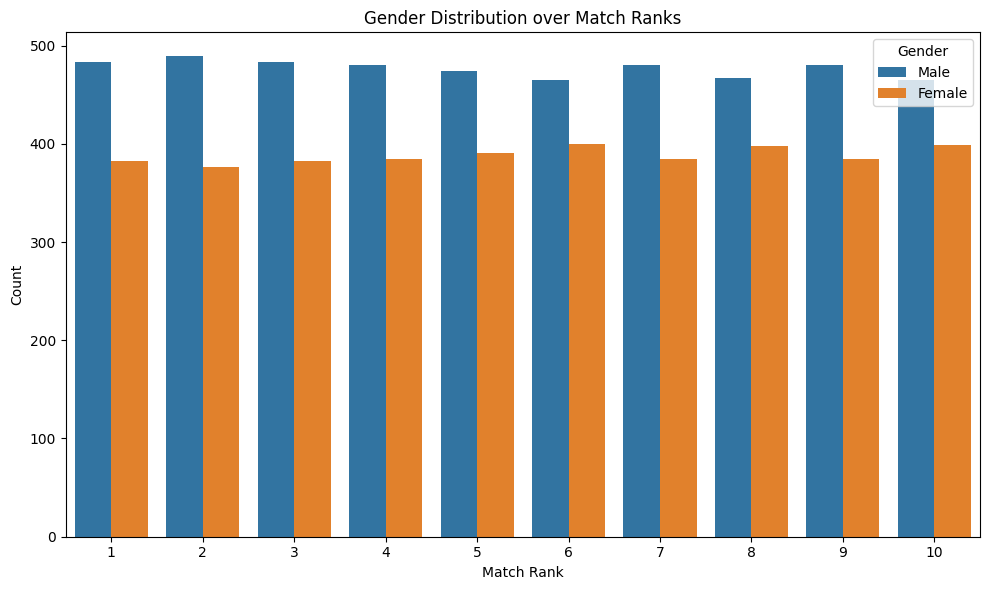

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='match_rank', hue='cand_gender', order=range(1, 11))
plt.title('Gender Distribution over Match Ranks')
plt.xlabel('Match Rank')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


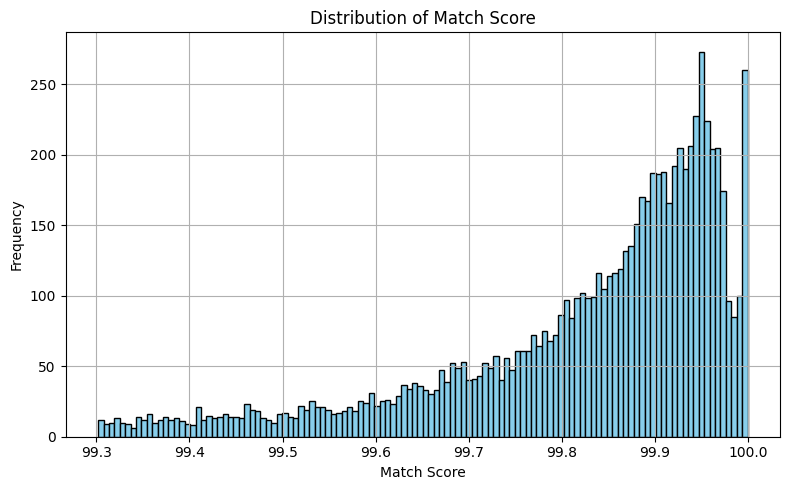

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(df[df['match_score'] > 99.3]['match_score'], bins=120, color='skyblue', edgecolor='black')
plt.title('Distribution of Match Score')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

We can assume that a candidate is hired if its match score is greater than a significant threshold, for instance, th=99.8

In [10]:
hired_threshold = 99.8

In [11]:
df1 = df.copy()

In [12]:
df1['hired'] = (df1['match_score'] >= hired_threshold).astype(int)

In [13]:
df1.shape

(8647, 15)

In [14]:
len(df1[df1['hired'] == 1])

5297

In [15]:
df1.targets = {'hired'}

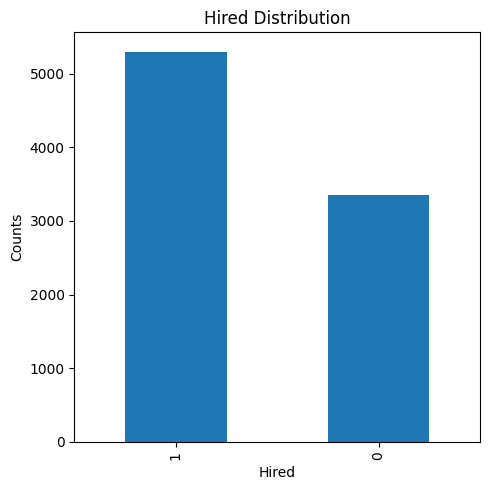

In [16]:
plt.figure(figsize=(5, 5))
df1['hired'].value_counts().plot(kind='bar')
plt.xlabel('Hired')
plt.ylabel('Counts')
plt.title('Hired Distribution')
plt.tight_layout()
plt.show()

Both the match rank and the match score are useless now that we extract the label, so we can drop them.

In [17]:
df1.drop(['match_score','match_rank'], axis=1, inplace=True)

In [18]:
df1.head()

cand_id         job_id  distance_km cand_gender cand_age_bucket  \
0  5,664,912  OFF_1011_1427    32.327042        Male           45-54   
1  4,999,120  OFF_1011_1427    15.595593        Male           35-44   
2  5,413,671  OFF_1011_1427    31.348877      Female           45-54   
3  5,965,090  OFF_1011_1427    66.315598        Male           15-24   
4  5,771,219  OFF_1011_1427    15.595593      Female           35-44   

  cand_domicile_province   cand_domicile_region cand_education  \
0                     UD  FRIULI VENEZIA GIULIA            NaN   
1                     UD  FRIULI VENEZIA GIULIA            NaN   
2                     UD  FRIULI VENEZIA GIULIA            NaN   
3                     TS  FRIULI VENEZIA GIULIA            NaN   
4                     UD  FRIULI VENEZIA GIULIA            NaN   

    job_contract_type                          job_professional_category  \
0  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
1  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
2  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
3  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
4  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   

                       job_sector job_work_province  hired  
0  Progettisti / Design / Grafici               UD       0  
1  Progettisti / Design / Grafici               UD       0  
2  Progettisti / Design / Grafici               UD       0  
3  Progettisti / Design / Grafici               UD       0  
4  Progettisti / Design / Grafici               UD       0

## Data Preprocessing

Before continuing with the data analysis we want to ensure that missing values are handled correctly and the data are ready to be feed in a classifier. Let's inspect some of their statistics.

In [19]:
print(f'Examples in the dataset: {df1.shape[0]}')

Examples in the dataset: 8647


In [20]:
df1.describe(include='all')

cand_id         job_id  distance_km cand_gender cand_age_bucket  \
count        8647           8647  8647.000000        8647            8646   
unique       6798            865          NaN           2               5   
top     6,550,205  OFF_1011_1427          NaN        Male           25-34   
freq           18             10          NaN        4766            2936   
mean          NaN            NaN    29.769432         NaN             NaN   
std           NaN            NaN    23.493063         NaN             NaN   
min           NaN            NaN     0.000000         NaN             NaN   
25%           NaN            NaN    12.253924         NaN             NaN   
50%           NaN            NaN    23.447361         NaN             NaN   
75%           NaN            NaN    41.754654         NaN             NaN   
max           NaN            NaN    99.966797         NaN             NaN   

       cand_domicile_province cand_domicile_region cand_education  \
count                    8644                 8642           2341   
unique                     79                   18            433   
top                        MI            LOMBARDIA  Licenza media   
freq                     1341                 3989            433   
mean                      NaN                  NaN            NaN   
std                       NaN                  NaN            NaN   
min                       NaN                  NaN            NaN   
25%                       NaN                  NaN            NaN   
50%                       NaN                  NaN            NaN   
75%                       NaN                  NaN            NaN   
max                       NaN                  NaN            NaN   

         job_contract_type        job_professional_category       job_sector  \
count                 8647                             8647             8647   
unique                   3                              247               26   
top     Lavoro subordinato  Operaio Generico Metalmeccanico  Operai Generici   
freq                  5658                              770             2829   
mean                   NaN                              NaN              NaN   
std                    NaN                              NaN              NaN   
min                    NaN                              NaN              NaN   
25%                    NaN                              NaN              NaN   
50%                    NaN                              NaN              NaN   
75%                    NaN                              NaN              NaN   
max                    NaN                              NaN              NaN   

       job_work_province        hired  
count               8647  8647.000000  
unique                53          NaN  
top                  MI           NaN  
freq                1689          NaN  
mean                 NaN     0.612582  
std                  NaN     0.487189  
min                  NaN     0.000000  
25%                  NaN     0.000000  
50%                  NaN     1.000000  
75%                  NaN     1.000000  
max                  NaN     1.000000

Most of the variables doen't miss any value, except for the <b>candidate domicile province</b> which misses just 3 values, the <b>candidate domicile region</b> which misses only 5 values, the <b>candidate age</b> which misses only 1 value and the <b>candidate education</b>, which instead misses way more values. We can account for the 3 missing  values by simply drop the related rows, but we must find a default value for the education since the rows containing missing values are too much.

In [21]:
df1 = df1[~df1['cand_domicile_province'].isnull()]
df1 = df1[~df1['cand_domicile_region'].isnull()]
df1 = df1[~df1['cand_age_bucket'].isnull()]

In general, we can keep all the numerical values, but we have to account for the categorical ones in order to feed a classifier. In the next paragraphs we will focus on the features that require our attention.

### IDs

Candidate id and job id are meaningless for the task of bias detection, hence we can easily drop them.

In [22]:
df1.drop(['cand_id','job_id'], axis=1, inplace=True)

### Distance Km

In [23]:
df1['distance_km'].describe()

count    8639.000000
mean       29.754485
std        23.484031
min         0.000000
25%        12.252331
50%        23.437698
75%        41.751572
max        99.966797
Name: distance_km, dtype: float64

We can approximate the distance by rounding it.

In [24]:
df1['distance_km'] = df1['distance_km'].apply(lambda d : round(d)).astype(int)

In [25]:
df1['distance_km'].describe()

count    8639.000000
mean       29.746846
std        23.475636
min         0.000000
25%        12.000000
50%        23.000000
75%        42.000000
max       100.000000
Name: distance_km, dtype: float64

First of all, let's inspect the distribution.

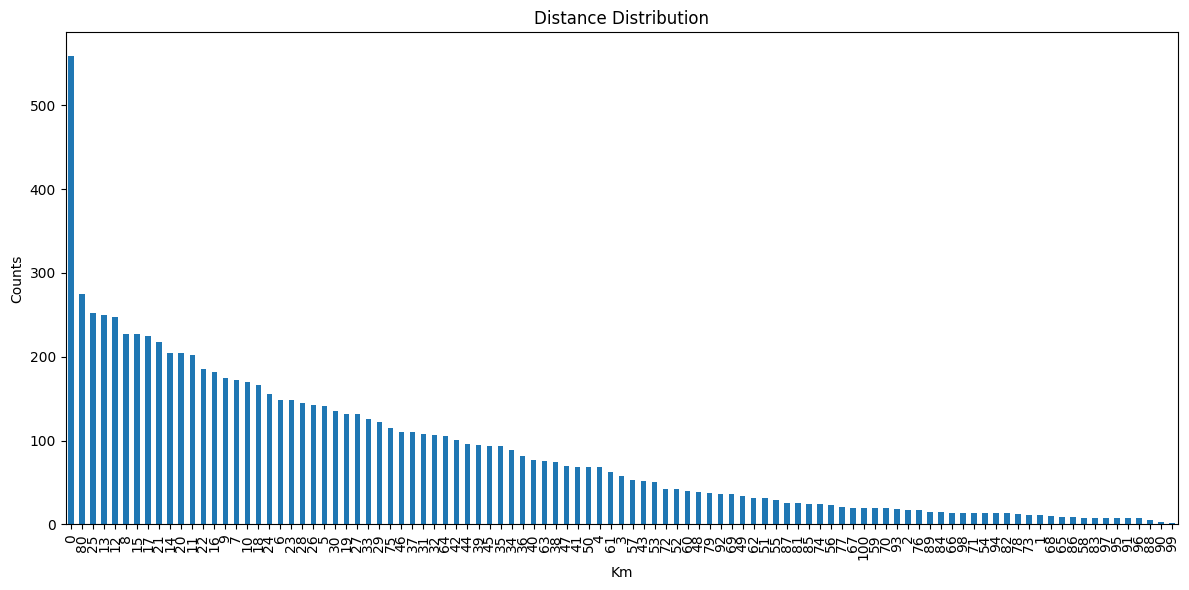

In [26]:
# Visualize the distribution
plt.figure(figsize=(12, 6))
df1['distance_km'].value_counts().plot(kind='bar')
plt.xlabel('Km')
plt.ylabel('Counts')
plt.title('Distance Distribution')
plt.tight_layout()
plt.show()

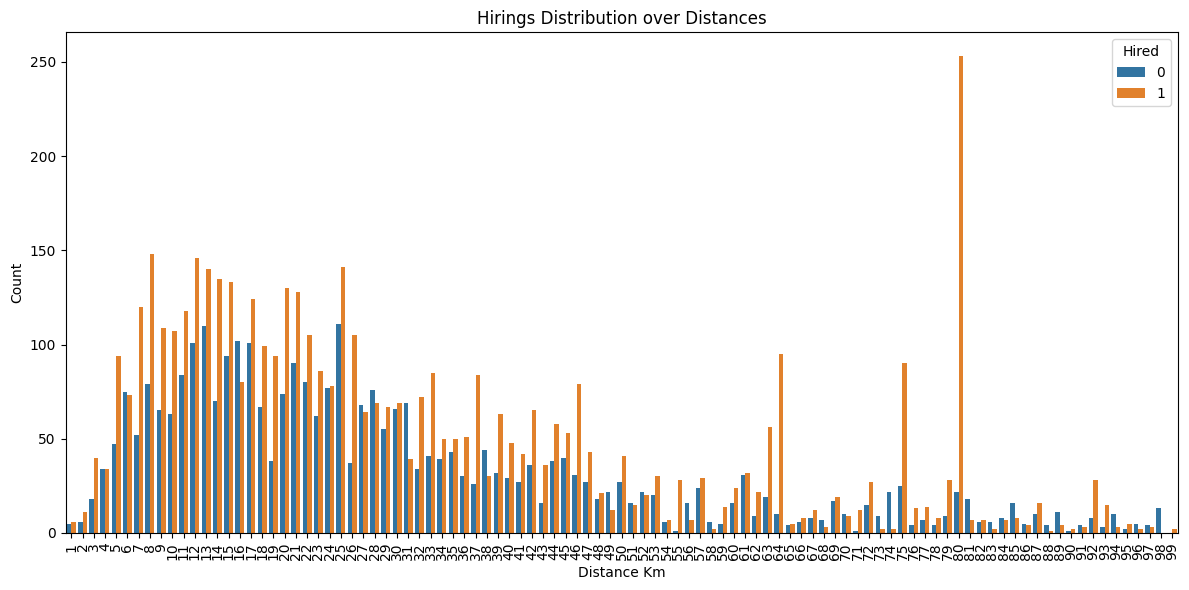

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df1, x='distance_km', hue='hired', order=range(1, max(df1['distance_km'])))
plt.title('Hirings Distribution over Distances')
plt.xlabel('Distance Km')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

From this plot we may suspect some bias related to the region of the candidate.

### Candidate Gender

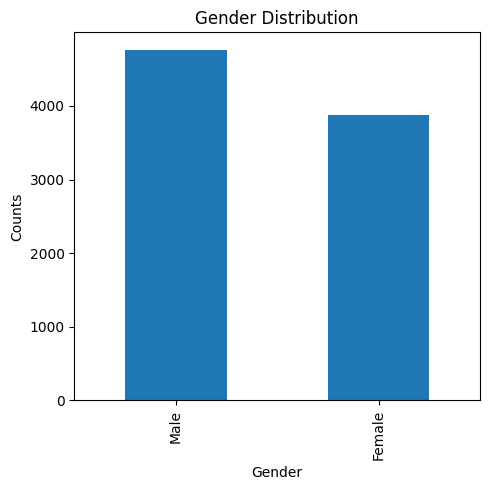

In [28]:
# Visualize the distribution
plt.figure(figsize=(5, 5))
df1['cand_gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

The dataset is imbalanced, but this tell us nothing about any possible bias or unfairness. In order to spot any kind of unfairness we should compare this distribution with the hirings.

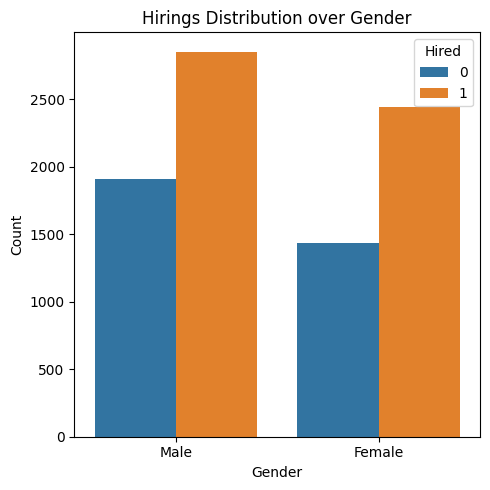

In [29]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, x='cand_gender', hue='hired')
plt.title('Hirings Distribution over Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

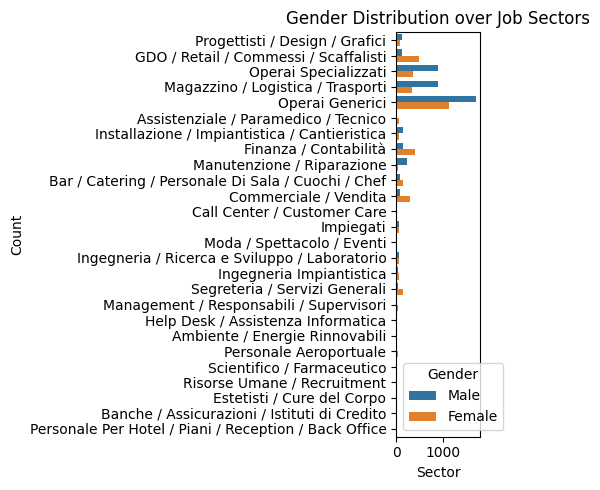

In [30]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df1, y='job_sector', hue='cand_gender')
plt.title('Gender Distribution over Job Sectors')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

The difference in the distributions may be due to high demand in that sectors

In [31]:
sensitive_features = ['cand_gender']

### Candidate Province

In [32]:
df1['cand_domicile_province'].describe()

count     8639
unique      78
top         MI
freq      1340
Name: cand_domicile_province, dtype: object

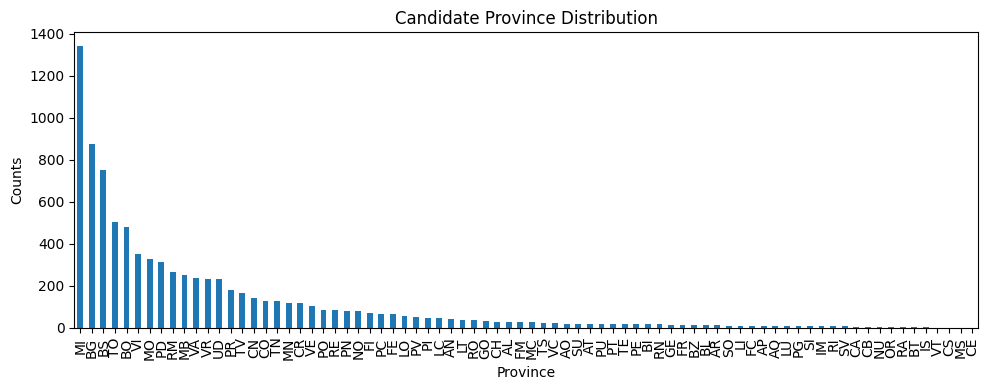

In [33]:
# Visualize the distribution
plt.figure(figsize=(10, 4))
df1['cand_domicile_province'].value_counts().plot(kind='bar')
plt.xlabel('Province')
plt.ylabel('Counts')
plt.title('Candidate Province Distribution')
plt.tight_layout()
plt.show()

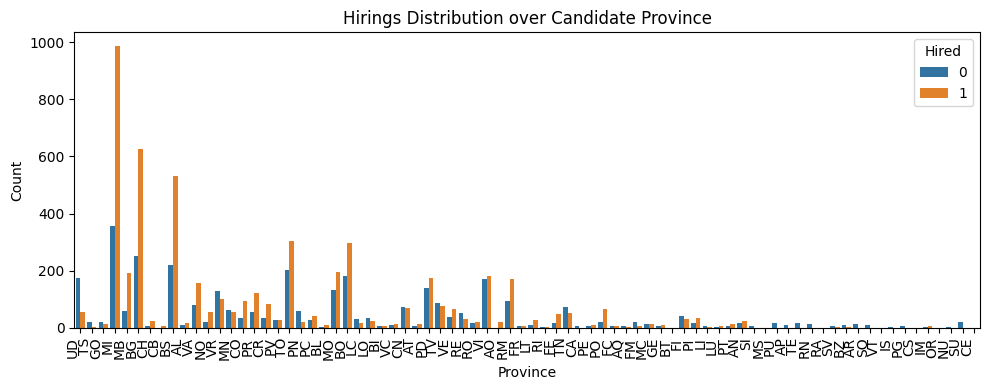

In [34]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df1, x='cand_domicile_province', hue='hired')
plt.title('Hirings Distribution over Candidate Province')
plt.xlabel('Province')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Here we can spot some bias towards the candidates coming from the north of Italy, but we need to aggregate the data in order to have a clearer overview.

In order to preprocess this feature, we have to ensure that even the job work province will be coherent with the candidate province, therefore we will use the same encoder for both of them.

In [35]:
province_encoder = OrdinalEncoder()
df1['cand_domicile_province'] = province_encoder.fit_transform(df1[['cand_domicile_province']])

### Domicile Region

In [36]:
df1['cand_domicile_region'].describe()

count          8639
unique           18
top       LOMBARDIA
freq           3988
Name: cand_domicile_region, dtype: object

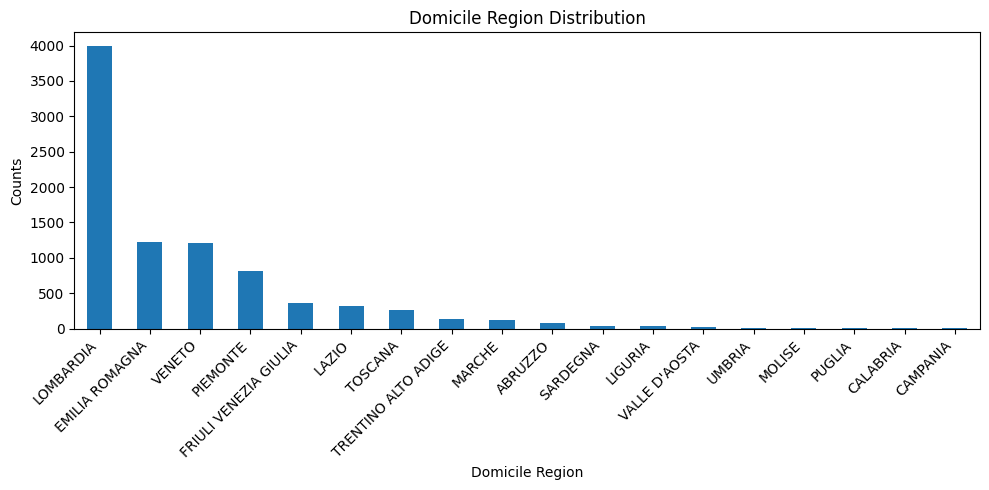

In [37]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['cand_domicile_region'].value_counts().plot(kind='bar')
plt.xlabel('Domicile Region')
plt.ylabel('Counts')
plt.title('Domicile Region Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [38]:
df_copy = df1.copy()
df_copy['gender_region'] = df_copy['cand_domicile_region'].astype(str) + ' ' + df_copy['cand_gender'].astype(str)

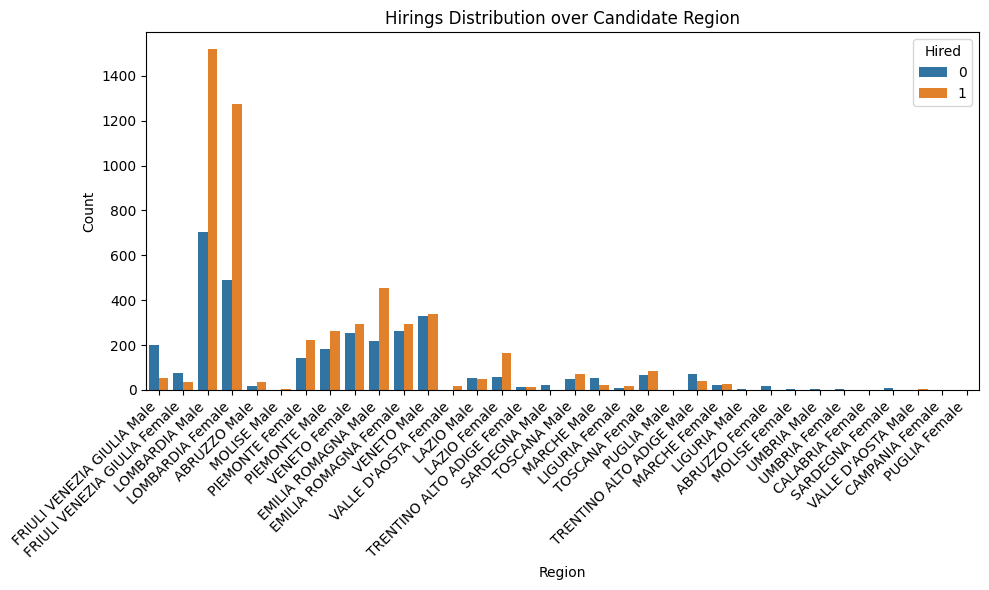

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='gender_region', hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
df_copy['gender_region'].value_counts()

gender_region
LOMBARDIA Male                  2222
LOMBARDIA Female                1766
EMILIA ROMAGNA Male              673
VENETO Male                      670
EMILIA ROMAGNA Female            557
VENETO Female                    545
PIEMONTE Male                    445
PIEMONTE Female                  366
FRIULI VENEZIA GIULIA Male       253
LAZIO Female                     222
TOSCANA Female                   149
TOSCANA Male                     118
FRIULI VENEZIA GIULIA Female     114
TRENTINO ALTO ADIGE Male         111
LAZIO Male                       100
MARCHE Male                       75
ABRUZZO Male                      54
MARCHE Female                     51
TRENTINO ALTO ADIGE Female        28
LIGURIA Female                    26
SARDEGNA Male                     22
ABRUZZO Female                    19
VALLE D'AOSTA Female              18
SARDEGNA Female                    9
MOLISE Male                        5
UMBRIA Male                        5
LIGURIA Male            

In [41]:
region_groups = {
    # North
    'piemonte': 'north',
    'valle d\'aosta': 'north',
    'lombardia': 'north',
    'veneto': 'north',
    'friuli venezia giulia': 'north',
    'liguria': 'north',
    'emilia romagna': 'north',
    'trentino alto adige': 'north',

    # Central
    'toscana': 'central',
    'umbria': 'central',
    'marche': 'central',
    'lazio': 'central',

    # South
    'abruzzo': 'south',
    'molise': 'south',
    'campania': 'south',
    'puglia': 'south',
    'basilicata': 'south',
    'calabria': 'south',

    # Islands
    'sicilia': 'south',
    'sardegna': 'south'
}

In [42]:
grouped_regions = df1['cand_domicile_region'].apply(lambda r : region_groups[str.lower(r)])
df1['grouped_regions'] = grouped_regions.astype(str) + ' ' + df1['cand_gender'].astype(str)

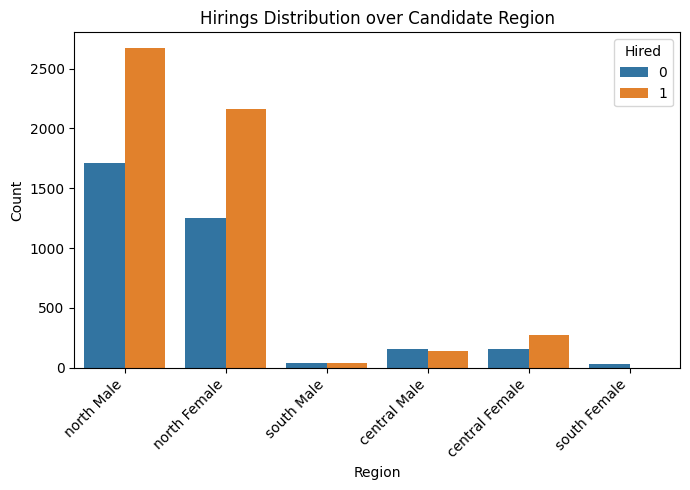

In [43]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df1, x=df1['grouped_regions'], hue='hired')
plt.title('Hirings Distribution over Candidate Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [44]:
df1 = df1.drop('cand_domicile_region', axis=1)
df1 = df1.drop('cand_gender', axis=1)

In [45]:
df1.head()

distance_km cand_age_bucket  cand_domicile_province cand_education  \
0           32           45-54                    71.0            NaN   
1           16           35-44                    71.0            NaN   
2           31           45-54                    71.0            NaN   
3           66           15-24                    69.0            NaN   
4           16           35-44                    71.0            NaN   

    job_contract_type                          job_professional_category  \
0  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
1  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
2  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
3  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   
4  Lavoro subordinato  Geometra e tecnico di costruzioni civili e ind...   

                       job_sector job_work_province  hired grouped_regions  
0  Progettisti / Design / Grafici               UD       0      north Male  
1  Progettisti / Design / Grafici               UD       0      north Male  
2  Progettisti / Design / Grafici               UD       0    north Female  
3  Progettisti / Design / Grafici               UD       0      north Male  
4  Progettisti / Design / Grafici               UD       0    north Female

In [46]:
df1['grouped_regions'].value_counts()

grouped_regions
north Male        4380
north Female      3420
central Female     426
central Male       298
south Male          82
south Female        33
Name: count, dtype: int64

### Age Buckets

In [47]:
df1['cand_age_bucket'].unique()

array(['45-54', '35-44', '15-24', '55-74', '25-34'], dtype=object)

In [48]:
print(f"Null age buckets: {df1['cand_age_bucket'].isnull().sum()}")

Null age buckets: 0


Since it is only one we can safely drop it.

In [49]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
25-34    2935
35-44    2129
45-54    1777
55-74     956
15-24     842
Name: count, dtype: int64

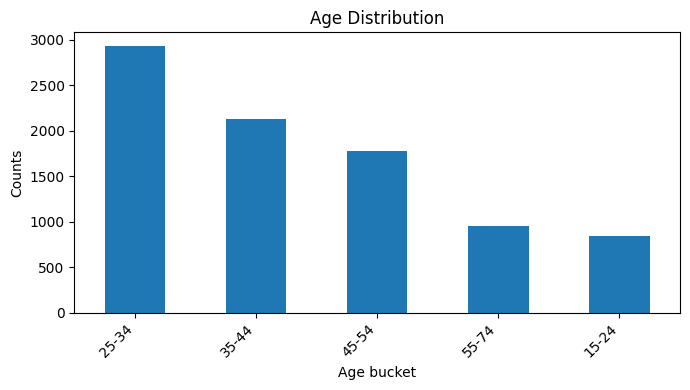

In [50]:
plt.figure(figsize=(7, 4))
df1['cand_age_bucket'].value_counts().plot(kind='bar')
plt.xlabel('Age bucket')
plt.ylabel('Counts')
plt.title('Age Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

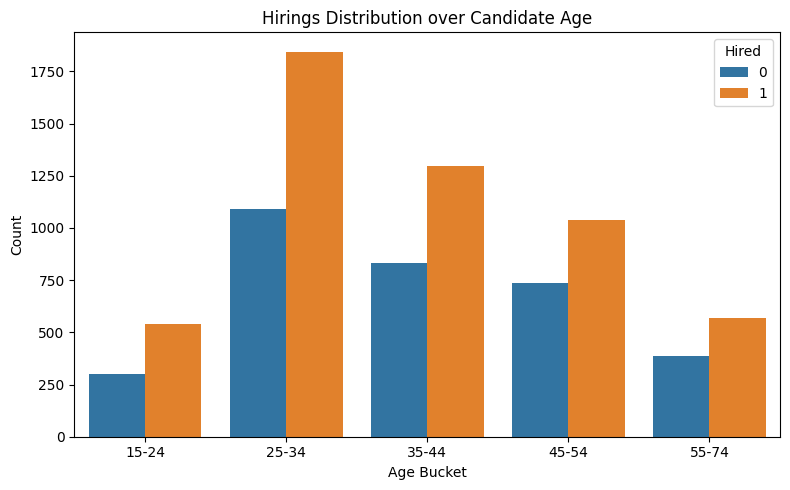

In [51]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_age_bucket', hue='hired', order=['15-24', '25-34', '35-44', '45-54', '55-74'])
plt.title('Hirings Distribution over Candidate Age')
plt.xlabel('Age Bucket')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.tight_layout()
plt.show()

In [52]:
sensitive_features.append('cand_age_bucket')

We can discretize them since they are numerical but preserves the order, thus we will use progressive enumeration.

In [53]:
age_bucket_order = {
    '15-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-74': 4,
}

df1['cand_age_bucket'] = df1['cand_age_bucket'].map(age_bucket_order).astype(int)

In [54]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
1    2935
2    2129
3    1777
4     956
0     842
Name: count, dtype: int64

### Candidate Education

In [55]:
def map_education_level(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    # Clean common formatting inconsistencies
    x = x.replace('laurea', 'degree')
    x = x.replace('diploma', 'degree')
    
    if 'dottorato' in x or 'phd' in x or 'research doctorate' in x:
        return 'PhD'
    elif 'master' in x or 'lm-' in x:
        return 'Graduate'
    elif 'bachelor' in x or 'l-' in x:
        return 'Undergraduate'
    elif 'higher technical institute' in x or 'its' in x:
        return 'Higher Technical Institute'
    elif 'qualification' in x or 'certificate' in x or 'operator' in x:
        return 'Vocational Certificate'
    elif 'high school' in x or 'liceo' in x or 'technician' in x or 'technical' in x:
        return 'High School'
    elif 'middle school' in x or 'scuola media' in x:
        return 'Middle School'
    elif 'elementary' in x:
        return 'Elementary School'
    else:
        return 'Other'


In [56]:
df1['cand_education'] = df1['cand_education'].apply(map_education_level)

In [57]:
df1['cand_education'].value_counts()

cand_education
Unknown                       6298
Other                         1546
Vocational Certificate         284
High School                    172
Higher Technical Institute     158
Graduate                       120
Undergraduate                   56
PhD                              5
Name: count, dtype: int64

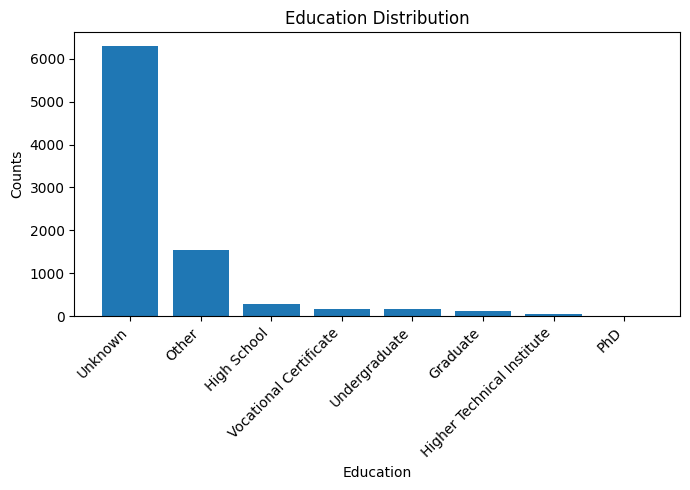

In [58]:
# Visualize the distribution
plt.figure(figsize=(7, 5))
plt.bar(df1['cand_education'].unique(), df1['cand_education'].value_counts())
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Education Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

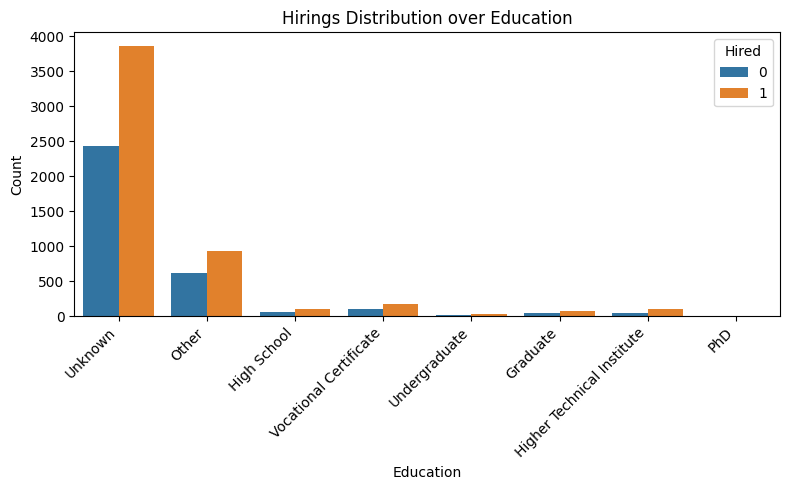

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='cand_education', hue='hired')
plt.title('Hirings Distribution over Education')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These results are probably not about any bias. However, we cannot say much looking only at this feature.

In [60]:
education_encoder = OrdinalEncoder()
df1['cand_education'] = education_encoder.fit_transform(df1[['cand_education']])

### Job Contract Type

In [61]:
df1['job_contract_type'].describe()

count                   8639
unique                     3
top       Lavoro subordinato
freq                    5653
Name: job_contract_type, dtype: object

In [62]:
df1['job_contract_type'].value_counts()

job_contract_type
Lavoro subordinato     5653
Ricerca e selezione    2966
Other                    20
Name: count, dtype: int64

In [63]:
contract_encoder = OrdinalEncoder()
df1['job_contract_type'] = contract_encoder.fit_transform(df1[['job_contract_type']])

### Job Category

In [64]:
df1['job_professional_category'].describe()

count                                8639
unique                                247
top       Operaio Generico Metalmeccanico
freq                                  770
Name: job_professional_category, dtype: object

In [65]:
category_encoder = OrdinalEncoder()
df1['job_professional_category'] = category_encoder.fit_transform(df1[['job_professional_category']])

### Job Sector

In [66]:
df1['job_sector'].describe()

count                8639
unique                 26
top       Operai Generici
freq                 2827
Name: job_sector, dtype: object

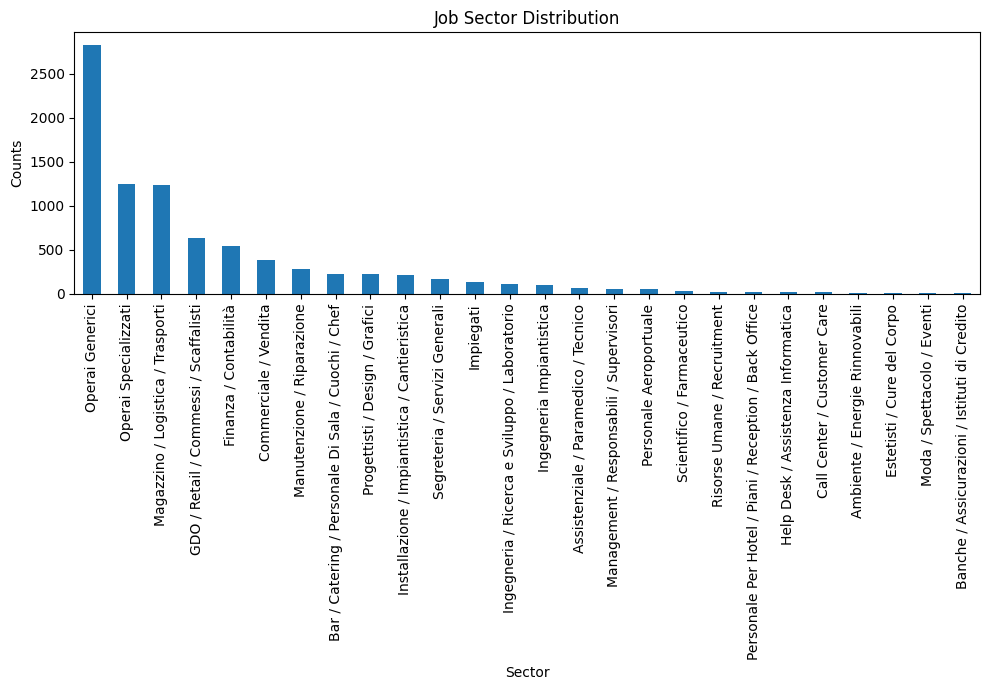

In [67]:
# Visualize the distribution
plt.figure(figsize=(10, 7))
df1['job_sector'].value_counts().plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Counts')
plt.title('Job Sector Distribution')
plt.tight_layout()
plt.show()

In [68]:
counts = df1['job_sector'].value_counts()
min_count = 30 #Statistically meaningful

rare = counts[counts < min_count].index

df1 = df1[~df1['job_sector'].isin(rare)]

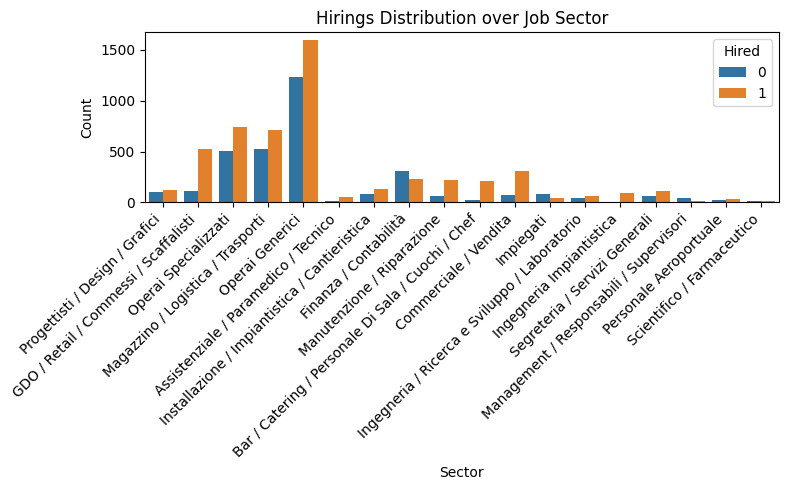

In [69]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='job_sector', hue='hired')
plt.title('Hirings Distribution over Job Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Hired')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [70]:
sector_encoder = OrdinalEncoder()
df1['job_sector'] = sector_encoder.fit_transform(df1[['job_sector']])

### Job Work Province

In [71]:
df1['job_work_province'].describe()

count     8520
unique      53
top        MI 
freq      1607
Name: job_work_province, dtype: object

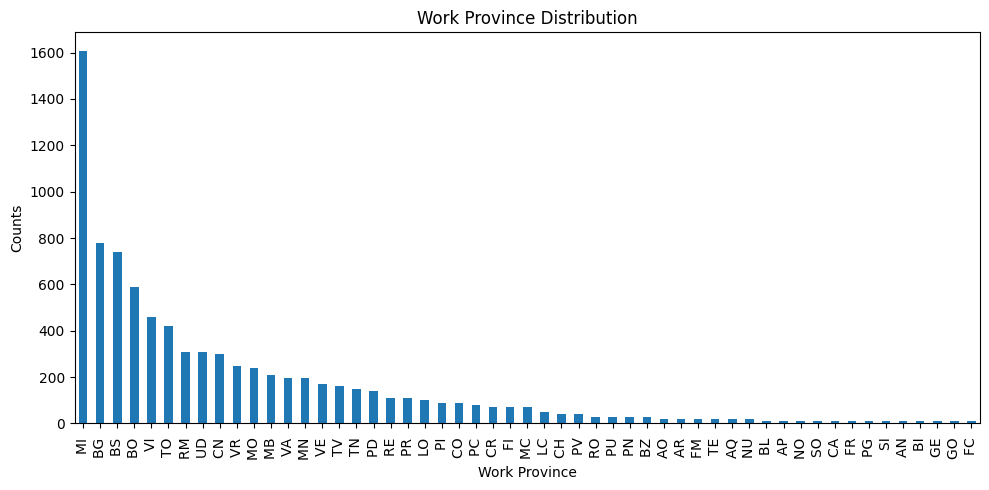

In [72]:
# Visualize the distribution
plt.figure(figsize=(10, 5))
df1['job_work_province'].value_counts().plot(kind='bar')
plt.xlabel('Work Province')
plt.ylabel('Counts')
plt.title('Work Province Distribution')
plt.tight_layout()
plt.show()

In [73]:
df1['job_work_province'] = province_encoder.fit_transform(df1[['job_work_province']])

### Considerations

Let's check the statistics of the dataset after the preprocessing

In [74]:
df1.describe(include='all')

distance_km  cand_age_bucket  cand_domicile_province  cand_education  \
count   8520.000000      8520.000000             8520.000000     8520.000000   
unique          NaN              NaN                     NaN             NaN   
top             NaN              NaN                     NaN             NaN   
freq            NaN              NaN                     NaN             NaN   
mean      29.658803         1.892019               39.069131        5.233685   
std       23.349403         1.170752               23.577801        1.530368   
min        0.000000         0.000000                0.000000        0.000000   
25%       12.000000         1.000000               11.000000        6.000000   
50%       23.000000         2.000000               38.000000        6.000000   
75%       42.000000         3.000000               59.000000        6.000000   
max      100.000000         4.000000               77.000000        7.000000   

        job_contract_type  job_professional_category   job_sector  \
count         8520.000000                8520.000000  8520.000000   
unique                NaN                        NaN          NaN   
top                   NaN                        NaN          NaN   
freq                  NaN                        NaN          NaN   
mean             0.677465                 136.788615     9.522183   
std              0.945372                  67.772409     4.105599   
min              0.000000                   0.000000     0.000000   
25%              0.000000                  91.000000     7.000000   
50%              0.000000                 126.000000    12.000000   
75%              2.000000                 203.000000    12.000000   
max              2.000000                 246.000000    17.000000   

        job_work_province        hired grouped_regions  
count         8520.000000  8520.000000            8520  
unique                NaN          NaN               6  
top                   NaN          NaN      north Male  
freq                  NaN          NaN            4350  
mean            27.065258     0.610681             NaN  
std             15.813288     0.487625             NaN  
min              0.000000     0.000000             NaN  
25%              9.000000     0.000000             NaN  
50%             26.000000     1.000000             NaN  
75%             44.000000     1.000000             NaN  
max             52.000000     1.000000             NaN

As we can observe, there are no more missing values, and the target lable distribution is almosto uniform.

In [75]:
sensitive_features = ['grouped_regions']

In [76]:
df1.sensitive = set(sensitive_features)

## Bias detection
Detecting bias on the dataset using Statistical Parity Difference

In [77]:
spd = df1.statistical_parity_difference()

In [78]:
print(spd)

{(hired=0, grouped_regions=central Female): -0.032443228428667314, (hired=0, grouped_regions=central Male): 0.1391642128509833, (hired=0, grouped_regions=north Female): -0.03122806966815528, (hired=0, grouped_regions=north Male): 0.005383279583229983, (hired=0, grouped_regions=south Female): 0.5522135458508736, (hired=0, grouped_regions=south Male): 0.08712907347134619, (hired=1, grouped_regions=central Female): 0.032443228428667314, (hired=1, grouped_regions=central Male): -0.1391642128509833, (hired=1, grouped_regions=north Female): 0.03122806966815539, (hired=1, grouped_regions=north Male): -0.005383279583230038, (hired=1, grouped_regions=south Female): -0.5522135458508735, (hired=1, grouped_regions=south Male): -0.08712907347134624}


In [79]:
labels = [f"{item}" for _,item in spd[{'hired': 1}].keys()]
values = list(spd[{'hired': 1}].values())

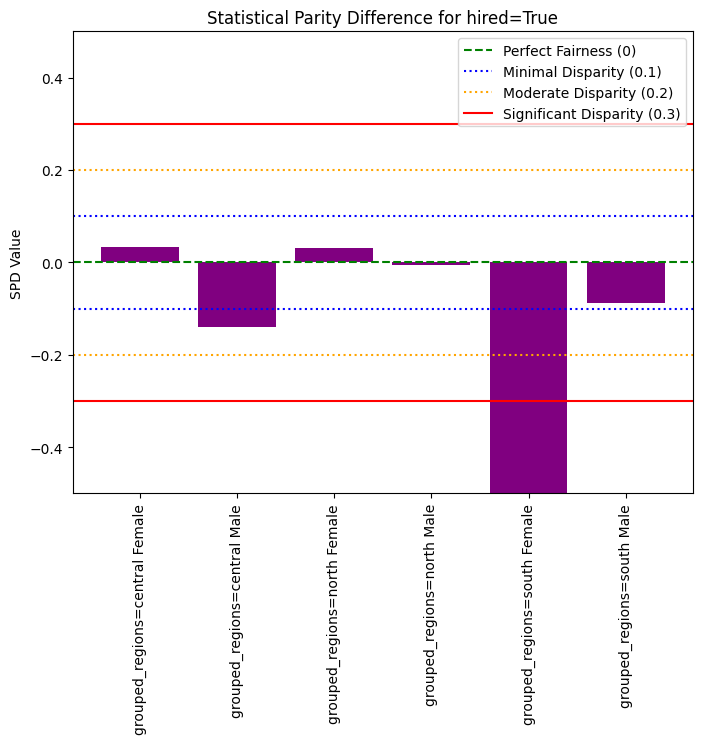

In [80]:
plt.figure(figsize=(8, 6))

plt.axhline(y=0, color='green', linestyle='--', label="Perfect Fairness (0)")

plt.axhline(y=0.1, color='blue', linestyle=':', label="Minimal Disparity (0.1)")
plt.axhline(y=-0.1, color='blue', linestyle=':')
plt.axhline(y=0.2, color='orange', linestyle=':', label="Moderate Disparity (0.2)")
plt.axhline(y=-0.2, color='orange', linestyle=':')
plt.axhline(y=0.3, color='red', linestyle='-', label="Significant Disparity (0.3)")
plt.axhline(y=-0.3, color='red', linestyle='-')

plt.bar(labels, values, color=['purple', 'purple'])


plt.title("Statistical Parity Difference for hired=True")
plt.ylabel("SPD Value")
plt.xticks(rotation=90)
plt.ylim([-0.5, 0.5])

plt.legend()
plt.show()

In [81]:
grouped_regions_encoder = OrdinalEncoder()
df1['grouped_regions'] = grouped_regions_encoder.fit_transform(df1[['grouped_regions']])

In [82]:
spd1 = df1.statistical_parity_difference()

In [83]:
spd1 

(hired=0, grouped_regions=0.0) -> -0.032443228428667314
(hired=0, grouped_regions=1.0) -> 0.1391642128509833
(hired=0, grouped_regions=2.0) -> -0.03122806966815528
(hired=0, grouped_regions=3.0) -> 0.005383279583229983
(hired=0, grouped_regions=4.0) -> 0.5522135458508736
(hired=0, grouped_regions=5.0) -> 0.08712907347134619
(hired=1, grouped_regions=0.0) -> 0.032443228428667314
(hired=1, grouped_regions=1.0) -> -0.1391642128509833
(hired=1, grouped_regions=2.0) -> 0.03122806966815539
(hired=1, grouped_regions=3.0) -> -0.005383279583230038
(hired=1, grouped_regions=4.0) -> -0.5522135458508735
(hired=1, grouped_regions=5.0) -> -0.08712907347134624

### Correlation Matrix

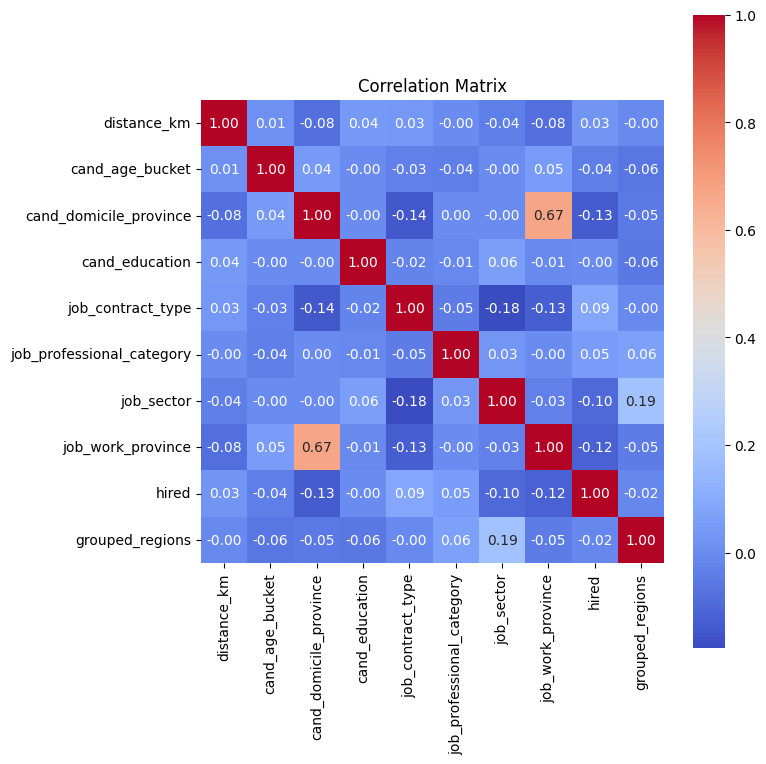

In [84]:
plt.figure(figsize=(8, 8))
sns.heatmap(df1.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Bias mitigation techniques

### Utils

In [85]:
sensitive_feature = 'grouped_regions'
target = df1.targets.pop()

baseline_performance_metrics = []
baseline_fairness_metrics = []

preprocessing_performance_metrics = []
preprocessing_fairness_metrics = []

In [86]:
def compute_performance_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_proba)
    }

In [87]:
def compute_fairness_metrics(y_true, y_pred, sensitive_features):
    return {
        'dpr': demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features),
        'eor': equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    }

In [88]:
def evaluate_spd(X_test, y_pred):
    X_test_copy = X_test.copy()
    X_test_copy[target] = y_pred
    dataset = fl.DataFrame(X_test_copy)
    dataset.targets = target
    dataset.sensitive = sensitive_feature

    spd = dataset.statistical_parity_difference()
    return spd

In [89]:
def metrics_bar_plot(dict1, dict2, label1, label2, metrics, title="Metric Comparison (mean ± std)"):
    import numpy as np
    import matplotlib.pyplot as plt

    def summarise(fold_dicts):
        means = []
        stds = []
        for m in metrics:
            values = [fold.get(m, np.nan) for fold in fold_dicts]
            # Usa nanmean e nanstd per evitare problemi con NaN
            mean_val = np.nanmean(values)
            std_val = np.nanstd(values)
            means.append(mean_val)
            stds.append(std_val)
        return np.array(means), np.array(stds)

    mean1, std1 = summarise(dict1)
    mean2, std2 = summarise(dict2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for ax, mean, std, label in zip(axes, [mean1, mean2], [std1, std2], [label1, label2]):
        ax.bar(metrics, mean, yerr=std, capsize=4)
        ax.set_title(label)
        ax.set_ylim(0, 1.2)  # leggermente sopra 1 per sicurezza
        ax.grid(axis="y", alpha=0.3)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [90]:
class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()
        input_dim = df1.shape[-1]-1
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

### Pre-Processing

In this section, we preprocess the dataset to prepare it for fair machine learning analysis. The preprocessing steps include handling missing values, encoding categorical variables, and normalizing numerical features. We also define the sensitive attribute(s) for fairness evaluation.

**Fairness Metrics Used:**
- **Demographic Parity Ratio (DPR):** Measures the ratio of positive outcomes across sensitive groups.
- **Equalized Odds Ratio (EOR):** Compares true positive and false positive rates across groups.
- **Statistical Parity Difference (SPD):** Assesses the difference in selection rates between groups.

**Performance Metrics Used:**
- **Accuracy**
- **Precision**
- **Recall**
- **AUC (Area Under the ROC Curve)**

We evaluate both baseline and pre-processing fairness mitigation methods (Reweighing, Disparate Impact Remover, LFR) using these metrics. The results show that while some approaches can improve fairness (as measured by DPR, EOR, and SPD), there may be trade-offs with performance metrics. Additionally, the variance in fairness metrics highlights the impact of data imbalance, especially for under-represented groups.

#### Utility functions

In [94]:
def train_classifier(X_train, y_train):
    """
    Train a logistic regression classifier.
    """
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)
    return clf

In [95]:
def prepare_set(X, y, target):
    X_with_target = X.copy()
    X_with_target[target] = y.copy()
    dataset = fl.DataFrame(X_with_target)
    dataset.targets = target
    dataset.sensitive = [sensitive_feature]
    return dataset 

In [96]:
def compute_mean_spd(spd_values):
    '''
    Compute the mean absolute Statistical Parity Difference (SPD) across all folds and groups.
    '''
    mean_spd_values = {}
    for approach in spd_values:
        all_spds = []
        for fold_dict in spd_values[approach]:
            all_spds.extend([abs(v) for v in fold_dict.values()])
        mean_spd_values[approach] = np.mean(all_spds)
    results = pd.DataFrame({
        'Approach': list(mean_spd_values.keys()),
        'Mean |SPD|': list(mean_spd_values.values())
    })
    return results

def plot_spd_results(spd_results, label="Mean"):
    plt.figure(figsize=(8, 5))
    plt.bar(spd_results['Approach'], spd_results['Mean |SPD|'], color='cornflowerblue')
    plt.title(f"{label} Absolute SPD across folds and groups")
    plt.ylabel(f"{label} |SPD|")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def print_mean_values(values):
    ''' Print the performance or fairness values for each approach '''
    for approach in values:
        print(f"=== {approach} ===")
        for metric, value in values[approach]['mean'].items():
            print(f"  {metric}: {value:.4f}")
        print()


def compute_metrics_dict(metrics):
    '''
    Compute mean and standard deviation for each metric across all approaches.
    '''
    values = {}
    for approach in metrics:
        metrics_list = metrics[approach]
        df = pd.DataFrame(metrics_list)
        means = df.mean()
        stds = df.std()
        # Store both
        values[approach] = {
            'mean': means.to_dict(),
            'std': stds.to_dict()
        }
    return values


def plot_metrics(values, preprocess_approaches, label="Performance"):
    """
    Plot the performance or fairness metrics for each approach.
    """
    for approach in ["Baseline"] + preprocess_approaches:
        means = values[approach]["mean"]
        stds = values[approach]["std"]

        if label == "Performance":
            metrics = ["accuracy", "precision", "recall", "auc"]
        elif label == "Fairness":
            metrics = ["dpr", "eor"]
        else :
            raise ValueError("Label must be either 'Performance' or 'Fairness'.")
        
        plt.figure(figsize=(8,5))
        plt.bar(metrics, [means[m] for m in metrics], yerr=[stds[m] for m in metrics], capsize=5, color='cornflowerblue')
        plt.title(f"{label} Metrics - {approach} (Mean ± Std across folds)")
        plt.ylabel("Metric Value")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

#### Naive Train-Test split
Firstly, we only consider one fold:

In [97]:
X = df1.drop(columns=target)
y = df1[target]

preprocess_approaches = ['Reweighing', 'DIR', 'LRF']

performance_metrics = {approach: [] for approach in ['Baseline'] + preprocess_approaches}
fairness_metrics = {approach: [] for approach in ['Baseline'] + preprocess_approaches}
spd_values = {approach: [] for approach in ['Baseline'] + preprocess_approaches}

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ==========================
# BASELINE
# ==========================
baseline = LogisticRegression(max_iter=1000, solver='liblinear')
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)
y_proba = baseline.predict_proba(X_test)[:, 1]

performance_metrics['Baseline'].append(
    compute_performance_metrics(y_test, y_pred, y_proba)
)
fairness_metrics['Baseline'].append(
    compute_fairness_metrics(y_test, y_pred, X_test[sensitive_feature])
)
spd_values['Baseline'].append(
    evaluate_spd(X_test, y_pred)
)

# ==========================
# PREPROCESSING METHODS
# ==========================
for approach in preprocess_approaches:

    # Wrap train/test into your special DataFrame class
    train_dataset = prepare_set(X_train, y_train, target)
    test_dataset = prepare_set(X_test, y_test, target)

    if approach == 'Reweighing':
        reweighing = Reweighing()
        reweighed_df = reweighing.fit_transform(train_dataset)
        weights = reweighed_df['weights'].values
        X_train_reweighed = X_train.copy()

        clf = LogisticRegression(random_state=42, max_iter=1000)
        clf.fit(X_train_reweighed, y_train, sample_weight=weights)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]

        performance_metrics[approach].append(
            compute_performance_metrics(y_test, y_pred, y_proba)
        )
        fairness_metrics[approach].append(
            compute_fairness_metrics(y_test, y_pred, X_test[sensitive_feature])
        )
        spd_values[approach].append(
            evaluate_spd(X_test, y_pred)
        )

    elif approach == 'DIR':
        dir = DisparateImpactRemover(repair_level=0.9)
        X_train_repaired = dir.fit_transform(train_dataset)
        X_test_repaired = dir.fit_transform(test_dataset)

        clf = LogisticRegression(random_state=42, max_iter=1000)
        clf.fit(X_train_repaired, y_train)
        y_pred = clf.predict(X_test_repaired)
        y_proba = clf.predict_proba(X_test_repaired)[:, 1]

        performance_metrics[approach].append(
            compute_performance_metrics(y_test, y_pred, y_proba)
        )
        fairness_metrics[approach].append(
            compute_fairness_metrics(y_test, y_pred, X_test_repaired[sensitive_feature])
        )
        spd_values[approach].append(
            evaluate_spd(X_test, y_pred)
        )

    elif approach == 'LRF':
        lfr = LFR(
            input_dim=X_train.shape[1],
            latent_dim=8,
            output_dim=X_train.shape[1],
            alpha_z=1.0,
            alpha_x=1.0,
            alpha_y=1.0
        )

        lfr.fit(train_dataset, epochs=8, batch_size=32)
        X_train_transformed = lfr.transform(train_dataset)
        X_test_transformed = lfr.transform(test_dataset)

        clf = LogisticRegression(random_state=42, max_iter=1000)
        clf.fit(X_train_transformed, y_train)
        y_pred = clf.predict(X_test_transformed)
        y_proba = clf.predict_proba(X_test_transformed)[:, 1]

        performance_metrics[approach].append(
            compute_performance_metrics(y_test, y_pred, y_proba)
        )
        fairness_metrics[approach].append(
            compute_fairness_metrics(y_test, y_pred, test_dataset[sensitive_feature])
        )
        spd_values[approach].append(
            evaluate_spd(X_test, y_pred)
        )

##### Fairness metrics

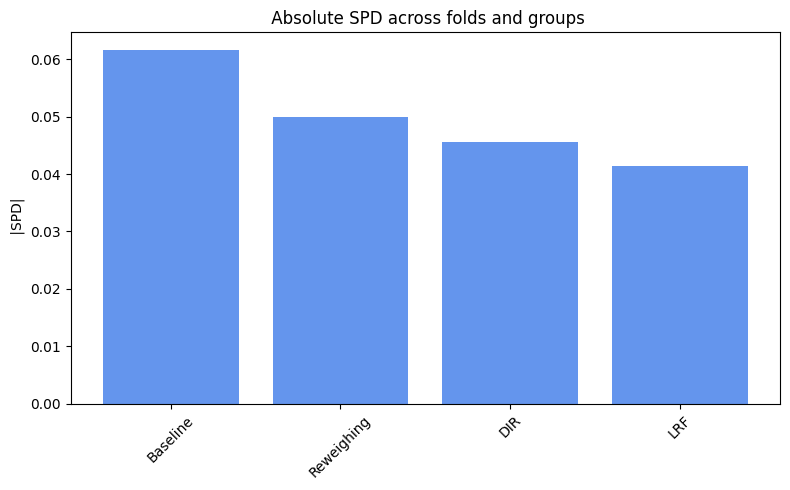

In [98]:
spd_results = compute_mean_spd(spd_values)
plot_spd_results(spd_results, label="")

Plot DPR and EOR

In [99]:
fairness_values = compute_metrics_dict(fairness_metrics)
print_mean_values(fairness_values) # Print the fairness values for each approach

=== Baseline ===
  dpr: 0.8358
  eor: 0.7838

=== Reweighing ===
  dpr: 0.8411
  eor: 0.7871

=== DIR ===
  dpr: 0.8697
  eor: 0.8378

=== LRF ===
  dpr: 0.8182
  eor: 0.6667



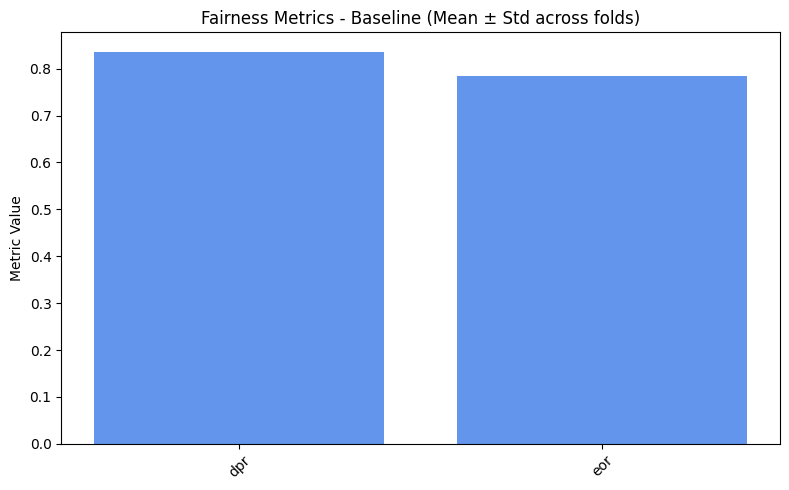

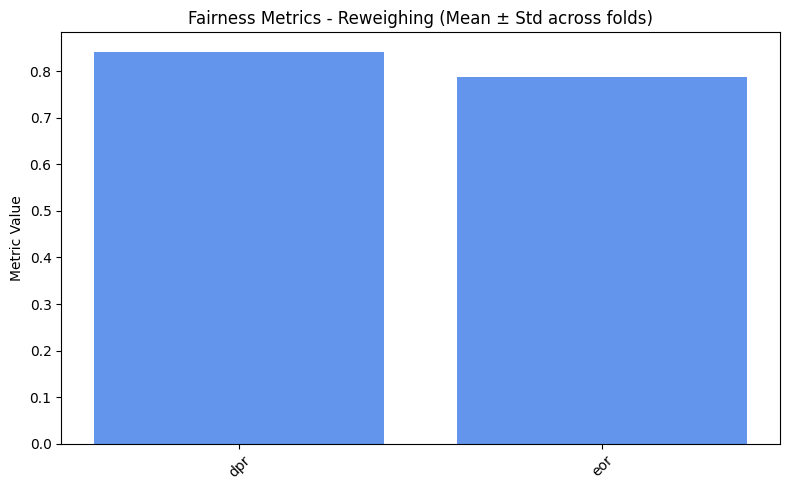

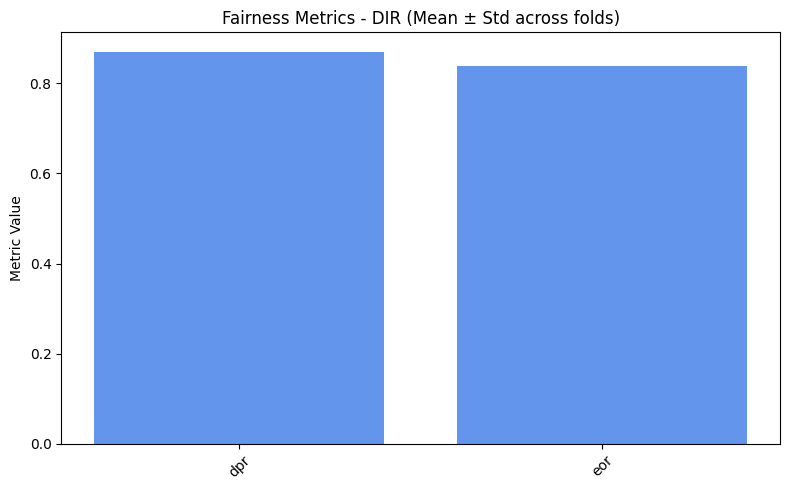

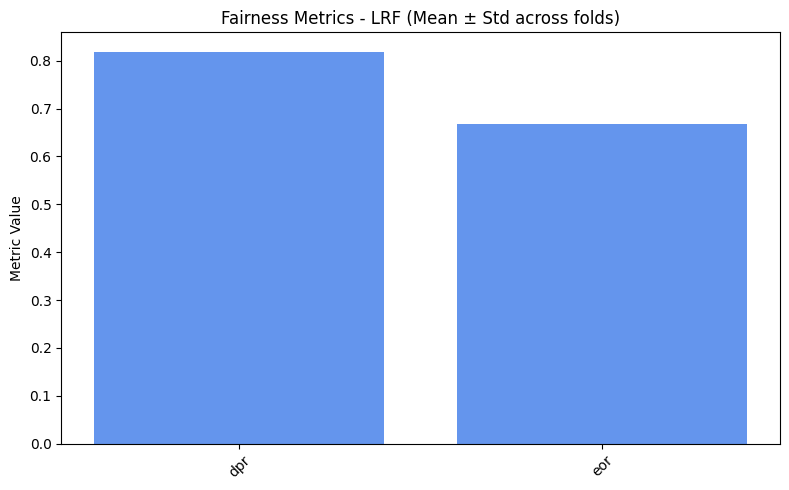

In [100]:
plot_metrics(fairness_values, preprocess_approaches, label="Fairness")

##### Performance metrics
Our chosen metrics: Accuracy, Precision, Recall, AUC

In [101]:
performance_values = compute_metrics_dict(performance_metrics)
print_mean_values(performance_values) # Print the performance values for each approach

=== Baseline ===
  accuracy: 0.6244
  precision: 0.6382
  recall: 0.8934
  auc: 0.6117

=== Reweighing ===
  accuracy: 0.6232
  precision: 0.6376
  recall: 0.8921
  auc: 0.6112

=== DIR ===
  accuracy: 0.6138
  precision: 0.6276
  recall: 0.9093
  auc: 0.5957

=== LRF ===
  accuracy: 0.6162
  precision: 0.6166
  recall: 0.9879
  auc: 0.5337



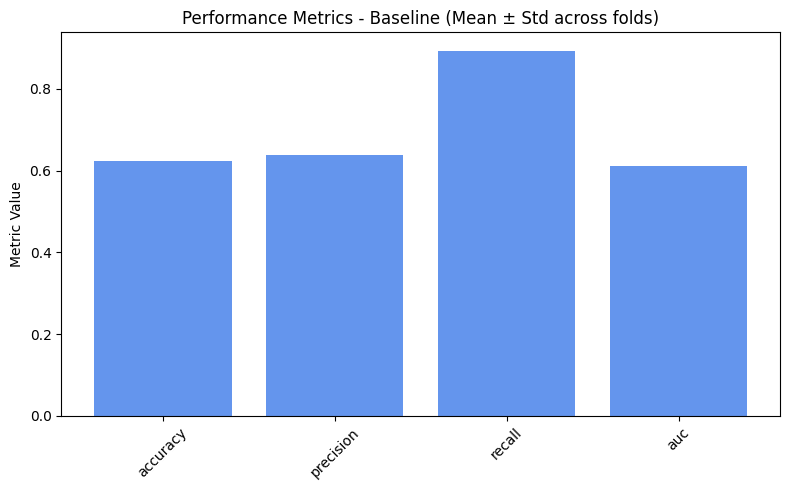

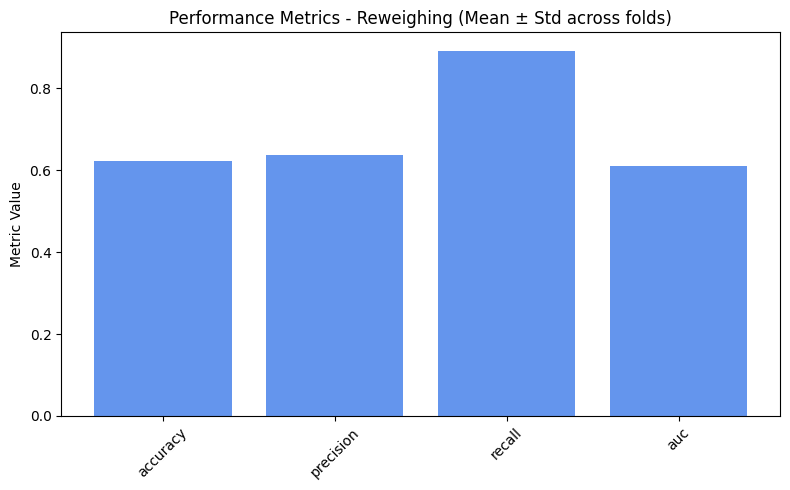

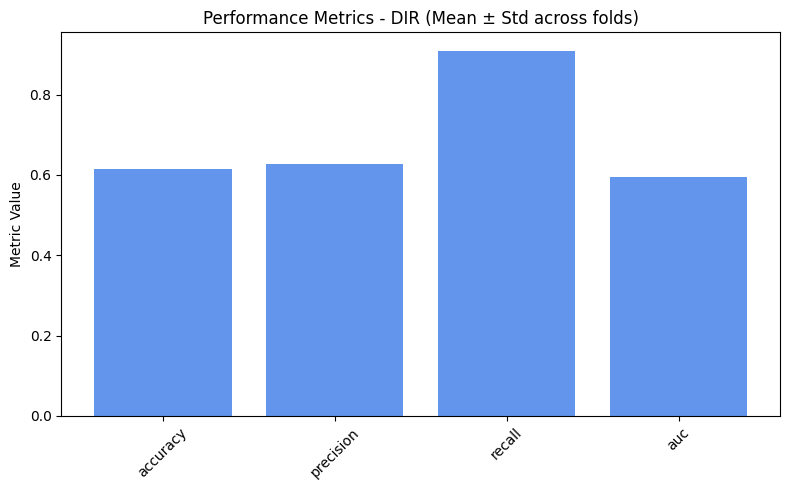

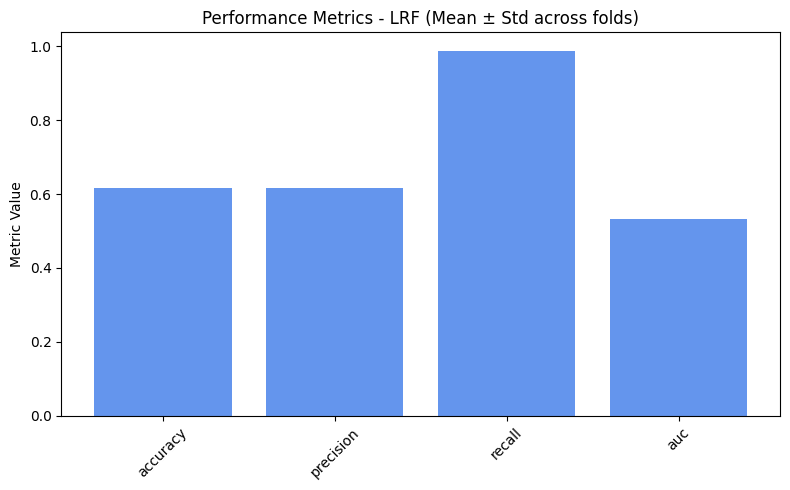

In [102]:
plot_metrics(performance_values, preprocess_approaches, label="Performance")

#### Stratified K-fold cross-validation
We test two different splitting protocols, which, as we will see, significantly impact the results:

1. Stratification based on the *target* feature only

2. Stratification based on the *target + sensitive* feature combination

In [103]:
def skf_cross_validation(df1, target, sensitive_feature, split_type='target'):
    """ Perform Stratified K-Fold Cross-Validation on the dataset.
    Args:
        df1 (pd.DataFrame): The input DataFrame containing the dataset.
        target (str): The target variable for classification.
        sensitive_feature (str): The sensitive feature to be considered for fairness metrics.
    Returns:
        performance_metrics (dict): A dictionary containing performance metrics for each approach.
        fairness_metrics (dict): A dictionary containing fairness metrics for each approach.
        spd_values (dict): A dictionary containing SPD values for each approach.
    """
    X = df1.drop(columns=target)
    y = df1[target]

    preprocess_approaches = ['Reweighing', 'DIR', 'LRF']

    performance_metrics = {approach: [] for approach in ['Baseline'] + preprocess_approaches}
    fairness_metrics = {approach: [] for approach in ['Baseline'] + preprocess_approaches}
    spd_values = {approach: [] for approach in ['Baseline'] + preprocess_approaches}

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    x_split = df1
    if split_type == 'target':
        y_split = df1[target].astype(str)
    elif split_type == 'target+sensitive':
        y_split = df1[target].astype(str) + df1[sensitive_feature].astype(str)

    for _, (train_idx, test_idx) in enumerate(kf.split(x_split, y_split)):
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        # ==========================
        # BASELINE
        # ==========================
        baseline = LogisticRegression(max_iter=1000, solver='liblinear')
        baseline.fit(X_train, y_train)
        y_pred = baseline.predict(X_test)
        y_proba = baseline.predict_proba(X_test)[:, 1]

        performance_metrics['Baseline'].append(
            compute_performance_metrics(y_test, y_pred, y_proba)
        )
        fairness_metrics['Baseline'].append(
            compute_fairness_metrics(y_test, y_pred, X_test[sensitive_feature])
        )
        spd_values['Baseline'].append(
            evaluate_spd(X_test, y_pred)
        )

        # ==========================
        # PREPROCESSING METHODS
        # ==========================
        for approach in preprocess_approaches:

            # Wrap train/test into your special DataFrame class
            train_dataset = prepare_set(X_train, y_train, target)
            test_dataset = prepare_set(X_test, y_test, target)

            if approach == 'Reweighing':
                reweighing = Reweighing()
                reweighed_df = reweighing.fit_transform(train_dataset)
                weights = reweighed_df['weights'].values
                X_train_reweighed = X_train.copy()

                clf = LogisticRegression(random_state=42, max_iter=1000)
                clf.fit(X_train_reweighed, y_train, sample_weight=weights)
                y_pred = clf.predict(X_test)
                y_proba = clf.predict_proba(X_test)[:, 1]

                performance_metrics[approach].append(
                    compute_performance_metrics(y_test, y_pred, y_proba)
                )
                fairness_metrics[approach].append(
                    compute_fairness_metrics(y_test, y_pred, X_test[sensitive_feature])
                )
                spd_values[approach].append(
                    evaluate_spd(X_test, y_pred)
                )

            elif approach == 'DIR':
                dir = DisparateImpactRemover(repair_level=0.9)
                X_train_repaired = dir.fit_transform(train_dataset)
                X_test_repaired = dir.fit_transform(test_dataset)

                clf = LogisticRegression(random_state=42, max_iter=1000)
                clf.fit(X_train_repaired, y_train)
                y_pred = clf.predict(X_test_repaired)
                y_proba = clf.predict_proba(X_test_repaired)[:, 1]

                performance_metrics[approach].append(
                    compute_performance_metrics(y_test, y_pred, y_proba)
                )
                fairness_metrics[approach].append(
                    compute_fairness_metrics(y_test, y_pred, X_test_repaired[sensitive_feature])
                )
                spd_values[approach].append(
                    evaluate_spd(X_test, y_pred)
                )

            elif approach == 'LRF':
                lfr = LFR(
                    input_dim=X_train.shape[1],
                    latent_dim=8,
                    output_dim=X_train.shape[1],
                    alpha_z=1.0,
                    alpha_x=1.0,
                    alpha_y=1.0
                )

                lfr.fit(train_dataset, epochs=8, batch_size=32)
                X_train_transformed = lfr.transform(train_dataset)
                X_test_transformed = lfr.transform(test_dataset)

                clf = LogisticRegression(random_state=42, max_iter=1000)
                clf.fit(X_train_transformed, y_train)
                y_pred = clf.predict(X_test_transformed)
                y_proba = clf.predict_proba(X_test_transformed)[:, 1]

                performance_metrics[approach].append(
                    compute_performance_metrics(y_test, y_pred, y_proba)
                )
                fairness_metrics[approach].append(
                    compute_fairness_metrics(y_test, y_pred, test_dataset[sensitive_feature])
                )
                spd_values[approach].append(
                    evaluate_spd(X_test, y_pred)
                )

    return performance_metrics, fairness_metrics, spd_values

##### 1) Splitting on "target" feature

In [218]:
performance_metrics, fairness_metrics, spd_values = skf_cross_validation(df1, target, sensitive_feature, split_type='target')

1.1) Fairness metrics

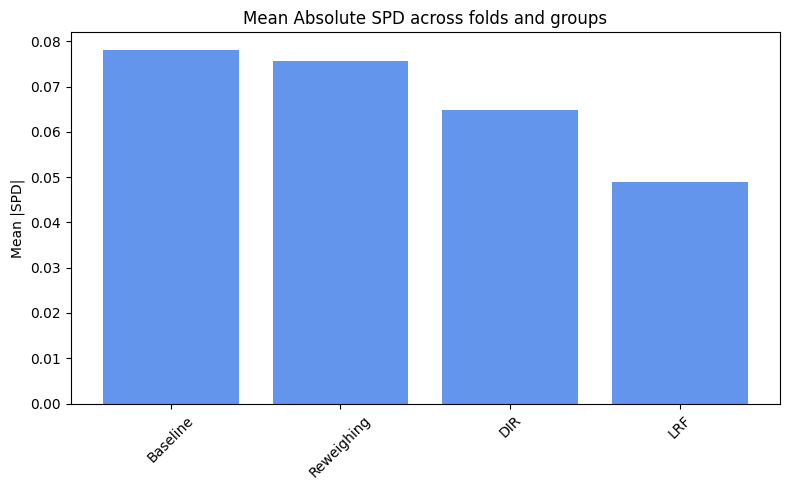

In [220]:
spd_results = compute_mean_spd(spd_values)
plot_spd_results(spd_results, label="Mean")

In [221]:
fairness_values = compute_metrics_dict(fairness_metrics)
print_mean_values(fairness_values) # Print the fairness values for each approach

=== Baseline ===
  dpr: 0.7746
  eor: 0.1518

=== Reweighing ===
  dpr: 0.7620
  eor: 0.1429

=== DIR ===
  dpr: 0.7794
  eor: 0.1429

=== LRF ===
  dpr: 0.8673
  eor: 0.3285



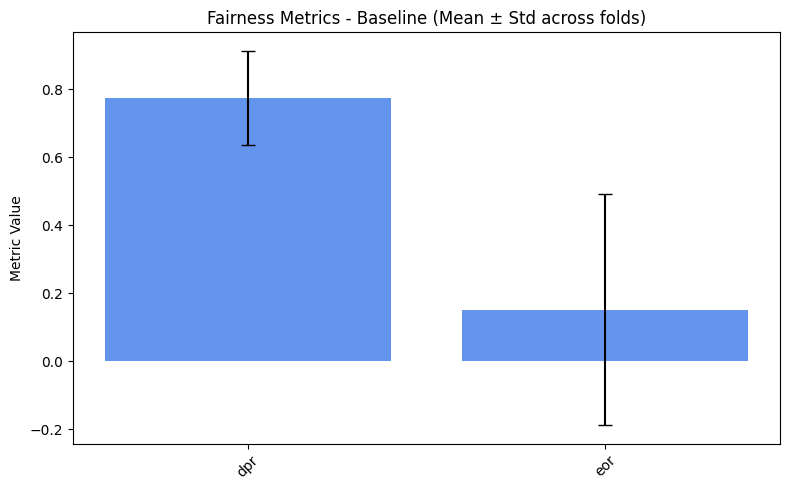

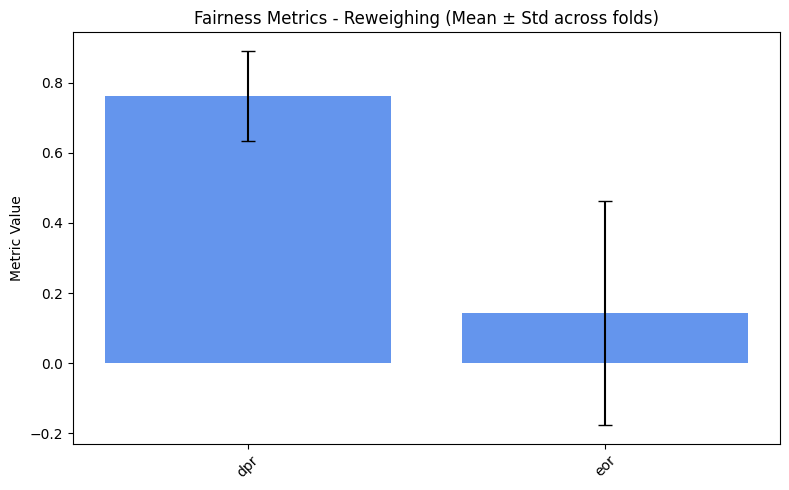

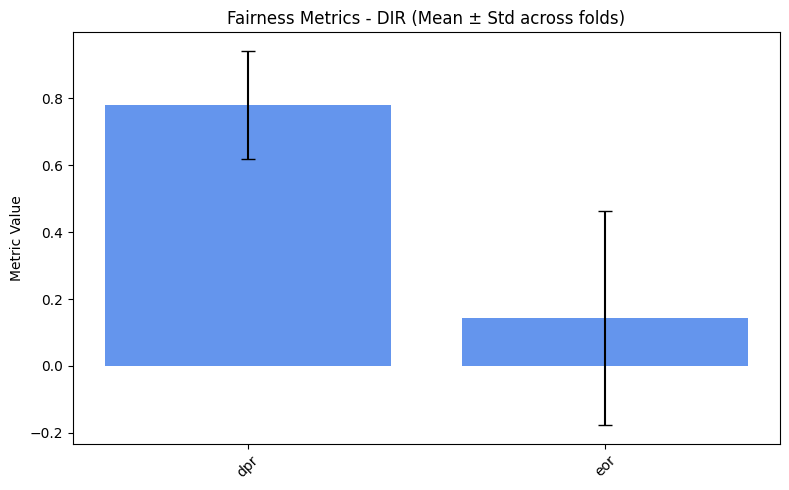

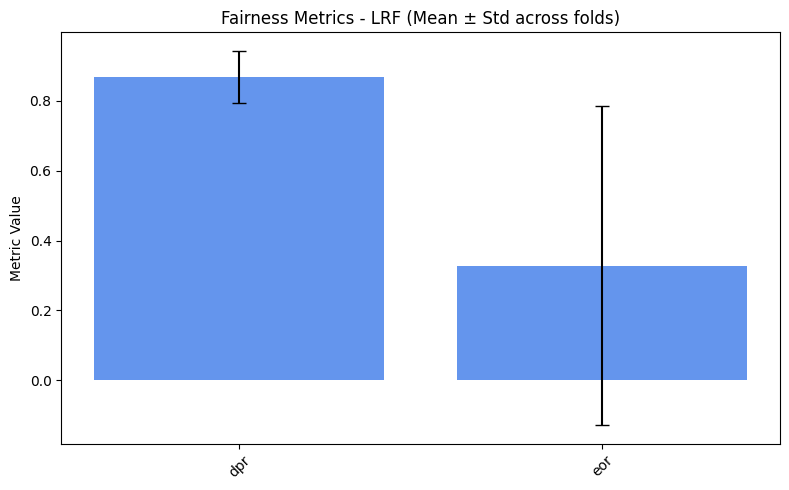

In [222]:
plot_metrics(fairness_values, preprocess_approaches, label="Fairness")

> We spot a really high variance. Why is that? Let's inspect the metrics for each fold. 

In [223]:
for approach in fairness_metrics:
    print(f"=== {approach} ===")
    for i, metrics in enumerate(fairness_metrics[approach]):
        print(f"  Fold {i+1}: {metrics}")
    print()

=== Baseline ===
  Fold 1: {'dpr': np.float64(0.7767857142857143), 'eor': 0.7589285714285715}
  Fold 2: {'dpr': np.float64(0.8586326767091541), 'eor': 0.0}
  Fold 3: {'dpr': np.float64(0.8579083837510804), 'eor': 0.0}
  Fold 4: {'dpr': np.float64(0.5344827586206897), 'eor': 0.0}
  Fold 5: {'dpr': np.float64(0.8451025056947609), 'eor': 0.0}

=== Reweighing ===
  Fold 1: {'dpr': np.float64(0.75), 'eor': 0.7142857142857143}
  Fold 2: {'dpr': np.float64(0.8586326767091541), 'eor': 0.0}
  Fold 3: {'dpr': np.float64(0.8067415730337079), 'eor': 0.0}
  Fold 4: {'dpr': np.float64(0.5462962962962963), 'eor': 0.0}
  Fold 5: {'dpr': np.float64(0.8485193621867881), 'eor': 0.0}

=== DIR ===
  Fold 1: {'dpr': np.float64(0.75), 'eor': 0.7142857142857143}
  Fold 2: {'dpr': np.float64(0.8922363847045192), 'eor': 0.0}
  Fold 3: {'dpr': np.float64(0.8680555555555556), 'eor': 0.0}
  Fold 4: {'dpr': np.float64(0.5086206896551724), 'eor': 0.0}
  Fold 5: {'dpr': np.float64(0.878132118451025), 'eor': 0.0}

===

> From the code above, we see that most folds output an EOR of 0. This occurs because the "Hired South Females" group is heavily under-represented, resulting in too few examples for this class in each fold. As a result, EOR metric cannot be computed reliably across all folds. This also explains the extremely high variance.
>> A more exhaustive explanation will be given in the next sections.

1.2) Performance metrics

In [109]:
performance_values = compute_metrics_dict(performance_metrics)
print_mean_values(performance_values) # Print the fairness values for each approach

=== Baseline ===
  accuracy: 0.6185
  precision: 0.6336
  recall: 0.8904
  auc: 0.6123

=== Reweighing ===
  accuracy: 0.6192
  precision: 0.6340
  recall: 0.8910
  auc: 0.6124

=== DIR ===
  accuracy: 0.6170
  precision: 0.6257
  recall: 0.9293
  auc: 0.5990

=== LRF ===
  accuracy: 0.6195
  precision: 0.6229
  recall: 0.9554
  auc: 0.5958



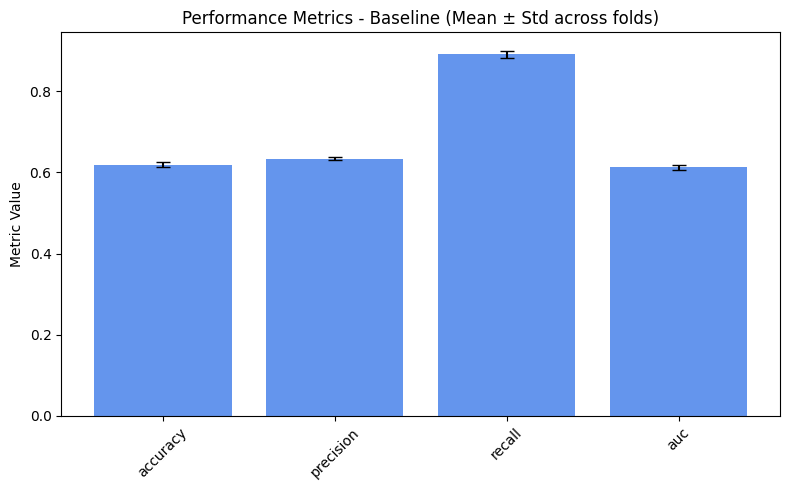

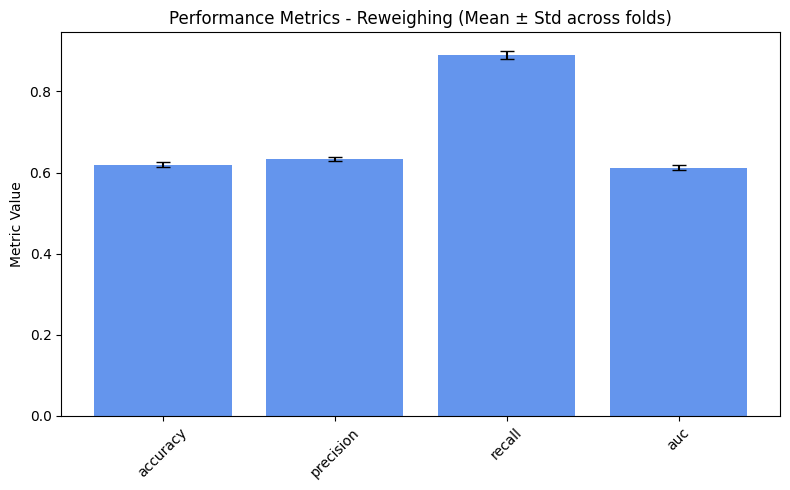

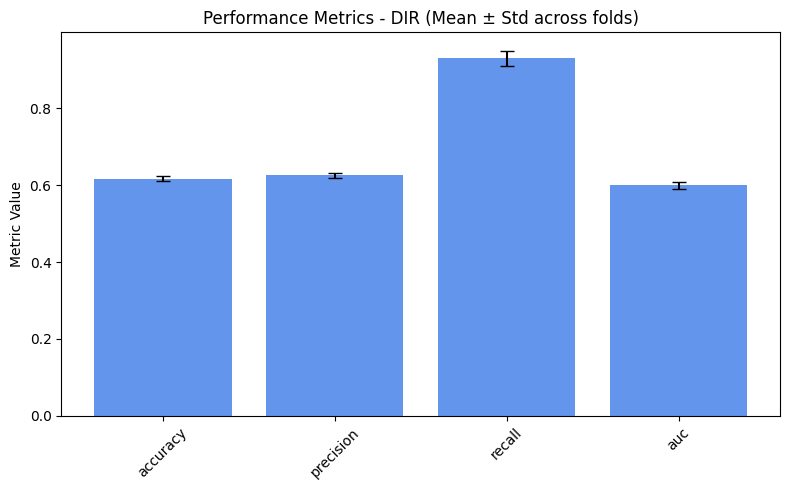

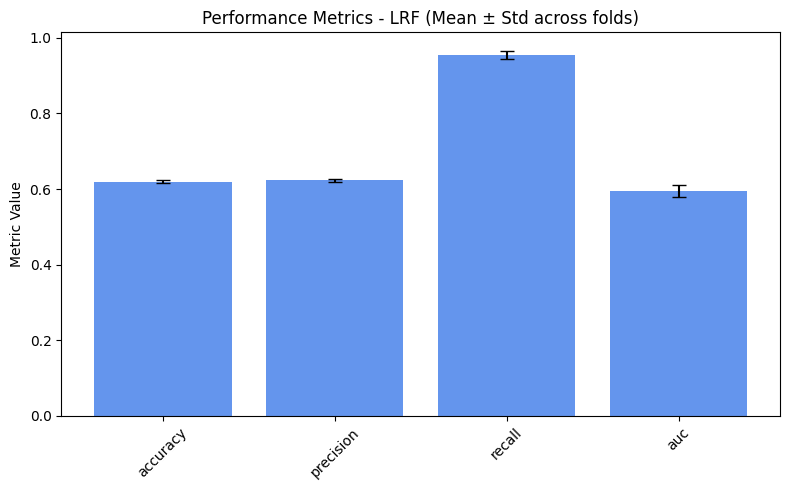

In [110]:
plot_metrics(performance_values, preprocess_approaches, label="Performance")

##### 2) Splitting on "target + sensitive" feature

In [224]:
performance_metrics, fairness_metrics, spd_values = skf_cross_validation(df1, target, sensitive_feature, split_type='target+sensitive')

c:\Users\follo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


2.1) Fairness metrics

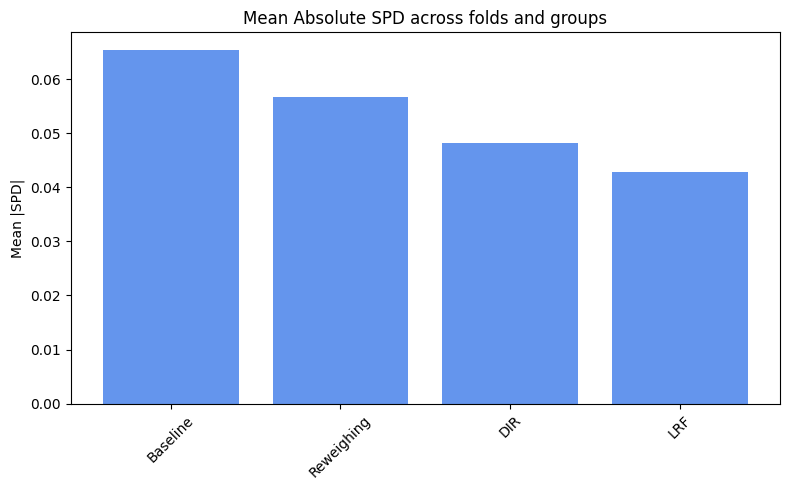

In [225]:
spd_results = compute_mean_spd(spd_values)
plot_spd_results(spd_results, label="Mean")

In [113]:
fairness_values = compute_metrics_dict(fairness_metrics)
print_mean_values(fairness_values) # Print the fairness values for each approach

=== Baseline ===
  dpr: 0.8156
  eor: 0.2787

=== Reweighing ===
  dpr: 0.8266
  eor: 0.3099

=== DIR ===
  dpr: 0.8547
  eor: 0.3382

=== LRF ===
  dpr: 0.6389
  eor: 0.2591



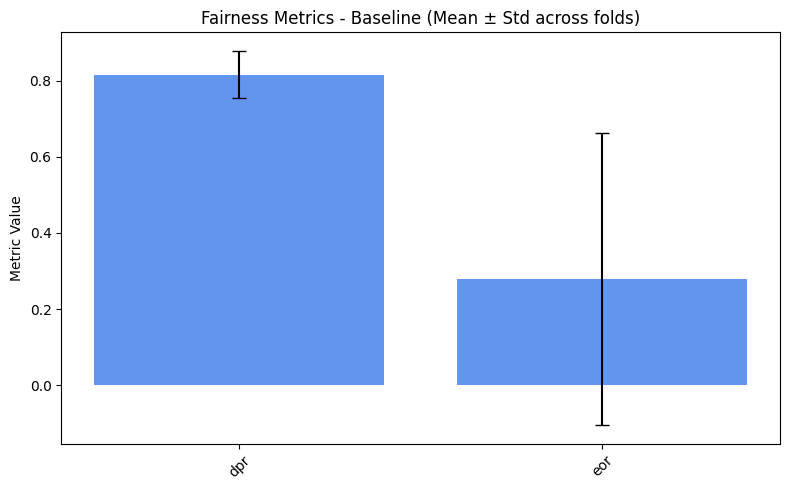

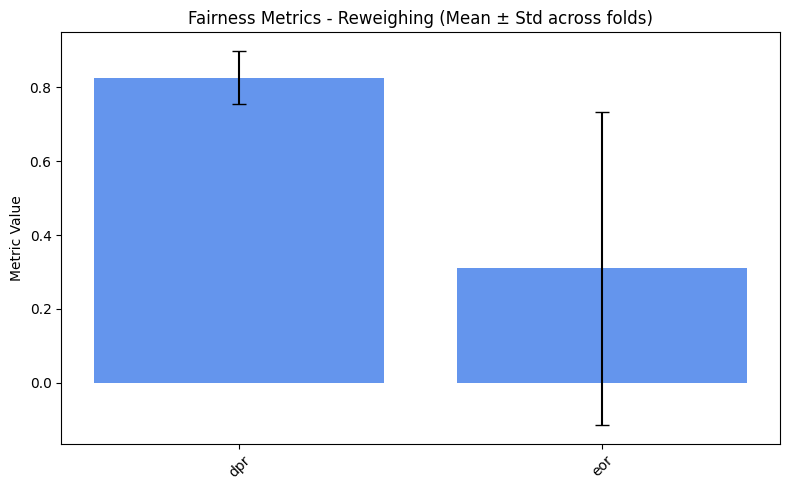

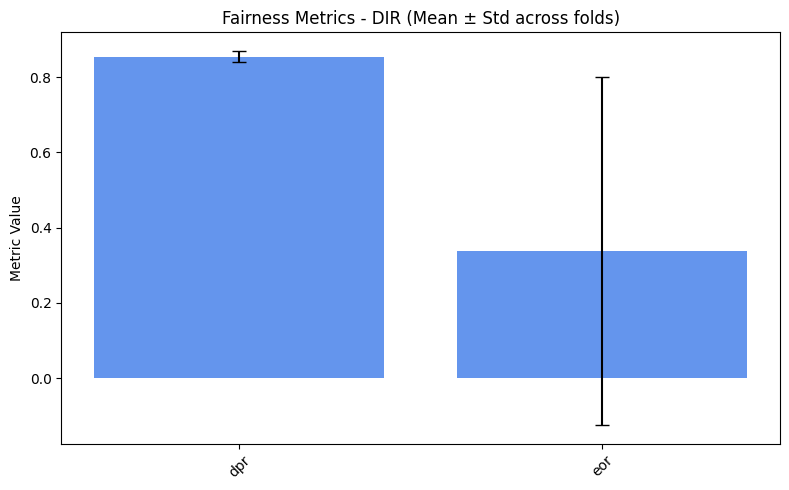

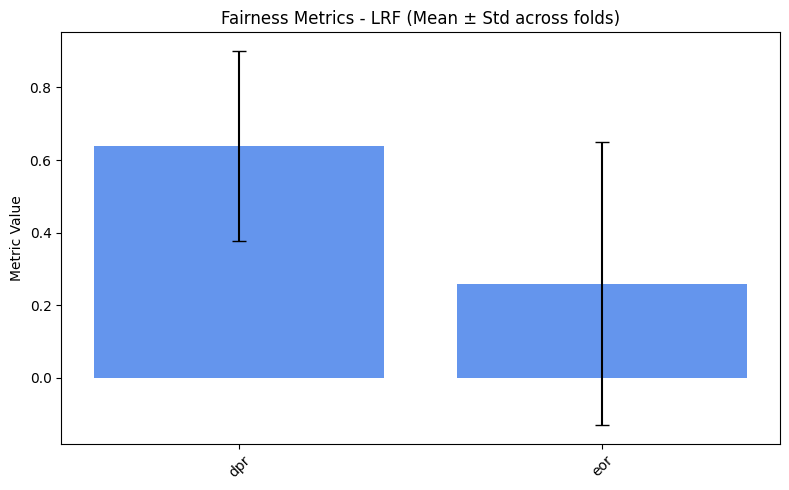

In [114]:
plot_metrics(fairness_values, preprocess_approaches, label="Fairness")

> We can clearly see that the second protocol leads to better fairness metrics. Specifically, SPD is lower, while EOR and DPR are higher. This is because stratifying on the target + sensitive combination ensures a slightly more balanced representation of all groups and labels in each fold, making the evaluation of fairness metrics more reliable and stable.

2.2) Performance metrics

In [115]:
performance_values = compute_metrics_dict(performance_metrics)
print_mean_values(performance_values) # Print the fairness values for each approach

=== Baseline ===
  accuracy: 0.6185
  precision: 0.6334
  recall: 0.8908
  auc: 0.6117

=== Reweighing ===
  accuracy: 0.6190
  precision: 0.6337
  recall: 0.8912
  auc: 0.6116

=== DIR ===
  accuracy: 0.6127
  precision: 0.6246
  recall: 0.9164
  auc: 0.5997

=== LRF ===
  accuracy: 0.6182
  precision: 0.6217
  recall: 0.9575
  auc: 0.5889



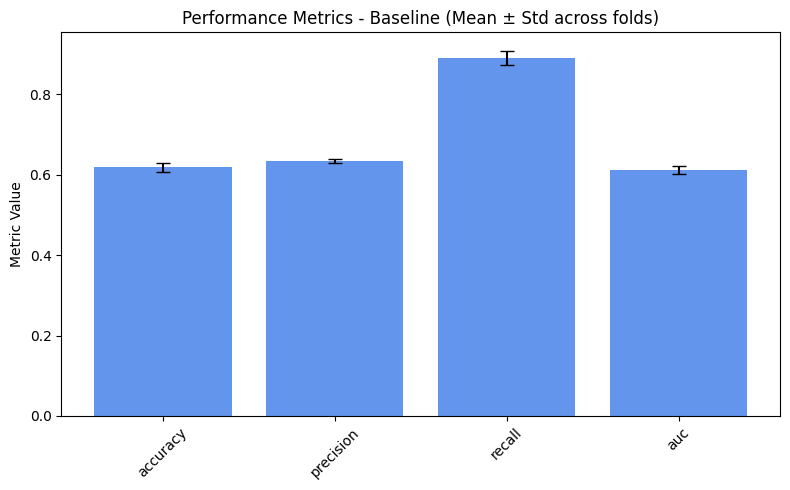

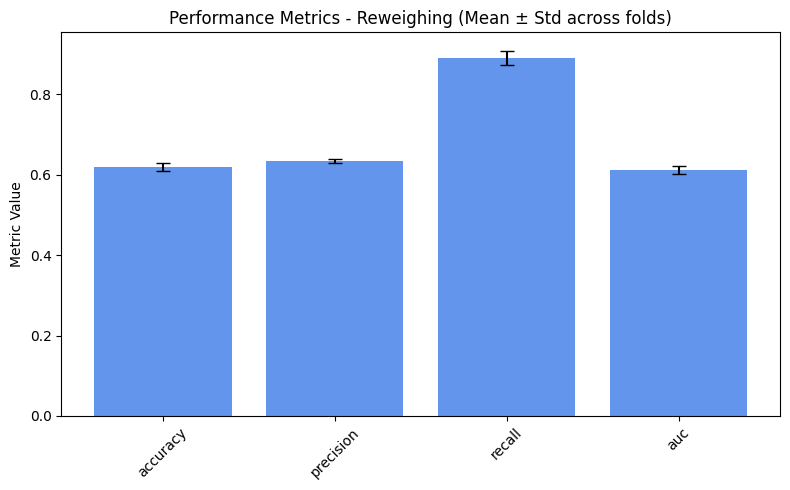

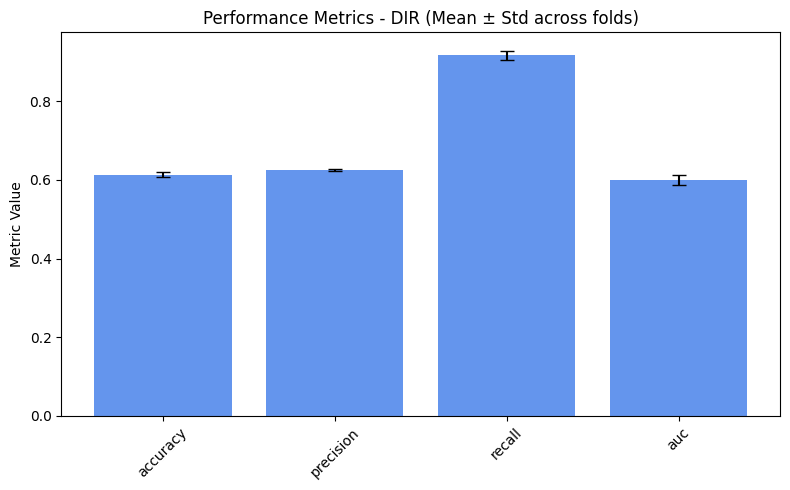

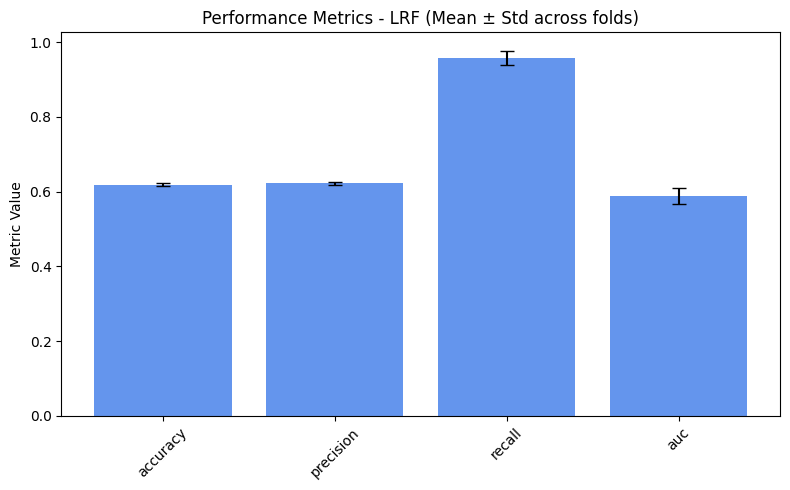

In [116]:
plot_metrics(performance_values, preprocess_approaches, label="Performance")

#### Data rebalancing: checking the robustness of our pipeline
The dataset is imbalanced, which prevents us from obtaining meaningful results even when following a correct pipeline. To ensure that each fold contains at least one example from underrepresented (unfair) groups, we artificially augment the data. This allows us to test whether our approach remains valid and robust under these conditions.

In [321]:
print(df1.groupby([target, sensitive_feature]).size())

hired  grouped_regions
0      0.0                 152
       1.0                 155
       2.0                1235
       3.0                1705
       4.0                  31
       5.0                  39
1      0.0                 272
       1.0                 141
       2.0                2100
       3.0                2645
       4.0                   2
       5.0                  43
dtype: int64


In [ ]:
# Sampling under-represented classes
pos = df1[(df1[sensitive_feature] == 4) & df1[target] == 1].copy()

for i in range(6):
    df1.loc[-1] = pos.sample().iloc[0]      
    df1.index = df1.index + 1 
    df1 = df1.sort_index() 

1.03.0    2645
1.02.0    2100
0.03.0    1705
0.02.0    1235
1.00.0     272
0.01.0     155
0.00.0     152
1.01.0     141
1.05.0      43
0.05.0      39
0.04.0      31
1.04.0       8
Name: count, dtype: int64

In [226]:
print(df1.groupby([target, sensitive_feature]).size())

hired  grouped_regions
0      0.0                 152
       1.0                 155
       2.0                1235
       3.0                1705
       4.0                  31
       5.0                  39
1      0.0                 272
       1.0                 141
       2.0                2100
       3.0                2645
       4.0                   2
       5.0                  43
dtype: int64


As we can see, the number of examples for "hired south females" has increased to 8. This makes the k-fold split feasible, and we can now expect more reliable results. We will perform the split using the "target + sensitive" feature combination.

In [119]:
performance_metrics, fairness_metrics, spd_values = skf_cross_validation(df1, target, sensitive_feature, split_type='target')

##### Fairness metrics

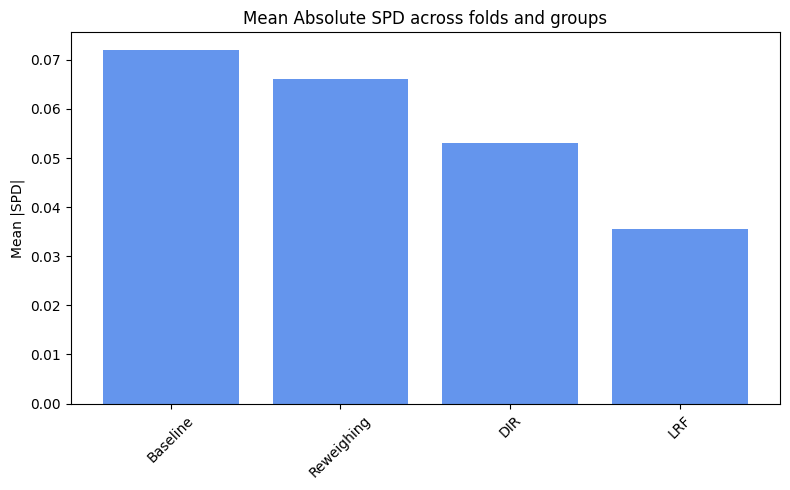

In [120]:
spd_results = compute_mean_spd(spd_values)
plot_spd_results(spd_results, label="Mean")

In [121]:
fairness_values = compute_metrics_dict(fairness_metrics)
print_mean_values(fairness_values) # Print the fairness values for each approach

=== Baseline ===
  dpr: 0.7957
  eor: 0.5959

=== Reweighing ===
  dpr: 0.7932
  eor: 0.5983

=== DIR ===
  dpr: 0.8381
  eor: 0.6207

=== LRF ===
  dpr: 0.8931
  eor: 0.6129



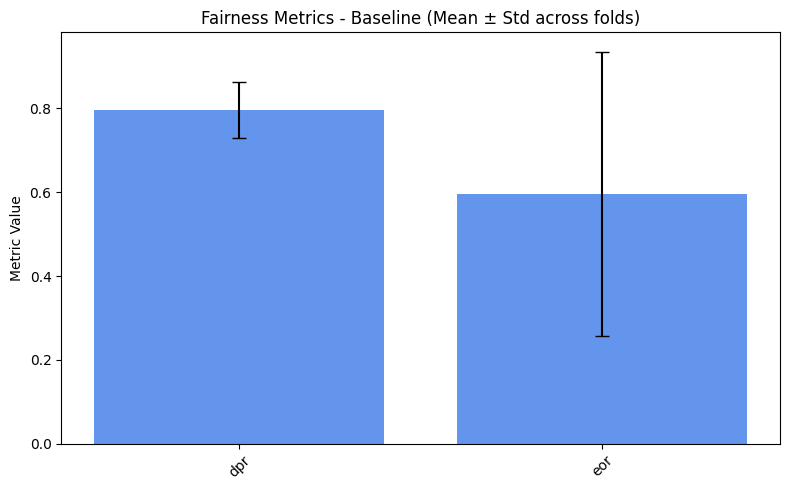

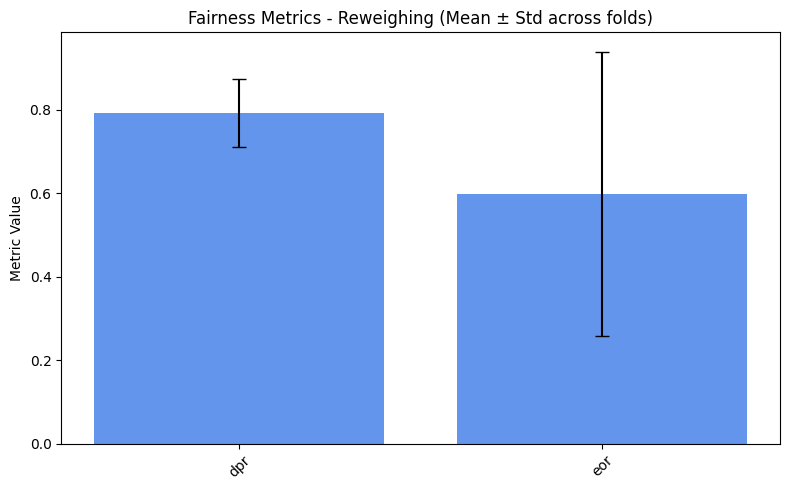

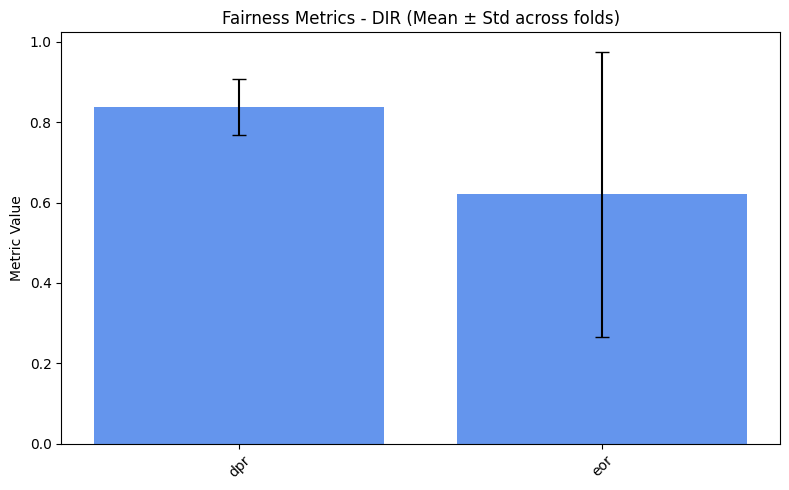

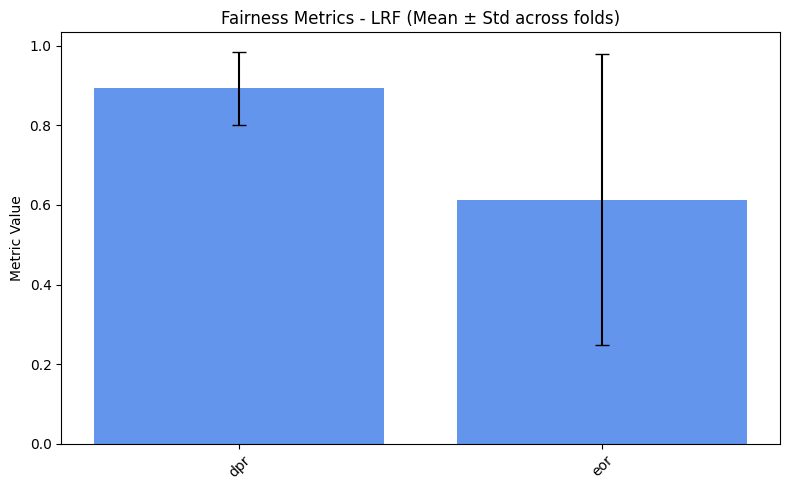

In [122]:
plot_metrics(fairness_values, preprocess_approaches, label="Fairness")

##### Performance metrics

In [123]:
performance_values = compute_metrics_dict(performance_metrics)
print_mean_values(performance_values) # Print the fairness values for each approach

=== Baseline ===
  accuracy: 0.6188
  precision: 0.6335
  recall: 0.8921
  auc: 0.6130

=== Reweighing ===
  accuracy: 0.6194
  precision: 0.6337
  recall: 0.8935
  auc: 0.6131

=== DIR ===
  accuracy: 0.6158
  precision: 0.6250
  recall: 0.9292
  auc: 0.5987

=== LRF ===
  accuracy: 0.6141
  precision: 0.6159
  recall: 0.9798
  auc: 0.5981



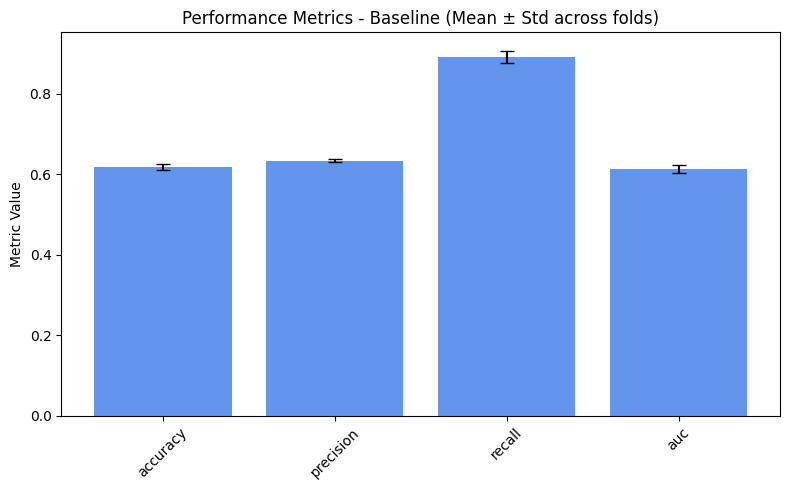

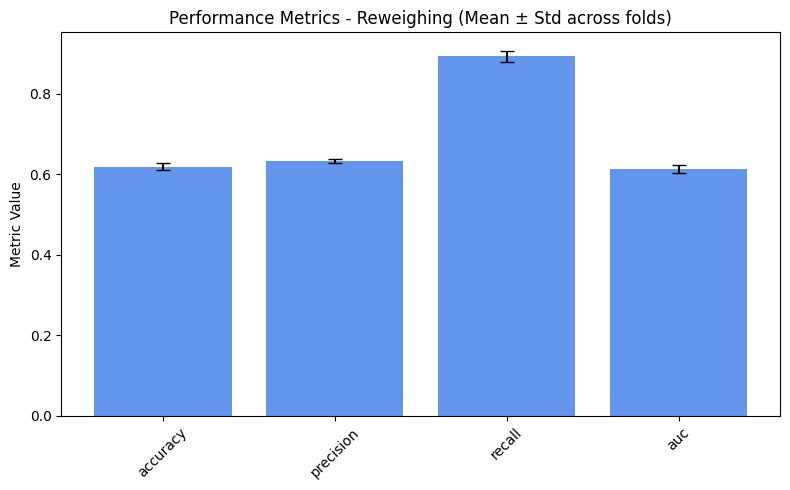

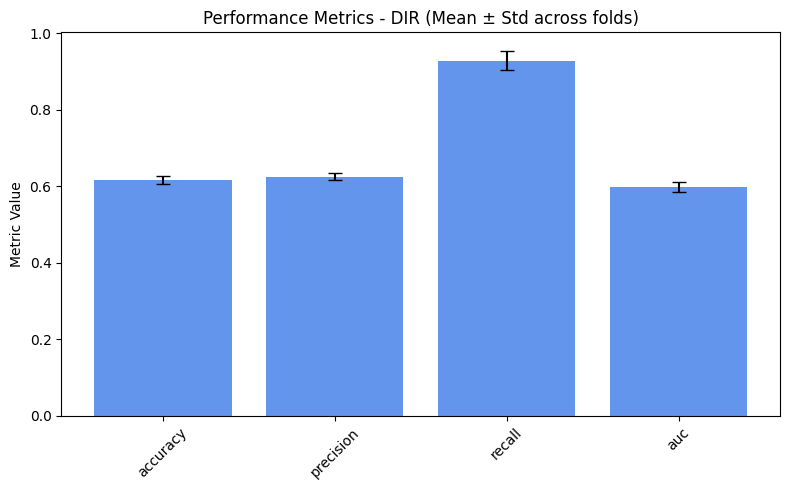

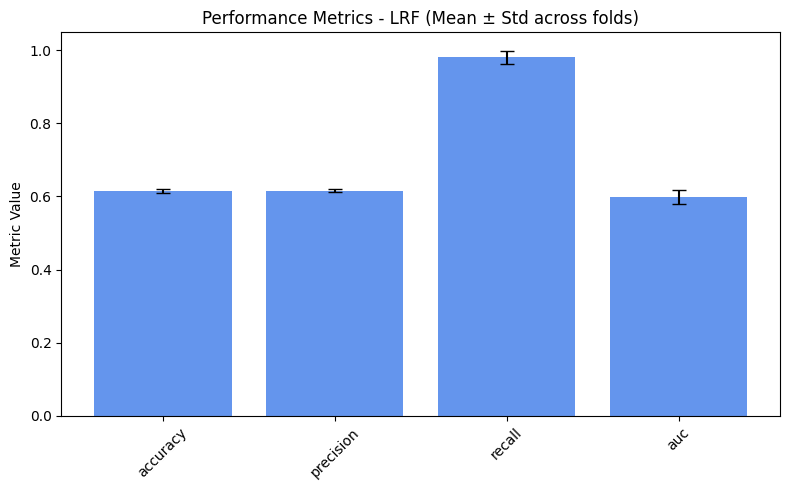

In [124]:
plot_metrics(performance_values, preprocess_approaches, label="Performance")

##### Considerations
As expected, we obtain slightly better results for the fairness metrics. The improvement is especially noticeable for DPR and EOR, which now show reasonable variance and effectively increase compared to the baseline.

In [101]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

In [102]:
X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
numerical_cols = ['distance_km', 'cand_domicile_province', 'cand_education', 'job_professional_category', 'job_sector', 'job_work_province']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


In [103]:
X_train_dataframe = fl.DataFrame(X_train.copy())
X_train_dataframe.sensitive = sensitive_feature

baseline_model = AdversarialDebiasing(
    input_dim=X_train.shape[1],
    hidden_dim=8,
    output_dim=1,
    sensitive_dim=1,
    lambda_adv=0,  
)

baseline_model.fit(X_train, y_train)

X_test_dataframe = fl.DataFrame(X_test.copy())
X_test_dataframe.sensitive = sensitive_feature

y_pred_tensor = baseline_model.predict(X_test)
y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
y_pred_labels = (y_pred > 0.5).astype(int)

y_proba = y_pred  
perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
baseline_performance_metrics.append(perf_metrics)

# Fairness metrics
fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])
baseline_fairness_metrics.append(fair_metrics)

# SPD aggiuntivo (usando metodo fairlib)
spd = evaluate_spd(X_test.copy(), y_pred_labels)
baseline_spd_val = sum(abs(v) for v in spd.values()) / len(spd)
print(f"Baseline SPD (AdversarialDebiasing λ=0): {spd}")

Baseline SPD (AdversarialDebiasing λ=0): {(hired=0, grouped_regions=0.0): -0.0646026772453311, (hired=0, grouped_regions=1.0): -0.051445249976461715, (hired=0, grouped_regions=2.0): -0.06738347917830323, (hired=0, grouped_regions=3.0): 0.07855362819355599, (hired=0, grouped_regions=4.0): -0.03485960881017766, (hired=0, grouped_regions=5.0): 0.141780871062639, (hired=1, grouped_regions=0.0): 0.06460267724533109, (hired=1, grouped_regions=1.0): 0.051445249976461715, (hired=1, grouped_regions=2.0): 0.06738347917830323, (hired=1, grouped_regions=3.0): -0.07855362819355605, (hired=1, grouped_regions=4.0): 0.03485960881017758, (hired=1, grouped_regions=5.0): -0.14178087106263904}


In [104]:
adv_weights = [0.1, 0.5, 1.0]
adv_spds = []
for lam in adv_weights:
    print(f"\n== Adversarial Debiasing con lambda_adv={lam} ==")

    # Prepara fairlib dataframe
    X_tr = fl.DataFrame(X_train.copy())
    X_tr.sensitive = sensitive_feature

    X_te = fl.DataFrame(X_test.copy())
    X_te.sensitive = sensitive_feature

    # Modello Adversarial Debiasing
    model = AdversarialDebiasing(
        input_dim=X_train.shape[1],
        hidden_dim=8,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=lam,
    )

    # Addestramento
    model.fit(X_train, y_train)

    # Predizione
    y_pred_tensor = model.predict(X_test)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_labels = (y_pred > 0.5).astype(int)
    y_proba = y_pred

    # Performance
    perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
    inprocessing_performance_metrics.append(perf_metrics)

    # Fairness
    fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])
    inprocessing_fairness_metrics.append(fair_metrics)

    # SPD extra
    spd = evaluate_spd(X_test.copy(), y_pred_labels)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)
    adv_spds.append(spd_val)
    print(f"SPD (λ={lam}): {spd}")


== Adversarial Debiasing con lambda_adv=0.1 ==
SPD (λ=0.1): {(hired=0, grouped_regions=0.0): -0.00041203131437989287, (hired=0, grouped_regions=1.0): -0.0004048582995951417, (hired=0, grouped_regions=2.0): -0.0006361323155216285, (hired=0, grouped_regions=3.0): 0.0007530120481927711, (hired=0, grouped_regions=4.0): -0.00039231071008238524, (hired=0, grouped_regions=5.0): -0.0003946329913180742, (hired=1, grouped_regions=0.0): 0.0004120313143799459, (hired=1, grouped_regions=1.0): 0.0004048582995951344, (hired=1, grouped_regions=2.0): 0.0006361323155216203, (hired=1, grouped_regions=3.0): -0.0007530120481927804, (hired=1, grouped_regions=4.0): 0.0003923107100823886, (hired=1, grouped_regions=5.0): 0.00039463299131803353}

== Adversarial Debiasing con lambda_adv=0.5 ==
SPD (λ=0.5): {(hired=0, grouped_regions=0.0): 0.01295503109399105, (hired=0, grouped_regions=1.0): -0.011336032388663968, (hired=0, grouped_regions=2.0): 0.00697418233724322, (hired=0, grouped_regions=3.0): -0.00712785997

### In-Processing

In [95]:
sensitive_feature = 'grouped_regions'
target = df1.targets.pop()

In [96]:
def compute_performance_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_proba)
    }

In [97]:
def compute_fairness_metrics(y_true, y_pred, sensitive_features):
    return {
        'dpr': demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features),
        'eor': equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    }

In [98]:
def evaluate_spd(X_test, y_pred):
    X_test_copy = X_test.copy()
    X_test_copy[target] = y_pred
    dataset = fl.DataFrame(X_test_copy)
    dataset.targets = target
    dataset.sensitive = sensitive_feature

    spd = dataset.statistical_parity_difference()
    return spd

In [99]:
def metrics_bar_plot(dict1, dict2, label1, label2, metrics, title="Metric Comparison (mean ± std)"):
    def summarise(metric_dict):
        means = []
        stds = []
        for m in metrics:
            values = metric_dict.get(m, [])
            mean_val = np.nanmean(values)
            std_val = np.nanstd(values)
            means.append(mean_val)
            stds.append(std_val)
        return np.array(means), np.array(stds)

    mean1, std1 = summarise(dict1)
    mean2, std2 = summarise(dict2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for ax, mean, std, label in zip(axes, [mean1, mean2], [std1, std2], [label1, label2]):
        ax.bar(metrics, mean, yerr=std, capsize=4)
        ax.set_title(label)
        ax.set_ylim(0, 1.2)  
        ax.grid(axis="y", alpha=0.3)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [100]:
class Simple_NN(nn.Module):
    def __init__(self, input_dim: int, return_representation: bool = False):
        super(Simple_NN, self).__init__()
        self.return_representation = return_representation

        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.bn1(x)
        x = self.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dropout(x)
        rep = self.relu(self.fc2(x))
        rep = self.bn3(rep)
        rep = self.dropout(rep)
        out = self.fc3(rep)  

        if self.return_representation:
            return self.sigmoid(out), rep  
        else:
            return self.sigmoid(out) 

In [104]:
def aggregate_metrics(metric_list):
    metrics_dict = {}
    for fold_metrics in metric_list:
        for key, value in fold_metrics.items():
            if key not in metrics_dict:
                metrics_dict[key] = []
            metrics_dict[key].append(value)
    return metrics_dict

#### 1) Adversarial Debiasing

In [ ]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])



##### Baseline

In [ ]:
from fairlib.inprocessing import AdversarialDebiasing

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, df1[sensitive_feature].astype(str))):
    print(f"\nFold {fold + 1}/{k}")

    # Suddivisione in training e test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    sensitive_train = X.iloc[train_index][sensitive_feature]
    sensitive_test = X.iloc[test_index][sensitive_feature]

    # Aggiungi la colonna 'sensitive' per fairlib
    X_train_copy = X_train.copy()
    X_train_copy["sensitive"] = sensitive_train.values
    X_train_dataframe = fl.DataFrame(X_train_copy)
    X_train_dataframe.sensitive = "sensitive"

    X_test_copy = X_test.copy()
    X_test_copy["sensitive"] = sensitive_test.values
    X_test_dataframe = fl.DataFrame(X_test_copy)
    X_test_dataframe.sensitive = "sensitive"

    # Modello AdversarialDebiasing
    baseline_model = AdversarialDebiasing(
        input_dim=X_train.shape[1],
        hidden_dim=8,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=0,  
    )

    # Training
    baseline_model.fit(X_train, y_train)

    # Prediction
    y_pred_tensor = baseline_model.predict(X_test)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_labels = (y_pred > 0.5).astype(int)
    y_proba = y_pred

    # Performance metrics
    perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
    baseline_performance_metrics.append(perf_metrics)

    # Fairness metrics
    fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, sensitive_test)
    baseline_fairness_metrics.append(fair_metrics)

    # SPD evaluation
    spd = evaluate_spd(X_test.copy(), y_pred_labels)
    baseline_spd_val = sum(abs(v) for v in spd.values()) / len(spd)

    print(f"SPD Fold {fold + 1}: {spd}")



Fold 1/5
SPD Fold 1: {(hired=0, grouped_regions=0.0): 0.04162708833882772, (hired=0, grouped_regions=1.0): 0.11578748900155028, (hired=0, grouped_regions=2.0): -0.09149740728688097, (hired=0, grouped_regions=3.0): 0.06439560923999296, (hired=0, grouped_regions=4.0): 0.14268867924528303, (hired=0, grouped_regions=5.0): -0.033175914994096806, (hired=1, grouped_regions=0.0): -0.04162708833882767, (hired=1, grouped_regions=1.0): -0.11578748900155023, (hired=1, grouped_regions=2.0): 0.09149740728688105, (hired=1, grouped_regions=3.0): -0.06439560923999299, (hired=1, grouped_regions=4.0): -0.14268867924528306, (hired=1, grouped_regions=5.0): 0.03317591499409689}

Fold 2/5
SPD Fold 2: {(hired=0, grouped_regions=0.0): -0.1717296962182269, (hired=0, grouped_regions=1.0): -0.16686746987951806, (hired=0, grouped_regions=2.0): -0.060912891835098903, (hired=0, grouped_regions=3.0): 0.08619242941760828, (hired=0, grouped_regions=4.0): 0.4768834237233528, (hired=0, grouped_regions=5.0): 0.1864399009

##### With different adversary weights

In [ ]:
# In-processing con Adversarial Debiasing su diversi lambda_adv
adv_weights = [0.1, 0.5, 1.0]
adv_spds = []

for i, lam in enumerate(adv_weights):
    print(f"\n== Adversarial Debiasing con lambda_adv={lam} ==")

    # Crea liste per ciascun lambda
    perf_list = []
    fair_list = []
    spd_list = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[sensitive_feature].astype(str))):
        print(f"\nFold {fold + 1}/{k} - lambda_adv={lam}")

        # Split dei dati
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        sensitive_train = X.iloc[train_index][sensitive_feature]
        sensitive_test = X.iloc[test_index][sensitive_feature]

        # Prepara fairlib dataframe
        X_train_copy = X_train.copy()
        X_train_copy["sensitive"] = sensitive_train.values
        X_tr = fl.DataFrame(X_train_copy)
        X_tr.sensitive = "sensitive"

        X_test_copy = X_test.copy()
        X_test_copy["sensitive"] = sensitive_test.values
        X_te = fl.DataFrame(X_test_copy)
        X_te.sensitive = "sensitive"

        # Modello Adversarial Debiasing
        model = AdversarialDebiasing(
            input_dim=X_train.shape[1],
            hidden_dim=8,
            output_dim=1,
            sensitive_dim=1,
            lambda_adv=lam,
        )

        # Addestramento
        model.fit(X_train, y_train)

        # Predizione
        y_pred_tensor = model.predict(X_test)
        y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
        y_pred_labels = (y_pred > 0.5).astype(int)
        y_proba = y_pred

        # Performance
        perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
        perf_list.append(perf_metrics)

        # Fairness
        fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, sensitive_test)
        fair_list.append(fair_metrics)

        # SPD
        spd = evaluate_spd(X_test.copy(), y_pred_labels)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)
        spd_list.append(spd_val)

        print(f"SPD Fold {fold + 1} (λ={lam}): {spd}")

    # Salva i risultati complessivi del lambda
    inprocessing_performance_metrics.append(perf_list)
    inprocessing_fairness_metrics.append(fair_list)
    adv_spds.append(spd_list)


== Adversarial Debiasing con lambda_adv=0.1 ==

Fold 1/5 - lambda_adv=0.1
SPD Fold 1 (λ=0.1): {(hired=0, grouped_regions=0.0): 0.06618826778630098, (hired=0, grouped_regions=1.0): -0.03796036368207148, (hired=0, grouped_regions=2.0): 0.011476432529064107, (hired=0, grouped_regions=3.0): -0.013092928936695461, (hired=0, grouped_regions=4.0): -0.10613207547169812, (hired=0, grouped_regions=5.0): -0.10625737898465171, (hired=1, grouped_regions=0.0): -0.06618826778630094, (hired=1, grouped_regions=1.0): 0.03796036368207145, (hired=1, grouped_regions=2.0): -0.011476432529064051, (hired=1, grouped_regions=3.0): 0.013092928936695447, (hired=1, grouped_regions=4.0): 0.10613207547169812, (hired=1, grouped_regions=5.0): 0.10625737898465171}

Fold 2/5 - lambda_adv=0.1
SPD Fold 2 (λ=0.1): {(hired=0, grouped_regions=0.0): -0.06002738736774694, (hired=0, grouped_regions=1.0): -0.06883899233296822, (hired=0, grouped_regions=2.0): -0.007551829466432708, (hired=0, grouped_regions=3.0): 0.0317243583826

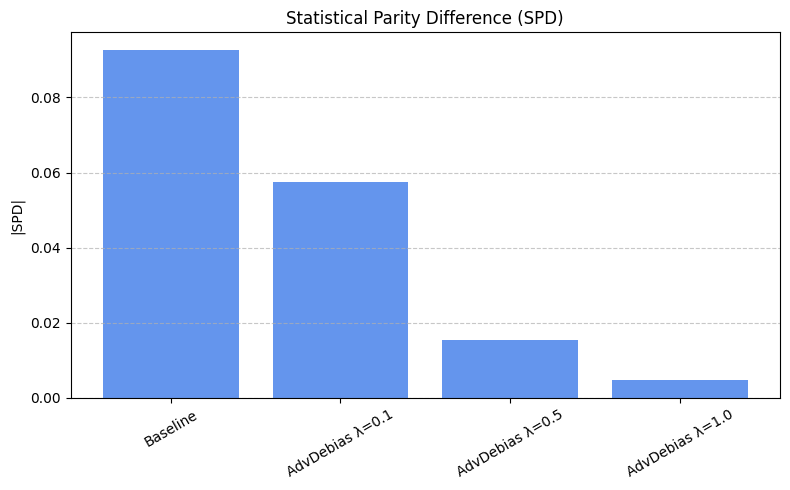

In [ ]:
model_names = ['Baseline'] + [f'AdvDebias λ={lam}' for lam in adv_weights]

# Calcola la media degli SPD per ogni lambda
mean_adv_spds = [np.mean(spd_list) for spd_list in adv_spds]
spds = [baseline_spd_val] + mean_adv_spds

results = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

# Plot a barre
plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['SPD'], color='cornflowerblue')
plt.title('Statistical Parity Difference (SPD)')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


== Bar plot per λ = 0.1 ==


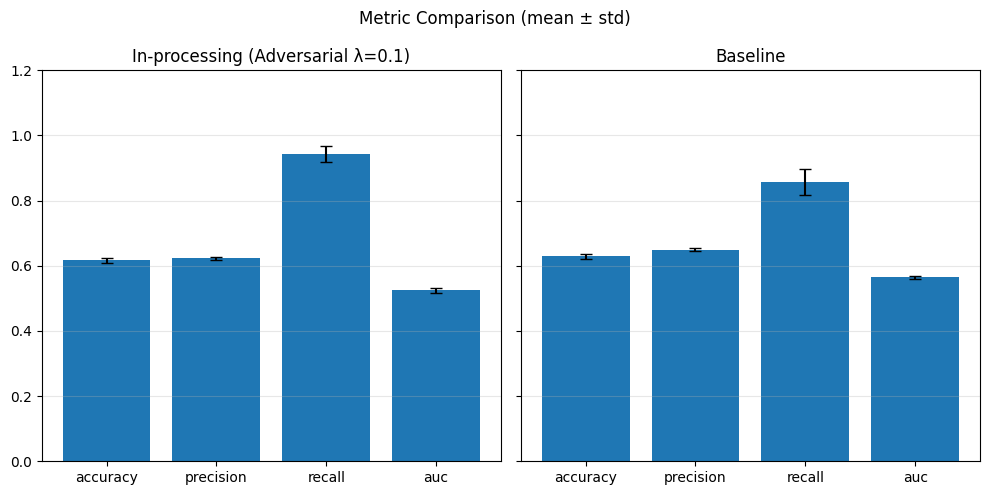

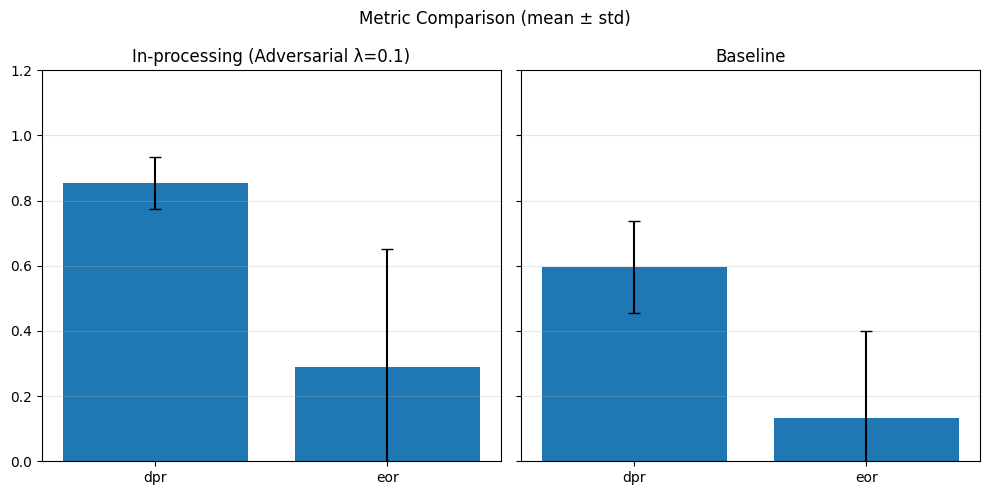

== Bar plot per λ = 0.5 ==


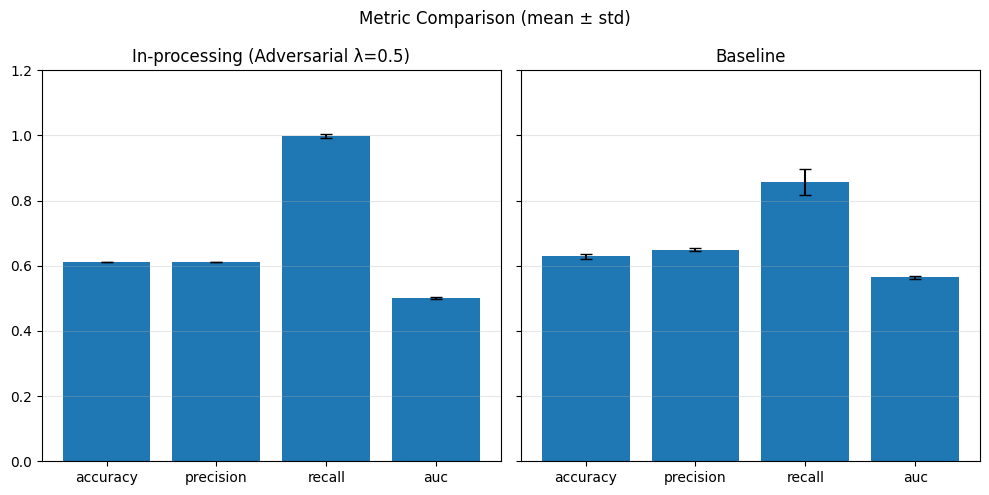

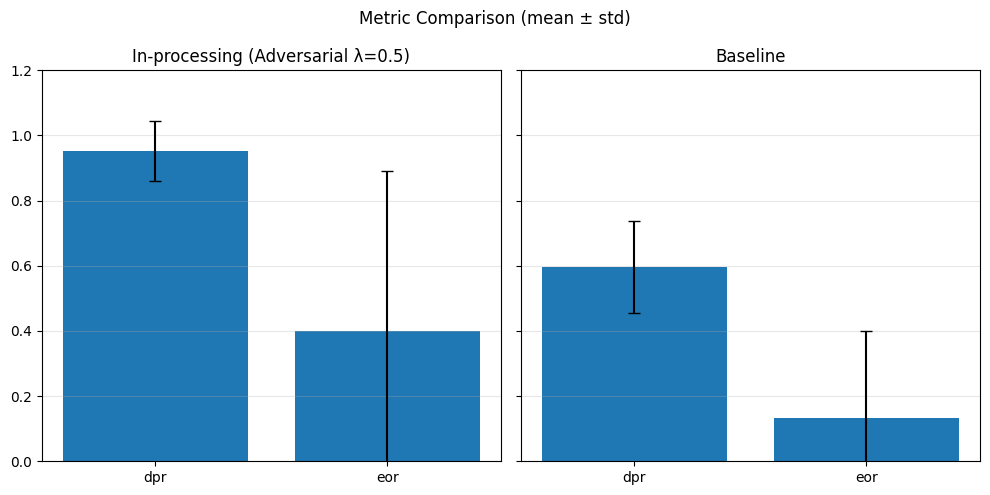

== Bar plot per λ = 1.0 ==


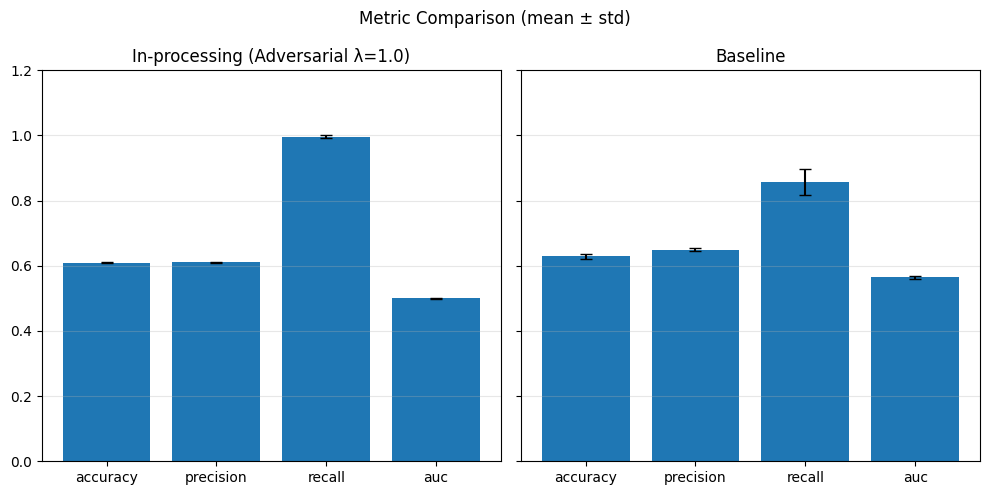

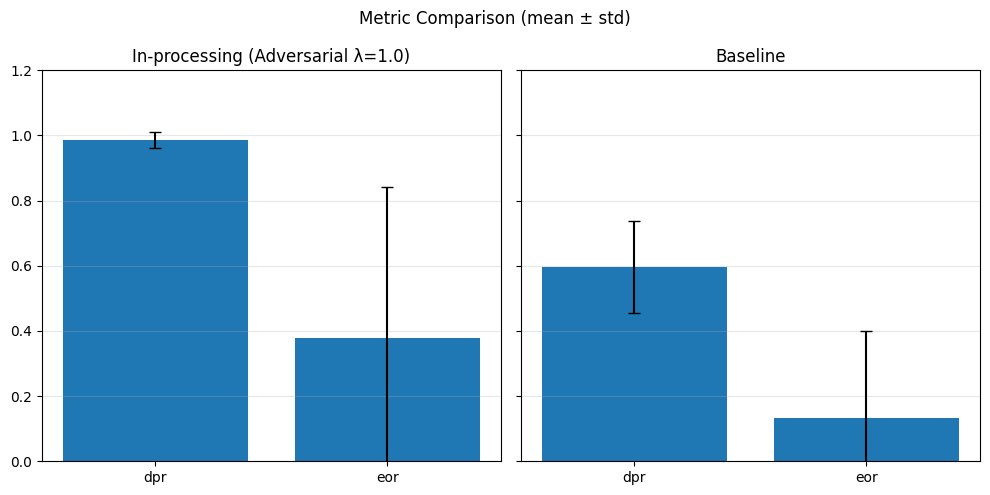

In [ ]:
for i, lam in enumerate(adv_weights):
    print(f"== Bar plot per λ = {lam} ==")

    # Performance
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (Adversarial λ={lam})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (Adversarial λ={lam})",
        "Baseline",
        ["dpr", "eor"]
    )

Adversarial Debiasing demonstrated a notably positive impact on fairness metrics, with substantial improvements in both Equalized Odds Ratio (EOR) and—most significantly—Demographic Parity Ratio (DPR).

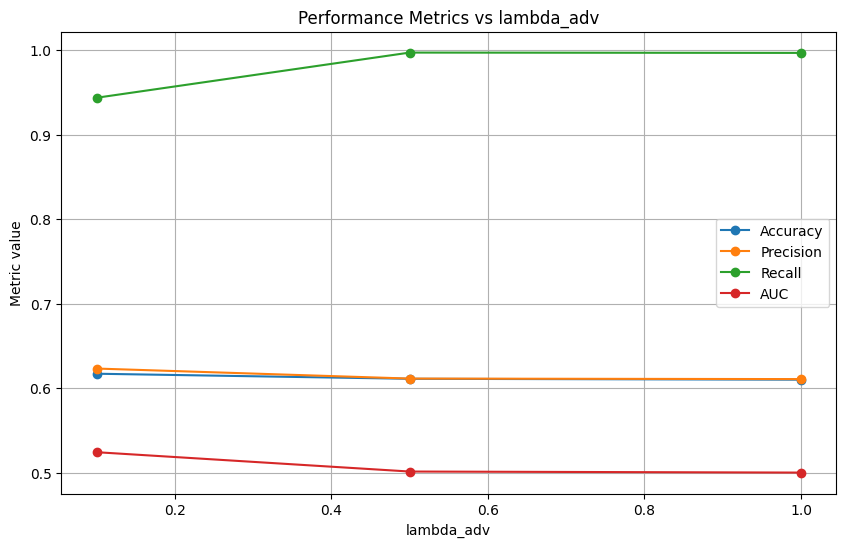

In [ ]:
lambda_vals = [0.1, 0.5, 1.0]

accuracies = []
precisions = []
recalls = []
aucs = []

for metrics_list in inprocessing_performance_metrics:
    aggregated = aggregate_metrics(metrics_list)
    accuracies.append(np.mean(aggregated['accuracy']))
    precisions.append(np.mean(aggregated['precision']))
    recalls.append(np.mean(aggregated['recall']))
    aucs.append(np.mean(aggregated['auc']))

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, accuracies, marker='o', label='Accuracy')
plt.plot(lambda_vals, precisions, marker='o', label='Precision')
plt.plot(lambda_vals, recalls, marker='o', label='Recall')
plt.plot(lambda_vals, aucs, marker='o', label='AUC')
plt.xlabel('lambda_adv')
plt.ylabel('Metric value')
plt.title('Performance Metrics vs lambda_adv')
plt.legend()
plt.grid(True)
plt.show()


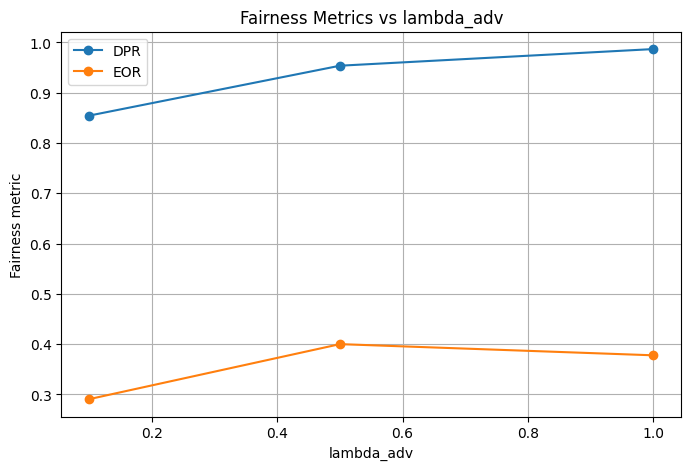

In [ ]:
dprs = []
eors = []

for metrics_list in inprocessing_fairness_metrics:
    aggregated = aggregate_metrics(metrics_list)
    dprs.append(np.mean(aggregated['dpr']))
    eors.append(np.mean(aggregated['eor']))


plt.figure(figsize=(8, 5))
plt.plot(lambda_vals, dprs, marker='o', label='DPR')
plt.plot(lambda_vals, eors, marker='o', label='EOR')
plt.xlabel('lambda_adv')
plt.ylabel('Fairness metric')
plt.title('Fairness Metrics vs lambda_adv')
plt.legend()
plt.grid(True)
plt.show()


Here we can see that the bigger weight lambda give the better result in terms of fairness

#### 2) FaUCI

In [ ]:
k = 5  
reg_weights = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs = 100
batch_size = 128
fauci_spd_vals = []

baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in reg_weights if _ != 0.0]
inprocessing_fairness_metrics = [[] for _ in reg_weights if _ != 0.0]


X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, weight in enumerate(reg_weights):
    print(f"\n== FaUCI training with regularization weight: {weight} ==")
    fold_spds = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[sensitive_feature].astype(str))):
        print(f"  Fold {fold + 1}/{k}")

        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]

        input_dim = X.shape[1]
        X_test_tensor = torch.tensor(X_test_fold.values, dtype=torch.float32)

        model = Simple_NN(input_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        fauci_model = fl.Fauci(
            torchModel=model,
            optimizer=optimizer,
            loss=nn.BCELoss(),
            fairness_regularization="spd",
            regularization_weight=weight
        )

        # Prepara dati fairlib
        train_data = fl.DataFrame(X_train_fold)
        train_data[target] = y_train_fold.values
        train_data.targets = target
        train_data.sensitive = sensitive_feature

        # Fit
        fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

        # Predict
        model.eval()
        with torch.no_grad():
            y_pred_tensor = fauci_model.predict(X_test_tensor)
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_pred_labels = (y_pred > 0.5).astype(int)

        # Metrics
        perf_metrics = compute_performance_metrics(y_test_fold, y_pred_labels, y_pred)
        fair_metrics = compute_fairness_metrics(y_test_fold, y_pred_labels, X_test_fold[sensitive_feature])
        spd = evaluate_spd(X_test_fold.copy(), y_pred_labels)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)

        # Salva
        if weight == 0.0:
            baseline_performance_metrics.append(perf_metrics)
            baseline_fairness_metrics.append(fair_metrics)
            if fold == 0:
                baseline_spd_val = spd_val
        else:
            inprocessing_performance_metrics[i - 1].append(perf_metrics)
            inprocessing_fairness_metrics[i - 1].append(fair_metrics)
            fold_spds.append(spd_val)

    if weight != 0.0:
        mean_spd = np.mean(fold_spds)
        fauci_spd_vals.append(mean_spd)
        print(f"[λ={weight}] Mean SPD: {mean_spd:.4f}")


== FaUCI training with regularization weight: 0.0 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

== FaUCI training with regularization weight: 0.1 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.1] Mean SPD: 0.0836

== FaUCI training with regularization weight: 0.2 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.2] Mean SPD: 0.0796

== FaUCI training with regularization weight: 0.3 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.3] Mean SPD: 0.0851

== FaUCI training with regularization weight: 0.4 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.4] Mean SPD: 0.0804


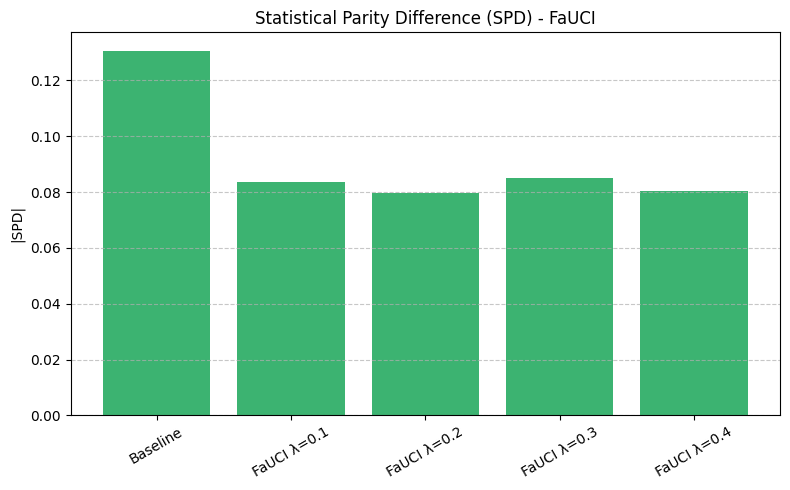

In [ ]:
model_names = ['Baseline'] + [f'FaUCI λ={w}' for w in reg_weights if w != 0.0]
spds = [baseline_spd_val] + fauci_spd_vals

results = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['SPD'], color='mediumseagreen')
plt.title('Statistical Parity Difference (SPD) - FaUCI')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


== Bar plot per λ = 0.1 ==


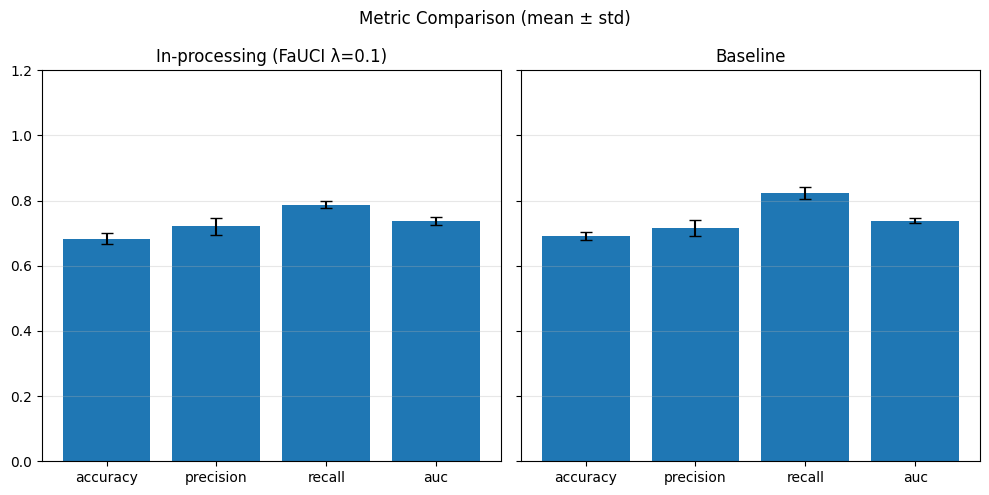

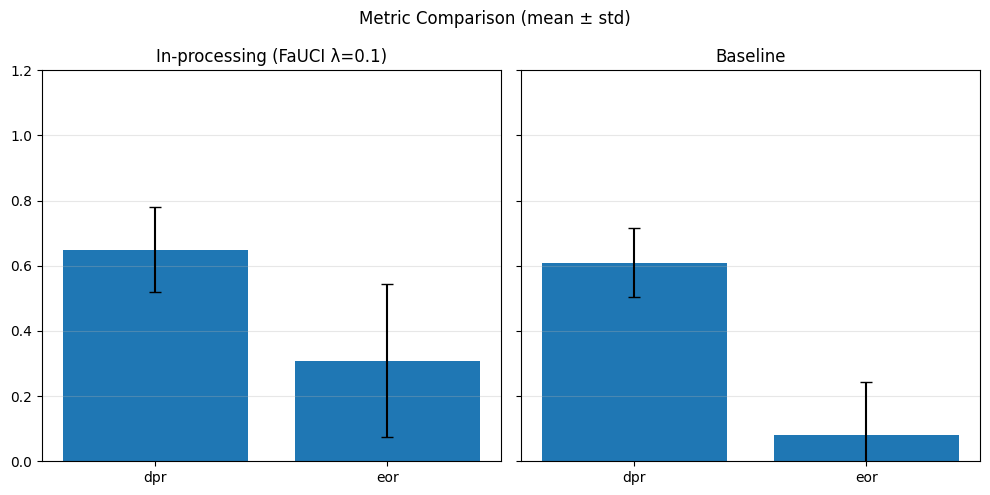

== Bar plot per λ = 0.2 ==


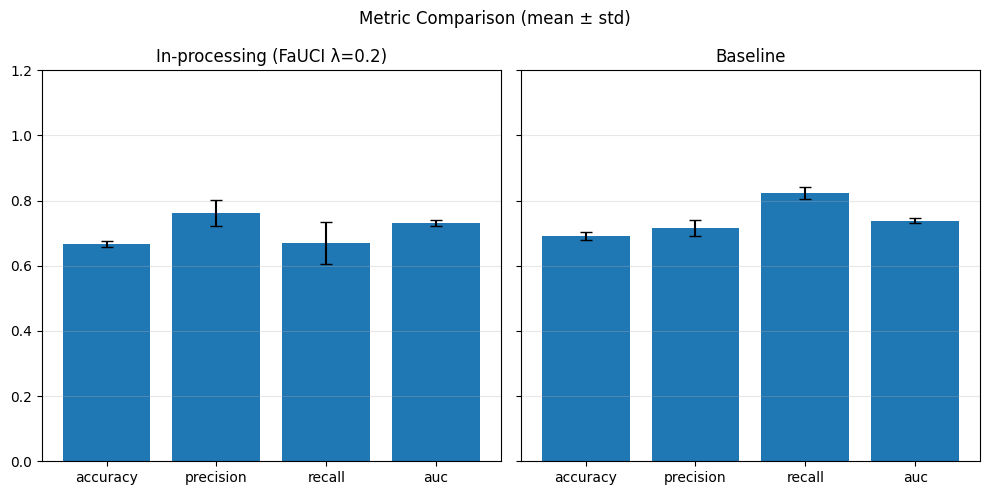

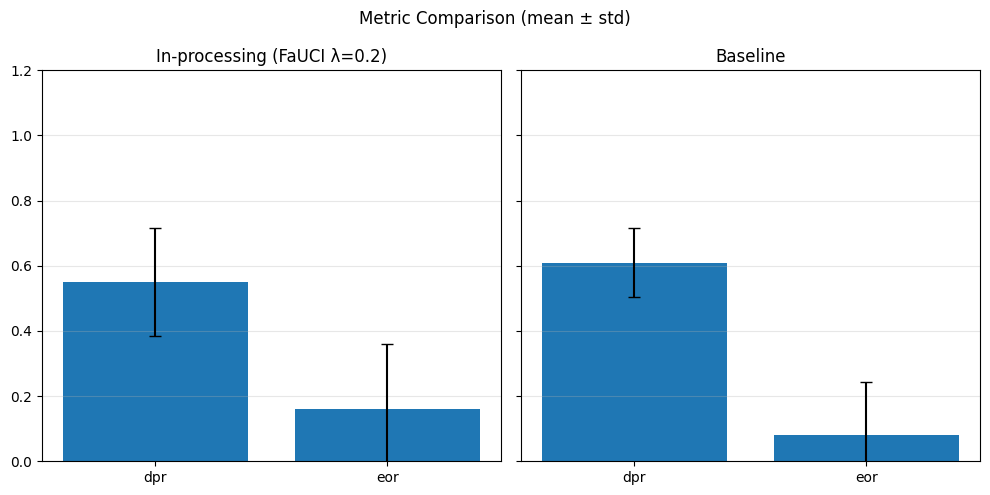

== Bar plot per λ = 0.3 ==


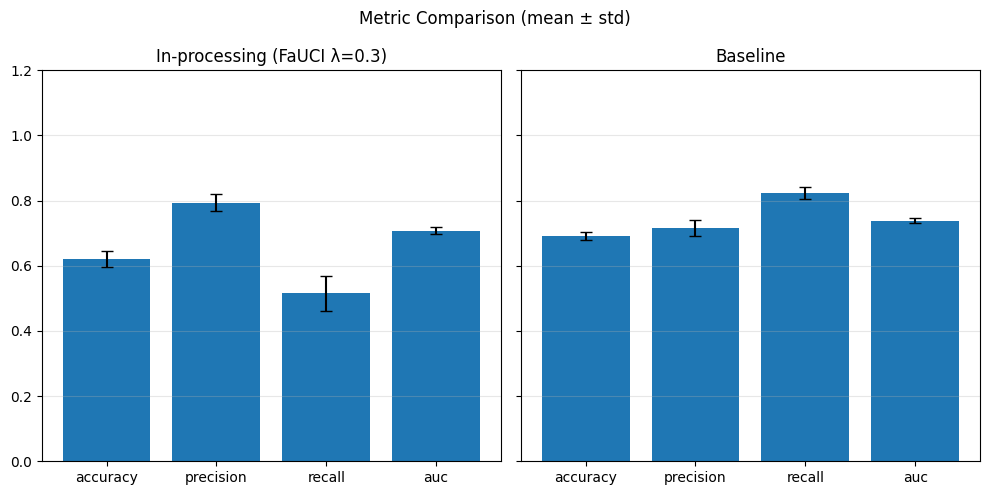

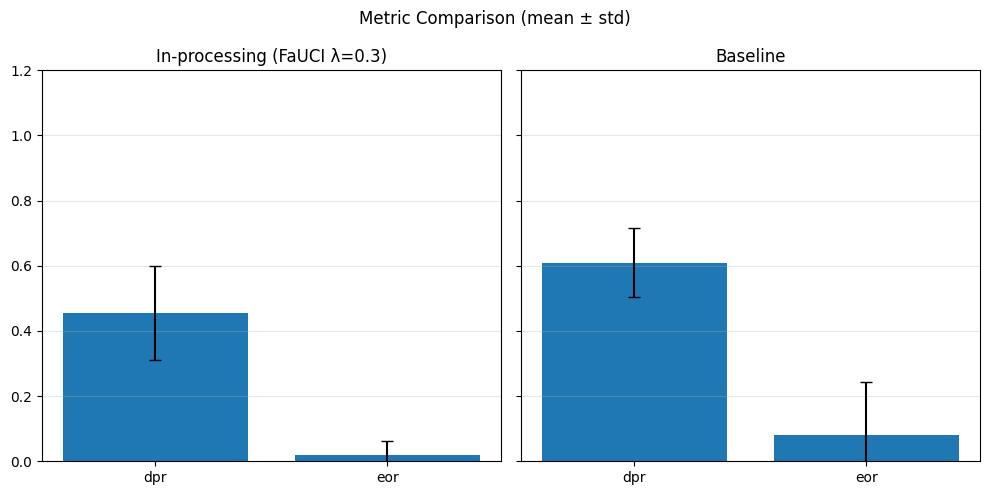

== Bar plot per λ = 0.4 ==


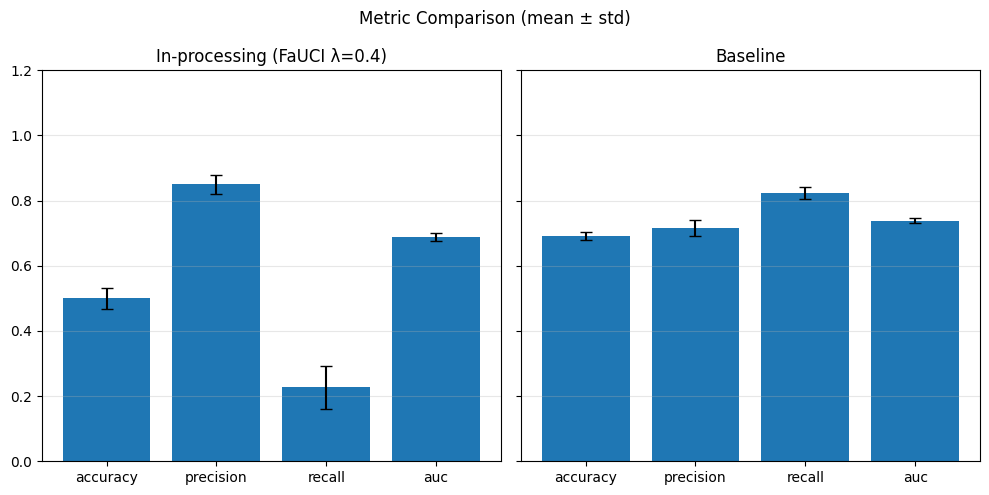

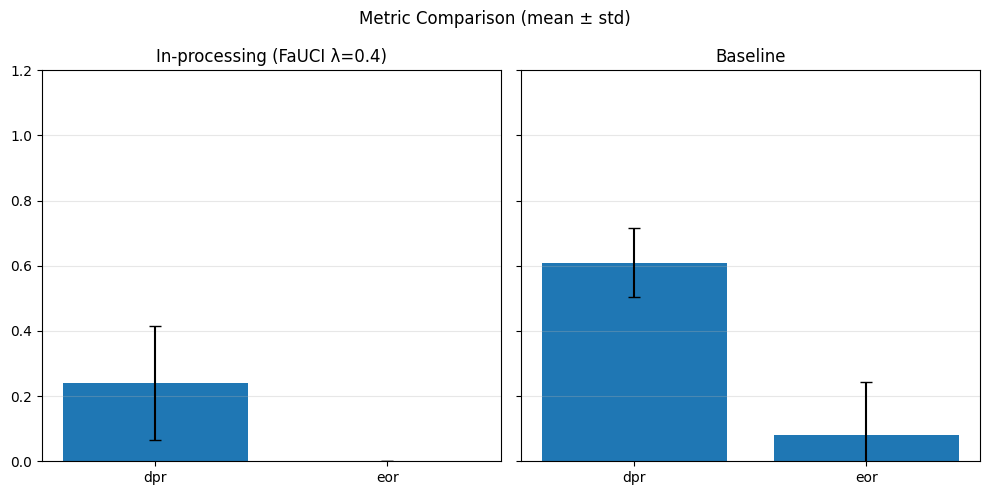

In [ ]:
for i, lam in enumerate(reg_weights[1:]):  # Salta λ=0.0 perché è il baseline
    print(f"== Bar plot per λ = {lam} ==")

    # Performance metrics
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (FaUCI λ={lam})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness metrics
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (FaUCI λ={lam})",
        "Baseline",
        ["dpr", "eor"]
    )


In contrast to Adversarial Debiasing, the FaUCI (Fair Uncertainty-aware Classification Index) method did not yield substantial improvements in fairness metrics.

In particular, when increasing the fairness regularization parameter λ, we observed a destabilization of the Equalized Odds Ratio (EOR)—often resulting in explosive or erratic values. This suggests that the model, under strong regularization pressure, struggles to maintain balanced error rates across sensitive groups.

At the same time, while Demographic Parity Ratio (DPR) tends to decrease slightly under high λ values (indicating some fairness enforcement), this comes at the cost of a significant drop in recall. The model becomes more conservative and tends to under-predict the positive class, especially for minority groups.

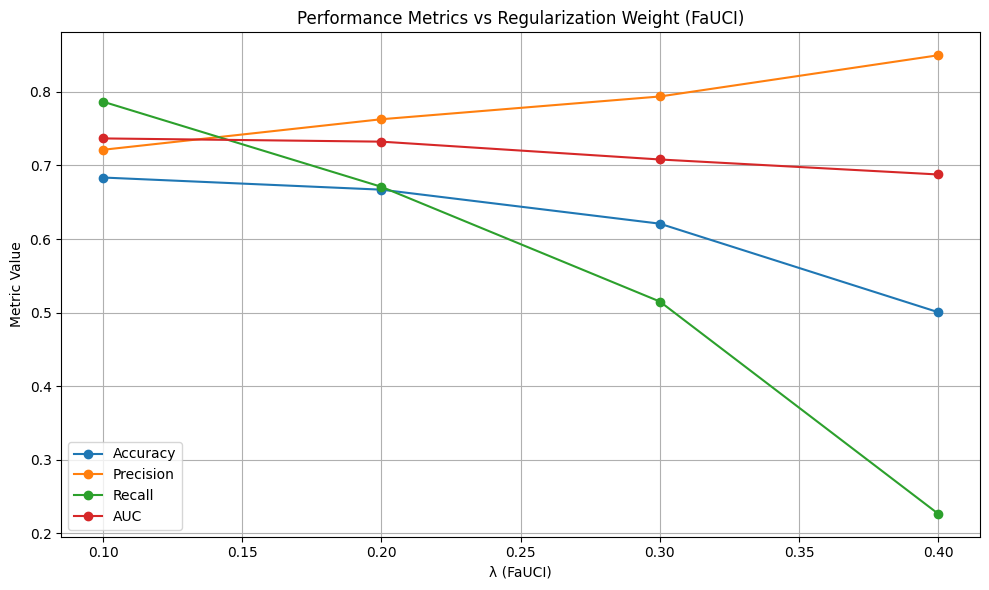

In [ ]:
fauci_lambdas = [w for w in reg_weights if w != 0.0]

accuracies = []
precisions = []
recalls = []
aucs = []

for metrics_list in inprocessing_performance_metrics:
    aggregated = aggregate_metrics(metrics_list)
    accuracies.append(np.mean(aggregated['accuracy']))
    precisions.append(np.mean(aggregated['precision']))
    recalls.append(np.mean(aggregated['recall']))
    aucs.append(np.mean(aggregated['auc']))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fauci_lambdas, accuracies, marker='o', label='Accuracy')
plt.plot(fauci_lambdas, precisions, marker='o', label='Precision')
plt.plot(fauci_lambdas, recalls, marker='o', label='Recall')
plt.plot(fauci_lambdas, aucs, marker='o', label='AUC')
plt.xlabel('λ (FaUCI)')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs Regularization Weight (FaUCI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


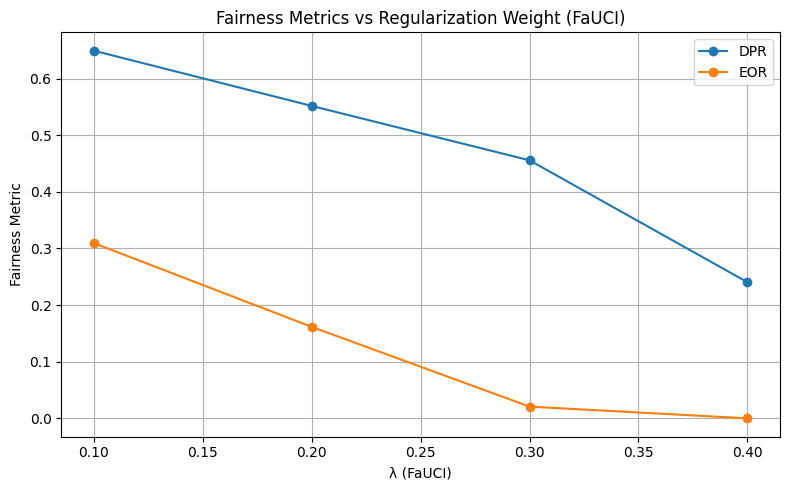

In [ ]:
fauci_lambdas = [w for w in reg_weights if w != 0.0]

dprs = []
eors = []

for metrics_list in inprocessing_fairness_metrics:
    aggregated = aggregate_metrics(metrics_list)
    dprs.append(np.mean(aggregated['dpr']))
    eors.append(np.mean(aggregated['eor']))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fauci_lambdas, dprs, marker='o', label='DPR')
plt.plot(fauci_lambdas, eors, marker='o', label='EOR')
plt.xlabel('λ (FaUCI)')
plt.ylabel('Fairness Metric')
plt.title('Fairness Metrics vs Regularization Weight (FaUCI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3) Prejudice Remover

In [ ]:
k = 5  
etas = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs = 100
batch_size = 128
pr_spd_vals = []

baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in etas if _ != 0.0]
inprocessing_fairness_metrics = [[] for _ in etas if _ != 0.0]


X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, eta in enumerate(etas):
    print(f"\n== PrejudiceRemover training with eta: {eta} ==")
    fold_spds = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[sensitive_feature].astype(str))):
        print(f"  Fold {fold + 1}/{k}")

        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]

        input_dim = X.shape[1]

        model = Simple_NN(input_dim)
        pr_model = fl.PrejudiceRemover(model, loss=nn.BCELoss(), eta=eta)

        # Prepara dati fairlib
        train_data = fl.DataFrame(X_train_fold)
        train_data[target] = y_train_fold.values
        train_data.targets = target
        train_data.sensitive = sensitive_feature

        test_data = fl.DataFrame(X_test_fold)
        test_data[target] = y_test_fold.values
        test_data.targets = target
        test_data.sensitive = sensitive_feature

        # Fit
        pr_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

        # Predict
        target_col = list(test_data.targets)[0]
        sensitive_col = list(test_data.sensitive)[0]
        X_test_df = test_data.drop(columns=target_col)
        y_true = test_data[target_col].to_numpy()

        y_pred_tensor = pr_model.predict(X_test_df)
        y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
        y_pred_bin = (y_pred > 0.5).astype(int)

        # Metrics
        perf_metrics = compute_performance_metrics(y_true, y_pred_bin, y_pred)
        fair_metrics = compute_fairness_metrics(y_true, y_pred_bin, X_test_df[sensitive_col])
        spd = evaluate_spd(X_test_df.copy(), y_pred_bin)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)

        # Salva
        if eta == 0.0:
            baseline_performance_metrics.append(perf_metrics)
            baseline_fairness_metrics.append(fair_metrics)
            if fold == 0:
                baseline_spd_val = spd_val
            print(f"[Baseline] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")
        else:
            inprocessing_performance_metrics[i - 1].append(perf_metrics)
            inprocessing_fairness_metrics[i - 1].append(fair_metrics)
            fold_spds.append(spd_val)

    if eta != 0.0:
        mean_spd = np.mean(fold_spds)
        pr_spd_vals.append(mean_spd)
        print(f"[η={eta}] Mean SPD: {mean_spd:.4f}")


== PrejudiceRemover training with eta: 0.0 ==
  Fold 1/5
[Baseline] Accuracy: 0.6770, SPD: 0.1216
  Fold 2/5
[Baseline] Accuracy: 0.6729, SPD: 0.0896
  Fold 3/5
[Baseline] Accuracy: 0.6829, SPD: 0.0912
  Fold 4/5
[Baseline] Accuracy: 0.6981, SPD: 0.0845
  Fold 5/5
[Baseline] Accuracy: 0.7020, SPD: 0.0834

== PrejudiceRemover training with eta: 0.1 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.1] Mean SPD: 0.0975

== PrejudiceRemover training with eta: 0.2 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.2] Mean SPD: 0.0995

== PrejudiceRemover training with eta: 0.3 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.3] Mean SPD: 0.0881

== PrejudiceRemover training with eta: 0.4 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.4] Mean SPD: 0.0994


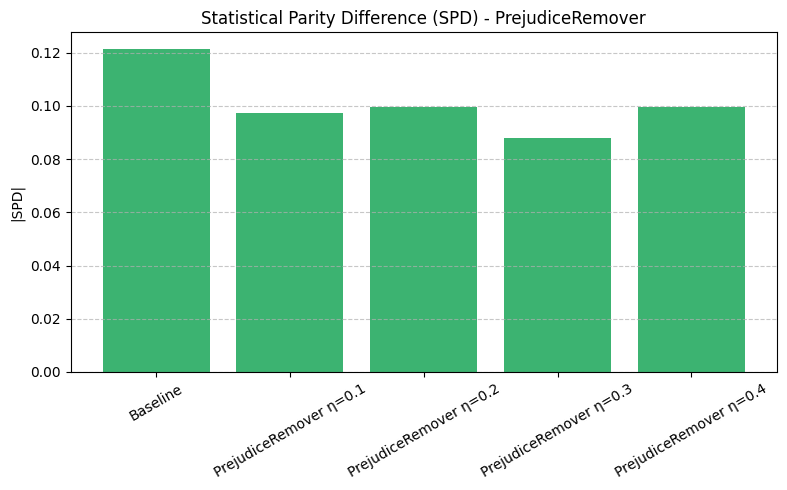

In [ ]:
model_names = ['Baseline'] + [f'PrejudiceRemover η={eta}' for eta in etas if eta != 0.0]
spds = [baseline_spd_val] + pr_spd_vals

results_df = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

# Plot SPD
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['SPD'], color='mediumseagreen')
plt.title('Statistical Parity Difference (SPD) - PrejudiceRemover')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

== Bar plot per η = 0.1 ==


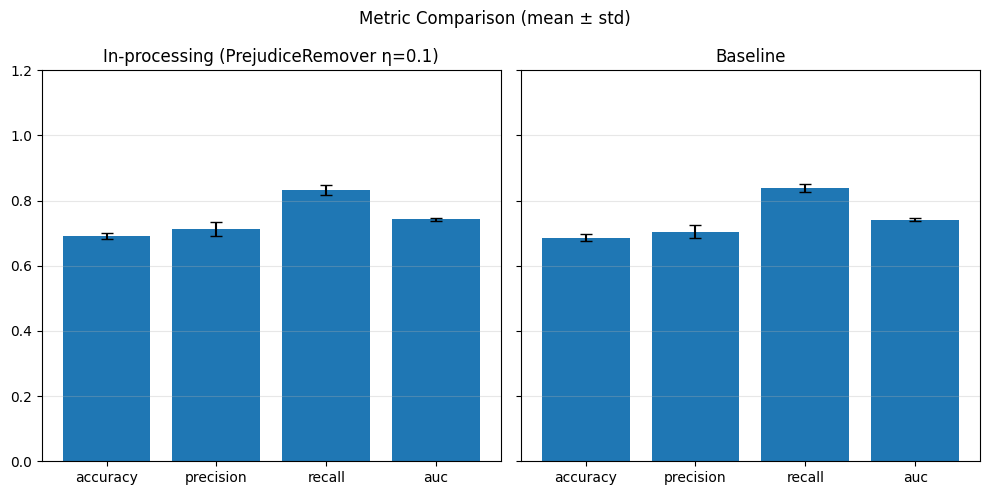

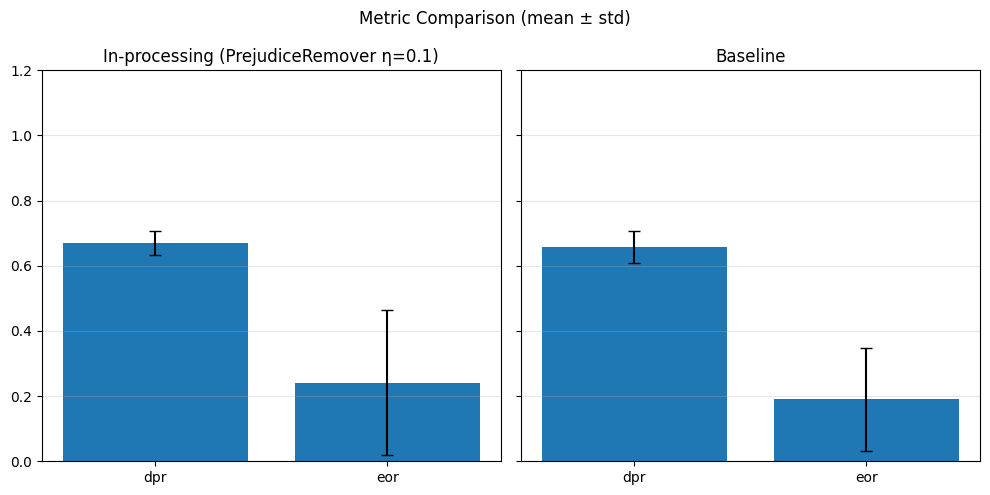

== Bar plot per η = 0.2 ==


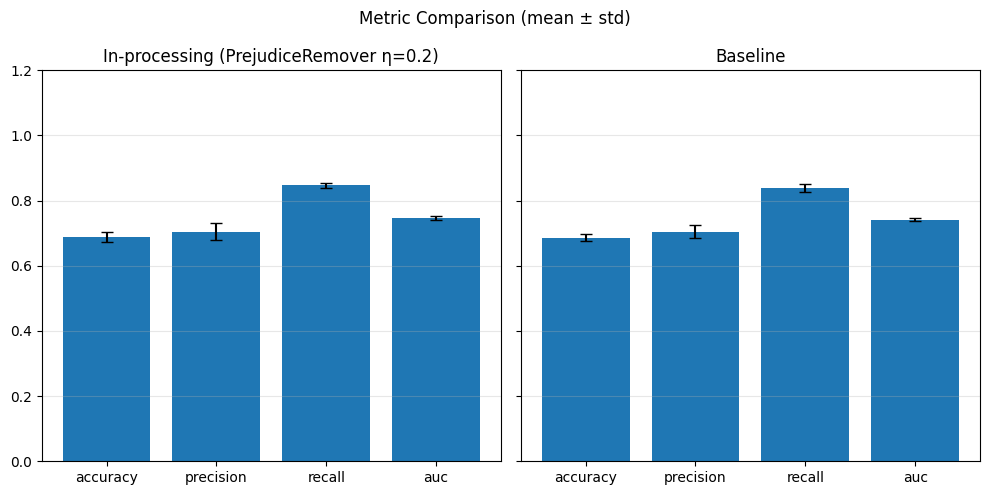

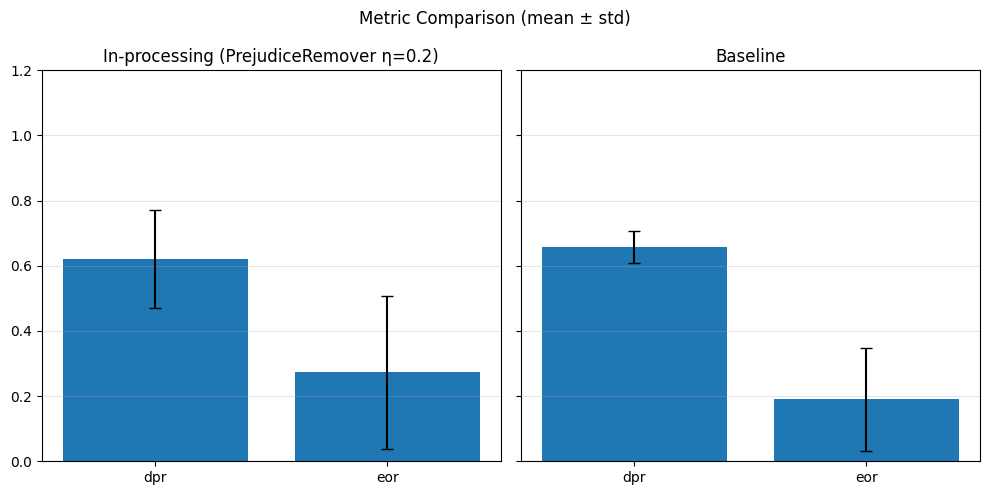

== Bar plot per η = 0.3 ==


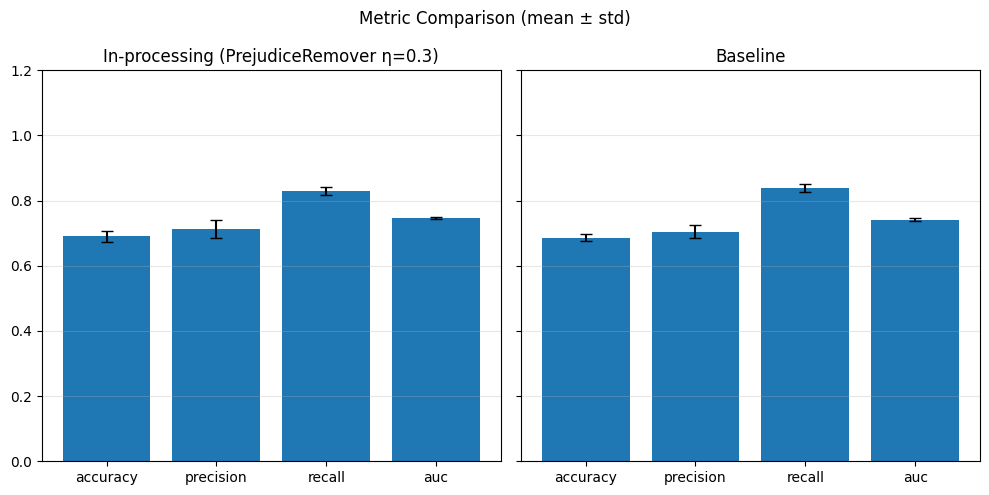

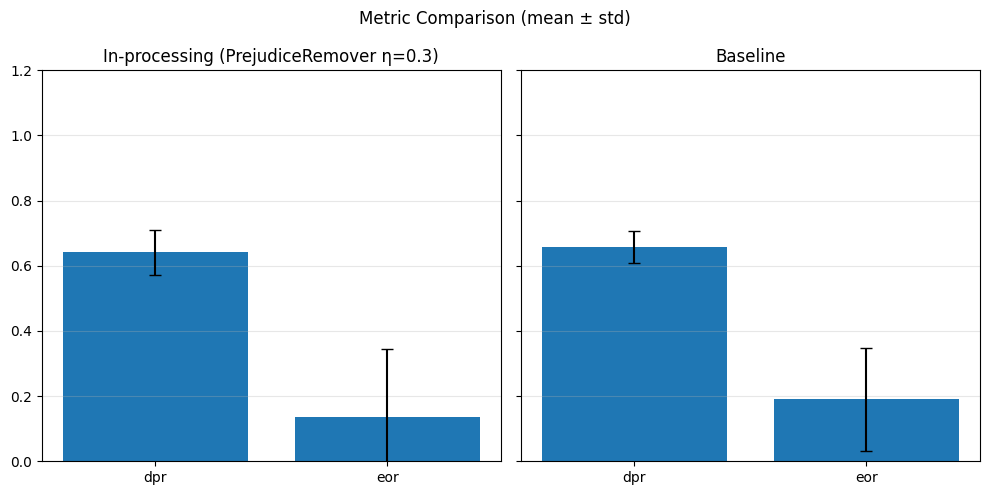

== Bar plot per η = 0.4 ==


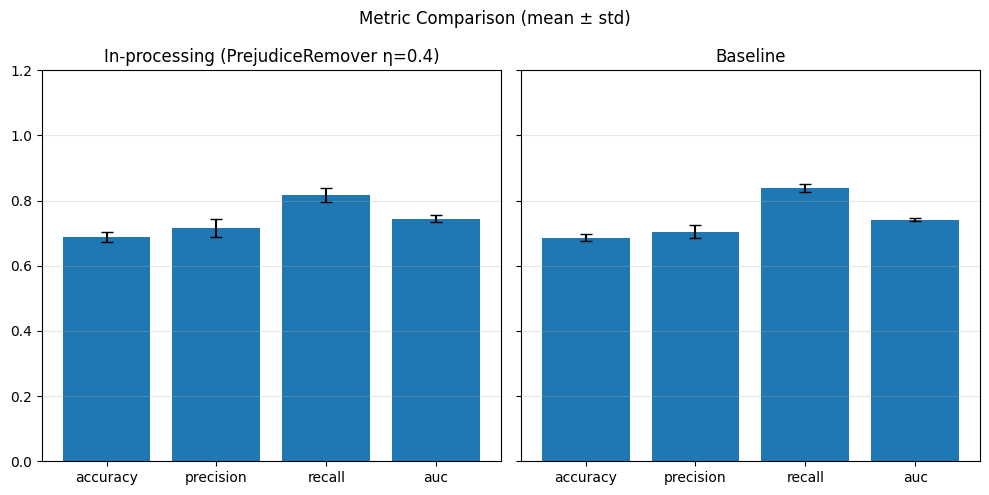

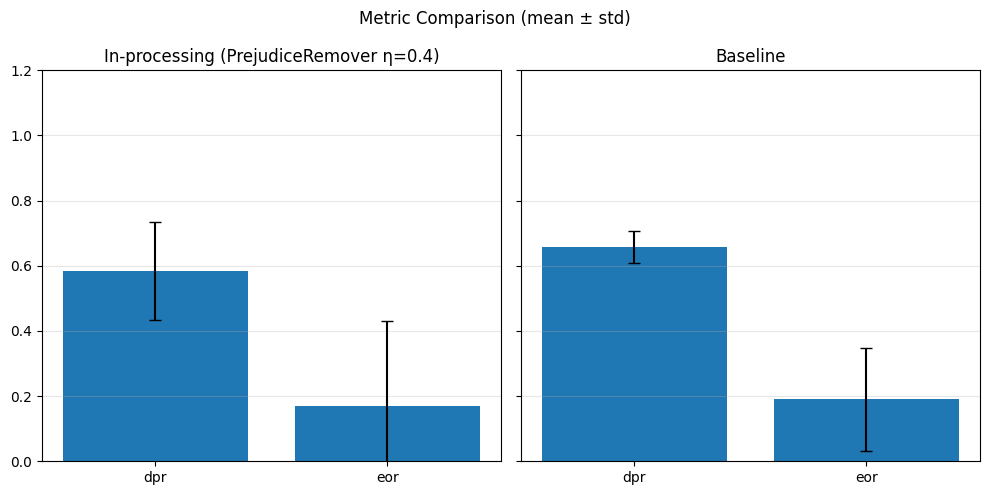

In [ ]:
for i, eta in enumerate(etas[1:]):  
    print(f"== Bar plot per η = {eta} ==")

    # Performance metrics
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (PrejudiceRemover η={eta})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness metrics
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (PrejudiceRemover η={eta})",
        "Baseline",
        ["dpr", "eor"]
    )


While the Demographic Parity Ratio (DPR) slightly decreases compared to the baseline, the improvement is marginal and accompanied by increased variance, indicating inconsistent fairness behavior across folds.

Notably, the Equalized Odds Ratio (EOR) remains very low in both models and exhibits high variability with the Prejudice Remover, suggesting instability in controlling error-rate parity.

Additional experiments with higher η values showed diminishing returns: rather than further improving fairness, higher regularization introduced performance degradation without significant gains in DPR or EOR.

These results suggest that Prejudice Remover is sensitive to η tuning, and beyond a certain threshold, increasing regularization may overconstrain the model—leading to worse generalization and unstable fairness outcomes. This behavior is especially problematic when the dataset lacks balanced representation across sensitive groups.

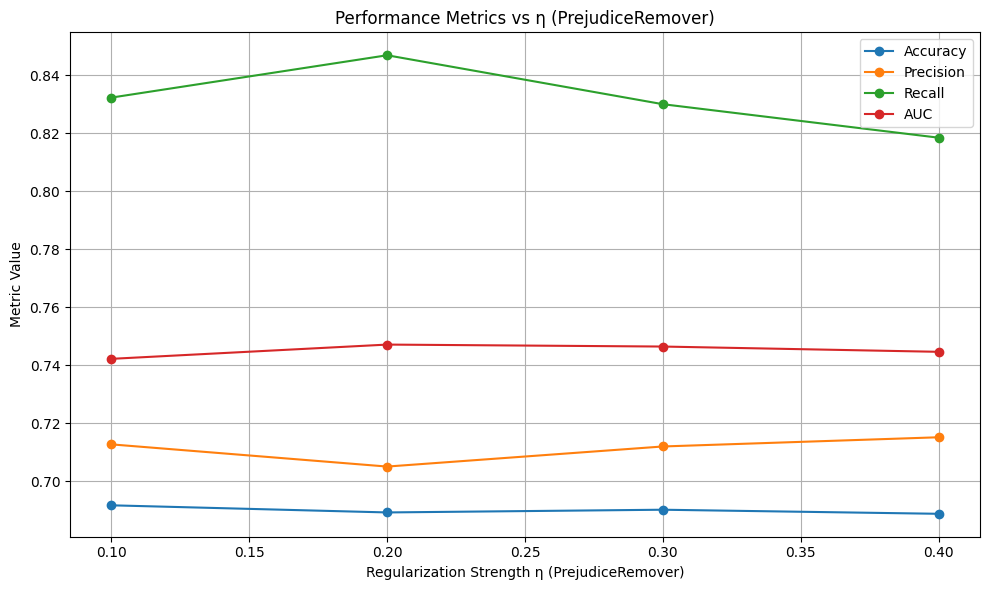

In [ ]:
etas_inprocessing = [eta for eta in etas if eta != 0.0]

accuracies = []
precisions = []
recalls = []
aucs = []

for metrics_list in inprocessing_performance_metrics:
    aggregated = aggregate_metrics(metrics_list)
    accuracies.append(np.mean(aggregated['accuracy']))
    precisions.append(np.mean(aggregated['precision']))
    recalls.append(np.mean(aggregated['recall']))
    aucs.append(np.mean(aggregated['auc']))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(etas_inprocessing, accuracies, marker='o', label='Accuracy')
plt.plot(etas_inprocessing, precisions, marker='o', label='Precision')
plt.plot(etas_inprocessing, recalls, marker='o', label='Recall')
plt.plot(etas_inprocessing, aucs, marker='o', label='AUC')
plt.xlabel('Regularization Strength η (PrejudiceRemover)')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs η (PrejudiceRemover)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


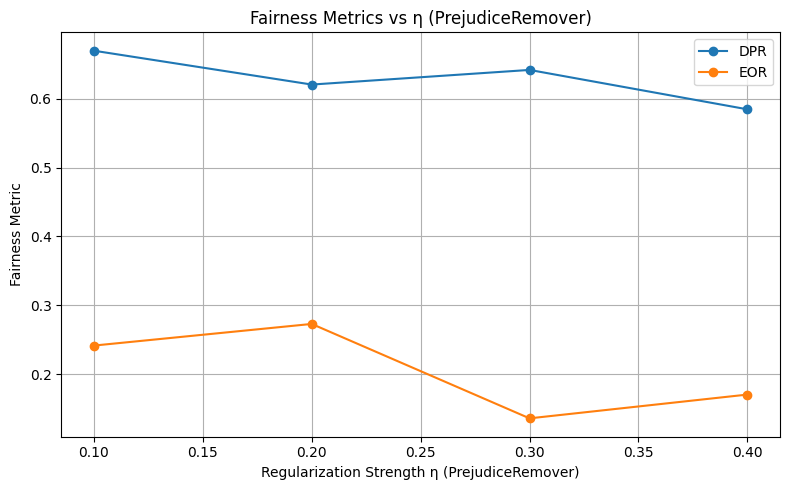

In [ ]:
etas_inprocessing = [eta for eta in etas if eta != 0.0]

dprs = []
eors = []

for metrics_list in inprocessing_fairness_metrics:
    aggregated = aggregate_metrics(metrics_list)
    dprs.append(np.mean(aggregated['dpr']))
    eors.append(np.mean(aggregated['eor']))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(etas_inprocessing, dprs, marker='o', label='DPR')
plt.plot(etas_inprocessing, eors, marker='o', label='EOR')
plt.xlabel('Regularization Strength η (PrejudiceRemover)')
plt.ylabel('Fairness Metric')
plt.title('Fairness Metrics vs η (PrejudiceRemover)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Results using different stratification

##### Adversarial Debiasing

In [112]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])



In [113]:
from fairlib.inprocessing import AdversarialDebiasing

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, df1[target].astype(str) + df1[sensitive_feature].astype(str))):
    print(f"\nFold {fold + 1}/{k}")

    # Suddivisione in training e test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    sensitive_train = X.iloc[train_index][sensitive_feature]
    sensitive_test = X.iloc[test_index][sensitive_feature]

    # Aggiungi la colonna 'sensitive' per fairlib
    X_train_copy = X_train.copy()
    X_train_copy["sensitive"] = sensitive_train.values
    X_train_dataframe = fl.DataFrame(X_train_copy)
    X_train_dataframe.sensitive = "sensitive"

    X_test_copy = X_test.copy()
    X_test_copy["sensitive"] = sensitive_test.values
    X_test_dataframe = fl.DataFrame(X_test_copy)
    X_test_dataframe.sensitive = "sensitive"

    # Modello AdversarialDebiasing
    baseline_model = AdversarialDebiasing(
        input_dim=X_train.shape[1],
        hidden_dim=8,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=0,  
    )

    # Training
    baseline_model.fit(X_train, y_train)

    # Prediction
    y_pred_tensor = baseline_model.predict(X_test)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_labels = (y_pred > 0.5).astype(int)
    y_proba = y_pred

    # Performance metrics
    perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
    baseline_performance_metrics.append(perf_metrics)

    # Fairness metrics
    fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, sensitive_test)
    baseline_fairness_metrics.append(fair_metrics)

    # SPD evaluation
    spd = evaluate_spd(X_test.copy(), y_pred_labels)
    baseline_spd_val = sum(abs(v) for v in spd.values()) / len(spd)

    print(f"SPD Fold {fold + 1}: {spd}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



Fold 1/5
SPD Fold 1: {(hired=0, grouped_regions=0.0): -0.16671147767321876, (hired=0, grouped_regions=1.0): -0.13577868219051054, (hired=0, grouped_regions=2.0): -0.08214504126914363, (hired=0, grouped_regions=3.0): 0.12147523360621848, (hired=0, grouped_regions=4.0): 0.31919905771495877, (hired=0, grouped_regions=5.0): 0.05390703999442101, (hired=1, grouped_regions=0.0): 0.1667114776732187, (hired=1, grouped_regions=1.0): 0.1357786821905106, (hired=1, grouped_regions=2.0): 0.08214504126914368, (hired=1, grouped_regions=3.0): -0.12147523360621848, (hired=1, grouped_regions=4.0): -0.3191990577149588, (hired=1, grouped_regions=5.0): -0.053907039994421035}

Fold 2/5
SPD Fold 2: {(hired=0, grouped_regions=0.0): -0.09359444827962068, (hired=0, grouped_regions=1.0): -0.03841121013858123, (hired=0, grouped_regions=2.0): -0.04134866028894907, (hired=0, grouped_regions=3.0): 0.06407012321177541, (hired=0, grouped_regions=4.0): -0.040047114252061256, (hired=0, grouped_regions=5.0): -0.030405523

In [114]:
# In-processing con Adversarial Debiasing su diversi lambda_adv
adv_weights = [0.1, 0.5, 1.0]
adv_spds = []

for i, lam in enumerate(adv_weights):
    print(f"\n== Adversarial Debiasing con lambda_adv={lam} ==")

    # Crea liste per ciascun lambda
    perf_list = []
    fair_list = []
    spd_list = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[target].astype(str) + df1[sensitive_feature].astype(str))):
        print(f"\nFold {fold + 1}/{k} - lambda_adv={lam}")

        # Split dei dati
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        sensitive_train = X.iloc[train_index][sensitive_feature]
        sensitive_test = X.iloc[test_index][sensitive_feature]

        # Prepara fairlib dataframe
        X_train_copy = X_train.copy()
        X_train_copy["sensitive"] = sensitive_train.values
        X_tr = fl.DataFrame(X_train_copy)
        X_tr.sensitive = "sensitive"

        X_test_copy = X_test.copy()
        X_test_copy["sensitive"] = sensitive_test.values
        X_te = fl.DataFrame(X_test_copy)
        X_te.sensitive = "sensitive"

        # Modello Adversarial Debiasing
        model = AdversarialDebiasing(
            input_dim=X_train.shape[1],
            hidden_dim=8,
            output_dim=1,
            sensitive_dim=1,
            lambda_adv=lam,
        )

        # Addestramento
        model.fit(X_train, y_train)

        # Predizione
        y_pred_tensor = model.predict(X_test)
        y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
        y_pred_labels = (y_pred > 0.5).astype(int)
        y_proba = y_pred

        # Performance
        perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
        perf_list.append(perf_metrics)

        # Fairness
        fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, sensitive_test)
        fair_list.append(fair_metrics)

        # SPD
        spd = evaluate_spd(X_test.copy(), y_pred_labels)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)
        spd_list.append(spd_val)

        print(f"SPD Fold {fold + 1} (λ={lam}): {spd}")

    # Salva i risultati complessivi del lambda
    inprocessing_performance_metrics.append(perf_list)
    inprocessing_fairness_metrics.append(fair_list)
    adv_spds.append(spd_list)


== Adversarial Debiasing con lambda_adv=0.1 ==

Fold 1/5 - lambda_adv=0.1


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


SPD Fold 1 (λ=0.1): {(hired=0, grouped_regions=0.0): -0.0059441194637212535, (hired=0, grouped_regions=1.0): -0.015558188655916752, (hired=0, grouped_regions=2.0): -0.016120194483279088, (hired=0, grouped_regions=3.0): 0.01926734474489375, (hired=0, grouped_regions=4.0): 0.23439340400471143, (hired=0, grouped_regions=5.0): -0.1007705986959099, (hired=1, grouped_regions=0.0): 0.005944119463721198, (hired=1, grouped_regions=1.0): 0.015558188655916738, (hired=1, grouped_regions=2.0): 0.01612019448327906, (hired=1, grouped_regions=3.0): -0.019267344744893777, (hired=1, grouped_regions=4.0): -0.23439340400471143, (hired=1, grouped_regions=5.0): 0.10077059869590987}

Fold 2/5 - lambda_adv=0.1
SPD Fold 2 (λ=0.1): {(hired=0, grouped_regions=0.0): 0.0901427896668241, (hired=0, grouped_regions=1.0): -0.0672299211787131, (hired=0, grouped_regions=2.0): -0.03649814437043772, (hired=0, grouped_regions=3.0): 0.02537831803522697, (hired=0, grouped_regions=4.0): 0.35159010600706714, (hired=0, grouped_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


SPD Fold 1 (λ=0.5): {(hired=1, grouped_regions=0.0): 0.0, (hired=1, grouped_regions=1.0): 0.0, (hired=1, grouped_regions=2.0): 0.0, (hired=1, grouped_regions=3.0): 0.0, (hired=1, grouped_regions=4.0): 0.0, (hired=1, grouped_regions=5.0): 0.0}

Fold 2/5 - lambda_adv=0.5
SPD Fold 2 (λ=0.5): {(hired=0, grouped_regions=0.0): -0.020971551066380843, (hired=0, grouped_regions=1.0): -0.03282674772036474, (hired=0, grouped_regions=2.0): -0.032364724098895584, (hired=0, grouped_regions=3.0): 0.04093277102455966, (hired=0, grouped_regions=4.0): -0.03180212014134275, (hired=0, grouped_regions=5.0): -0.032009484291641965, (hired=1, grouped_regions=0.0): 0.020971551066380933, (hired=1, grouped_regions=1.0): 0.03282674772036476, (hired=1, grouped_regions=2.0): 0.03236472409889557, (hired=1, grouped_regions=3.0): -0.04093277102455961, (hired=1, grouped_regions=4.0): 0.03180212014134276, (hired=1, grouped_regions=5.0): 0.032009484291641965}

Fold 3/5 - lambda_adv=0.5
SPD Fold 3 (λ=0.5): {(hired=1, grou

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


SPD Fold 1 (λ=1.0): {(hired=1, grouped_regions=0.0): 0.0, (hired=1, grouped_regions=1.0): 0.0, (hired=1, grouped_regions=2.0): 0.0, (hired=1, grouped_regions=3.0): 0.0, (hired=1, grouped_regions=4.0): 0.0, (hired=1, grouped_regions=5.0): 0.0}

Fold 2/5 - lambda_adv=1.0
SPD Fold 2 (λ=1.0): {(hired=1, grouped_regions=0.0): 0.0, (hired=1, grouped_regions=1.0): 0.0, (hired=1, grouped_regions=2.0): 0.0, (hired=1, grouped_regions=3.0): 0.0, (hired=1, grouped_regions=4.0): 0.0, (hired=1, grouped_regions=5.0): 0.0}

Fold 3/5 - lambda_adv=1.0
SPD Fold 3 (λ=1.0): {(hired=1, grouped_regions=0.0): 0.0, (hired=1, grouped_regions=1.0): 0.0, (hired=1, grouped_regions=2.0): 0.0, (hired=1, grouped_regions=3.0): 0.0, (hired=1, grouped_regions=4.0): 0.0, (hired=1, grouped_regions=5.0): 0.0}

Fold 4/5 - lambda_adv=1.0
SPD Fold 4 (λ=1.0): {(hired=0, grouped_regions=0.0): -0.0006172839506172839, (hired=0, grouped_regions=1.0): -0.0006082725060827251, (hired=0, grouped_regions=2.0): 0.0014992503748125937, (h

== Bar plot per λ = 0.1 ==


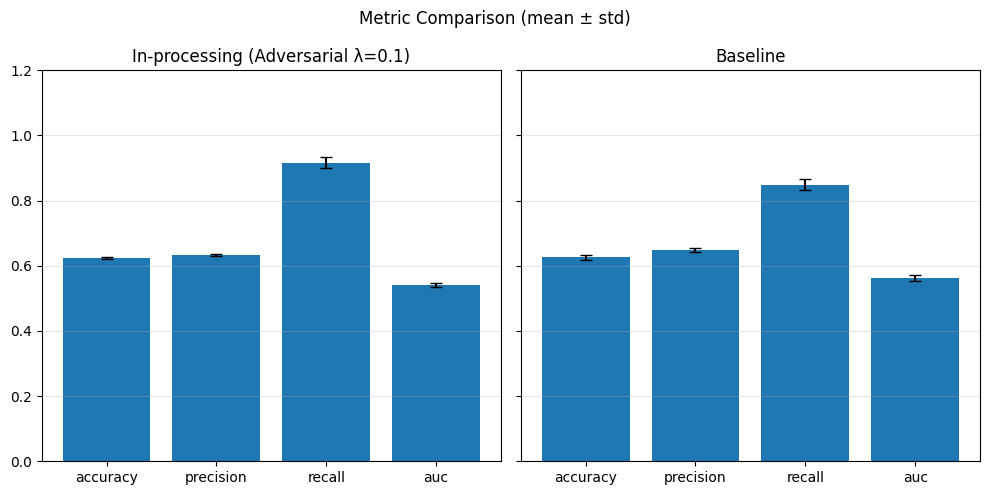

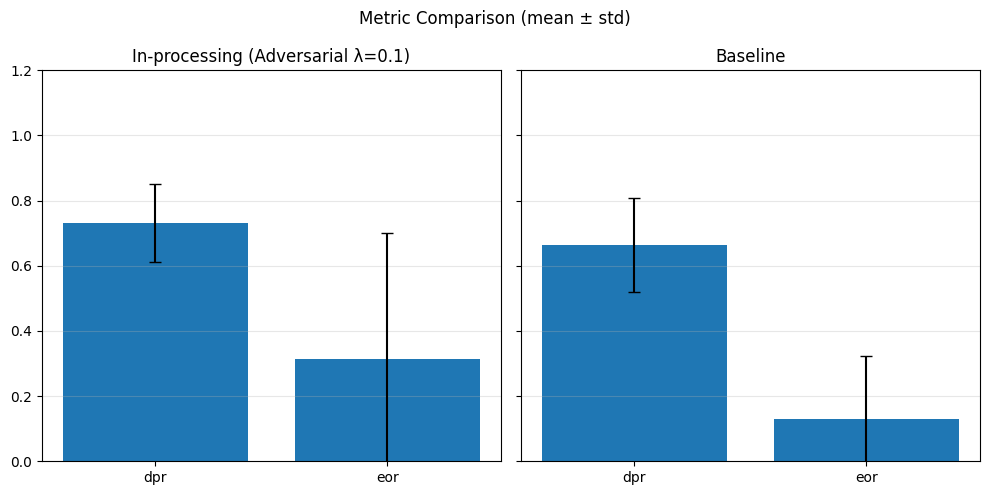

== Bar plot per λ = 0.5 ==


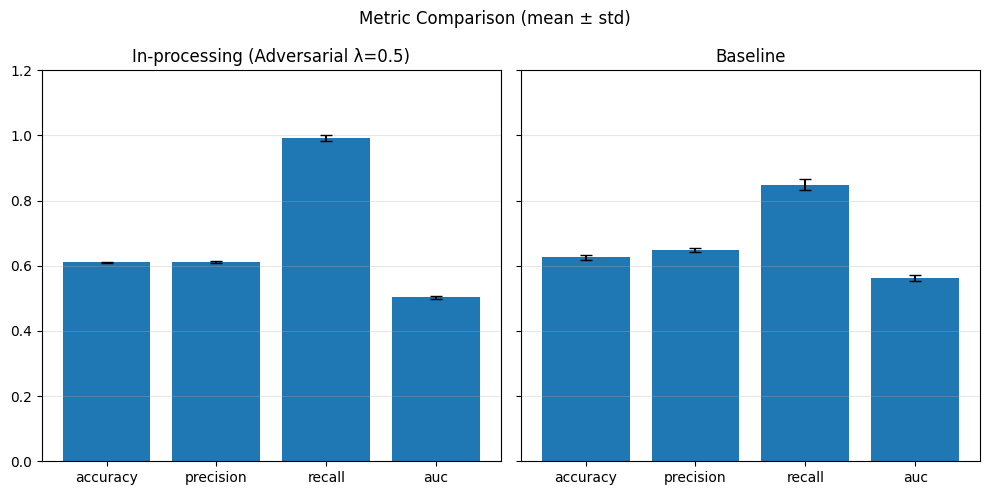

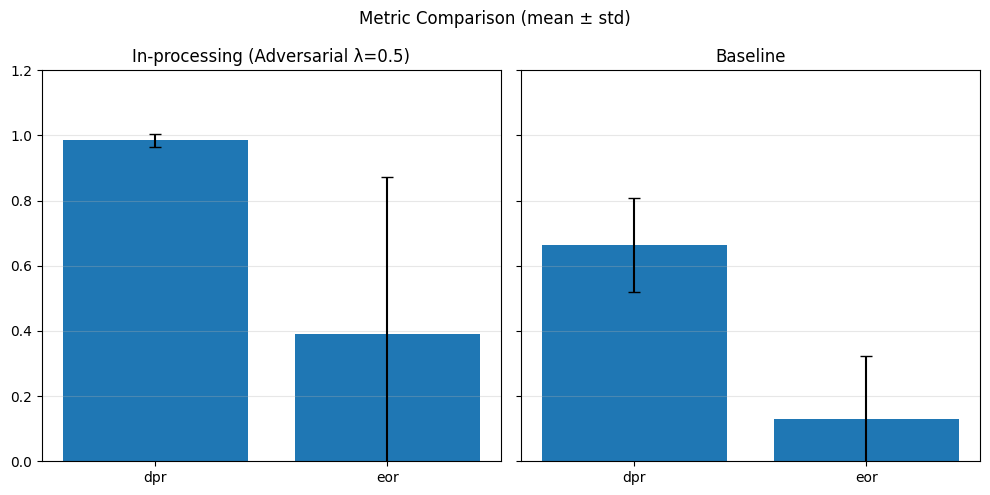

== Bar plot per λ = 1.0 ==


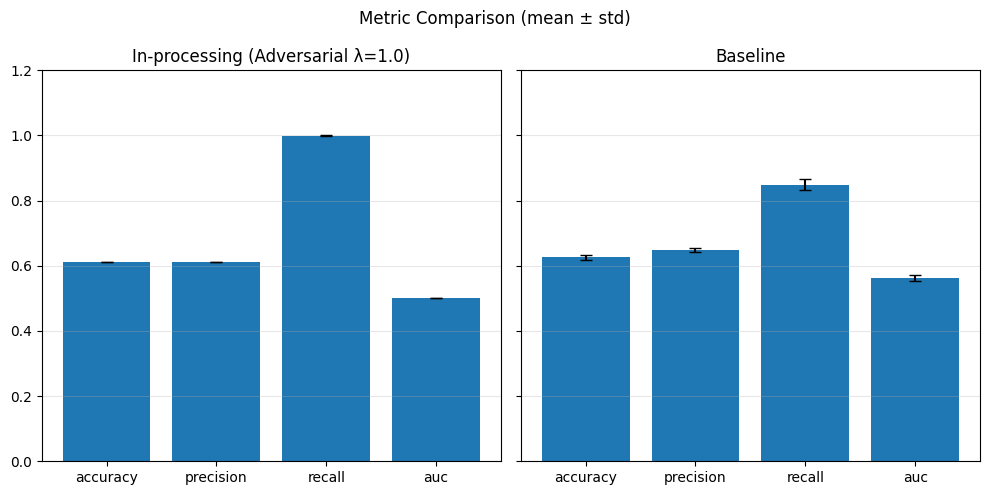

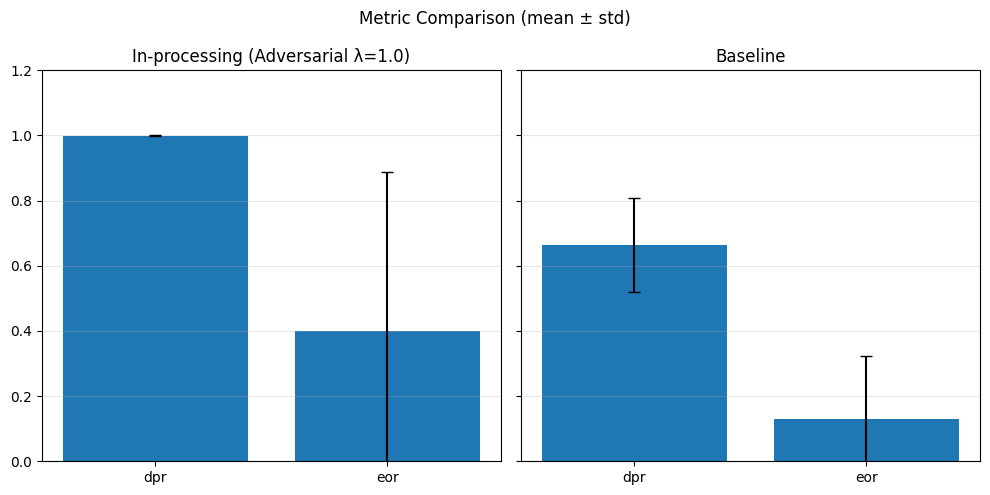

In [115]:
for i, lam in enumerate(adv_weights):
    print(f"== Bar plot per λ = {lam} ==")

    # Performance
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (Adversarial λ={lam})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (Adversarial λ={lam})",
        "Baseline",
        ["dpr", "eor"]
    )

##### FaUCI

In [106]:
k = 5  
reg_weights = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs = 100
batch_size = 128
fauci_spd_vals = []

baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in reg_weights if _ != 0.0]
inprocessing_fairness_metrics = [[] for _ in reg_weights if _ != 0.0]


X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [107]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, weight in enumerate(reg_weights):
    print(f"\n== FaUCI training with regularization weight: {weight} ==")
    fold_spds = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[target].astype(str) + df1[sensitive_feature].astype(str))):
        print(f"  Fold {fold + 1}/{k}")

        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]

        input_dim = X.shape[1]
        X_test_tensor = torch.tensor(X_test_fold.values, dtype=torch.float32)

        model = Simple_NN(input_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        fauci_model = fl.Fauci(
            torchModel=model,
            optimizer=optimizer,
            loss=nn.BCELoss(),
            fairness_regularization="spd",
            regularization_weight=weight
        )

        # Prepara dati fairlib
        train_data = fl.DataFrame(X_train_fold)
        train_data[target] = y_train_fold.values
        train_data.targets = target
        train_data.sensitive = sensitive_feature

        # Fit
        fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

        # Predict
        model.eval()
        with torch.no_grad():
            y_pred_tensor = fauci_model.predict(X_test_tensor)
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_pred_labels = (y_pred > 0.5).astype(int)

        # Metrics
        perf_metrics = compute_performance_metrics(y_test_fold, y_pred_labels, y_pred)
        fair_metrics = compute_fairness_metrics(y_test_fold, y_pred_labels, X_test_fold[sensitive_feature])
        spd = evaluate_spd(X_test_fold.copy(), y_pred_labels)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)

        # Salva
        if weight == 0.0:
            baseline_performance_metrics.append(perf_metrics)
            baseline_fairness_metrics.append(fair_metrics)
            if fold == 0:
                baseline_spd_val = spd_val
        else:
            inprocessing_performance_metrics[i - 1].append(perf_metrics)
            inprocessing_fairness_metrics[i - 1].append(fair_metrics)
            fold_spds.append(spd_val)

    if weight != 0.0:
        mean_spd = np.mean(fold_spds)
        fauci_spd_vals.append(mean_spd)
        print(f"[λ={weight}] Mean SPD: {mean_spd:.4f}")


== FaUCI training with regularization weight: 0.0 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

== FaUCI training with regularization weight: 0.1 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.1] Mean SPD: 0.1674

== FaUCI training with regularization weight: 0.2 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.2] Mean SPD: 0.1362

== FaUCI training with regularization weight: 0.3 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.3] Mean SPD: 0.1405

== FaUCI training with regularization weight: 0.4 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.4] Mean SPD: 0.0827


== Bar plot per λ = 0.1 ==


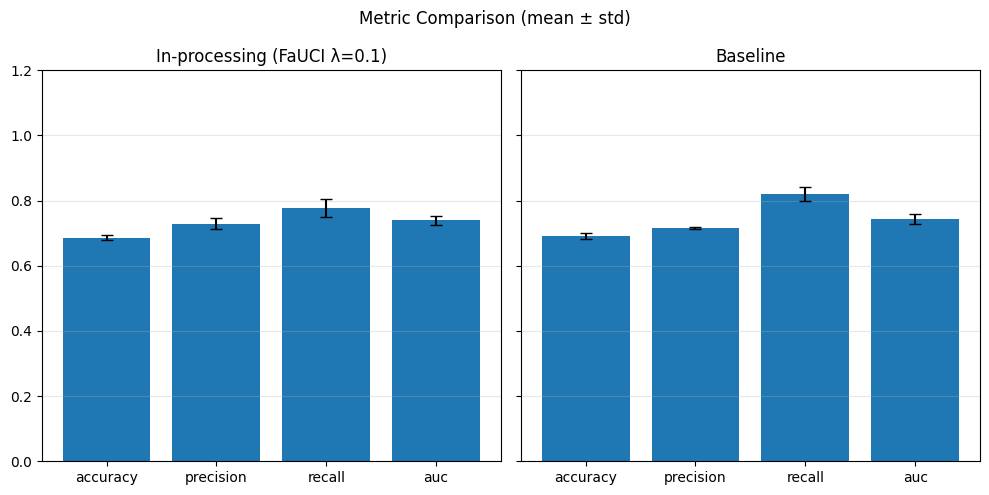

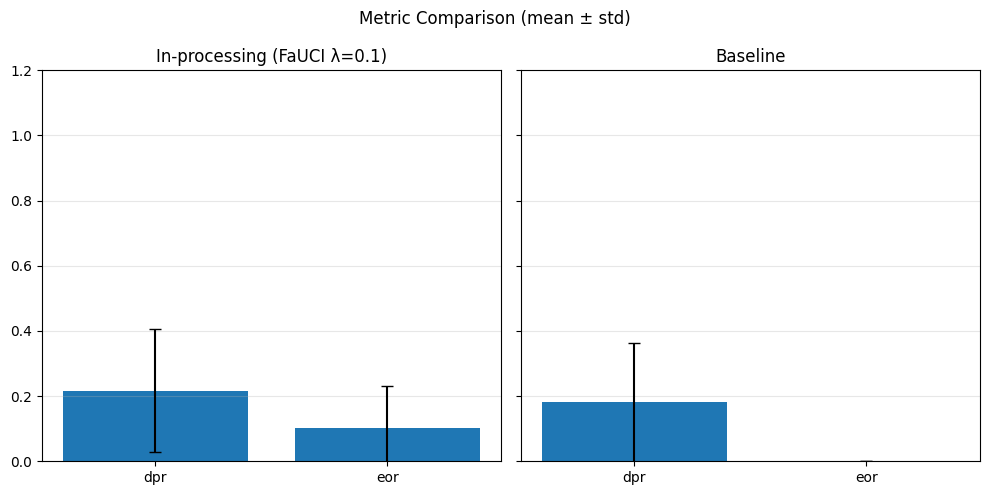

== Bar plot per λ = 0.2 ==


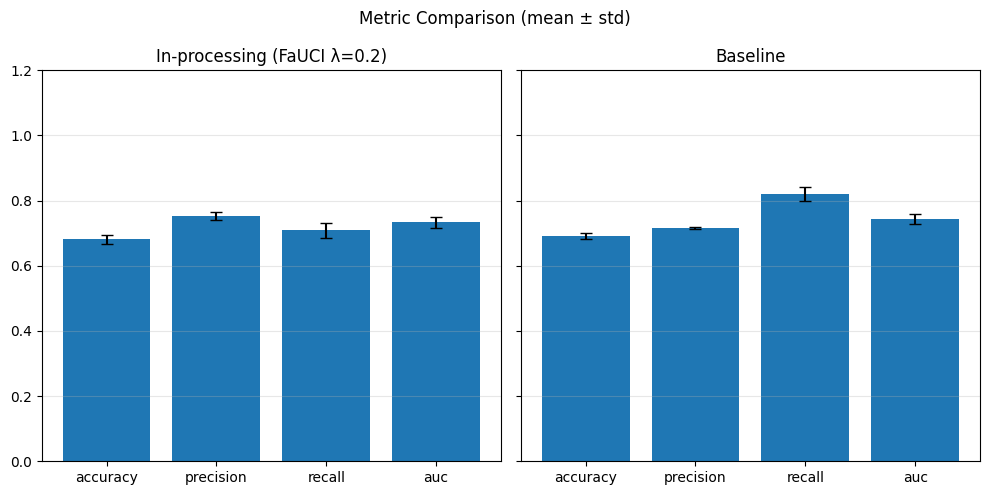

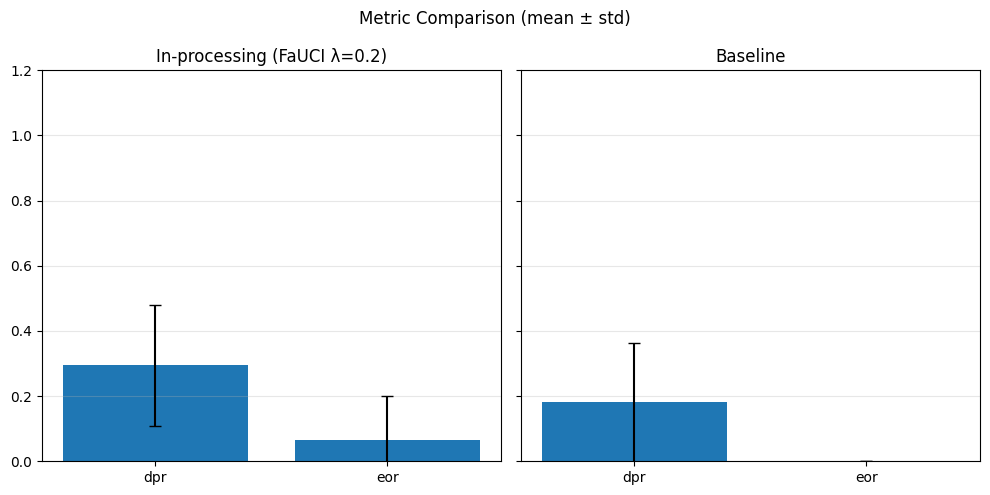

== Bar plot per λ = 0.3 ==


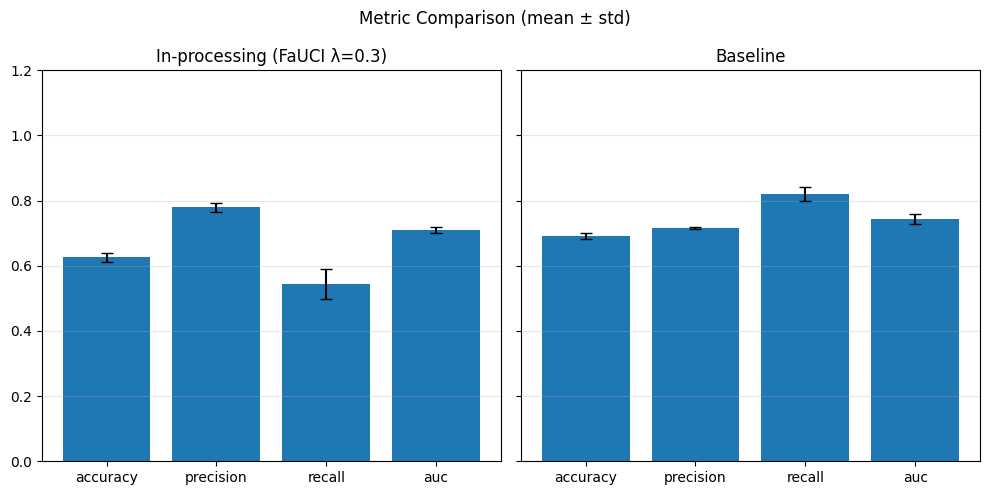

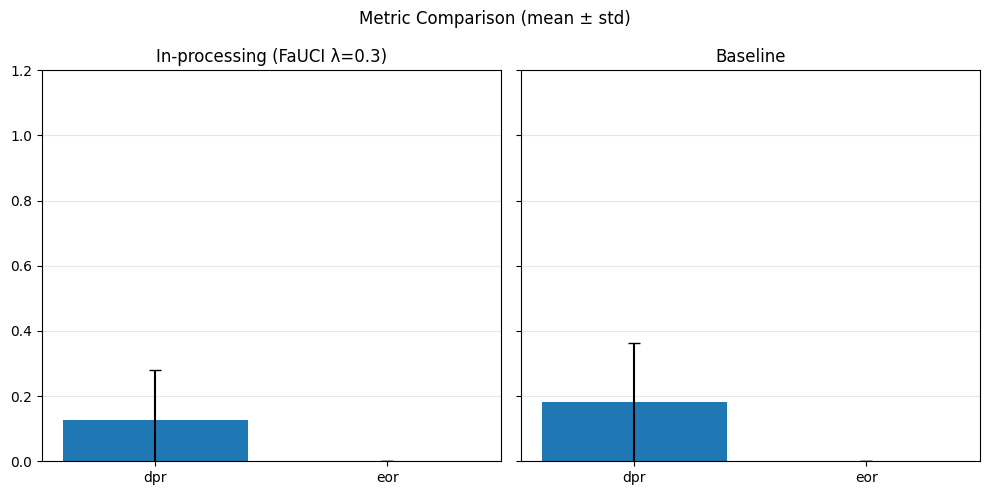

== Bar plot per λ = 0.4 ==


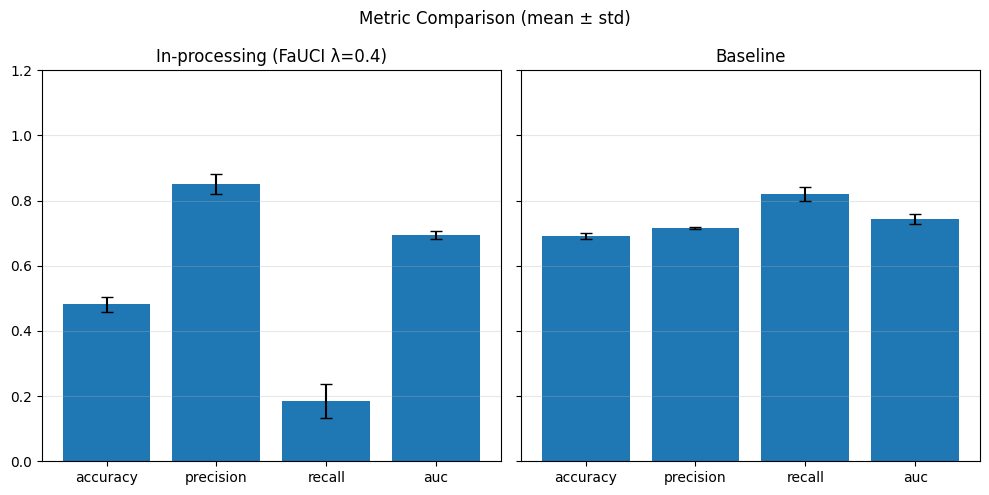

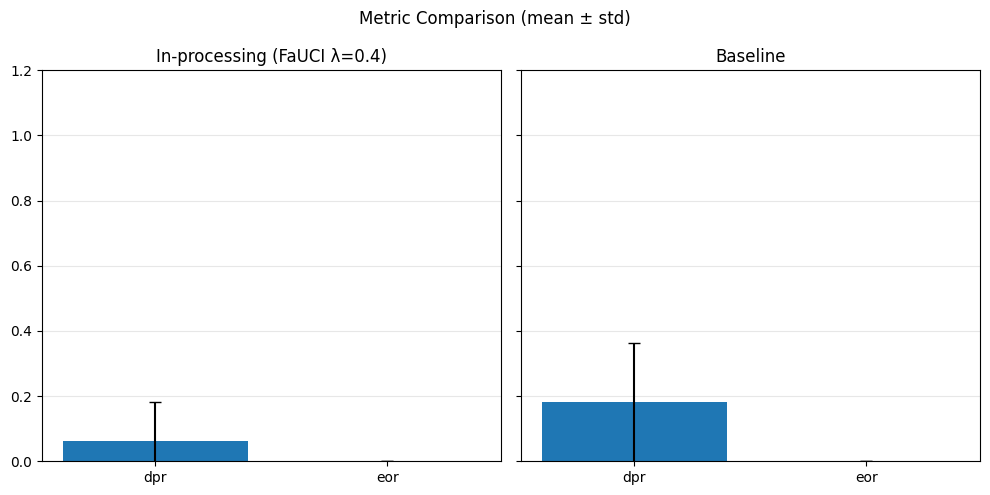

In [108]:
for i, lam in enumerate(reg_weights[1:]):  # Salta λ=0.0 perché è il baseline
    print(f"== Bar plot per λ = {lam} ==")

    # Performance metrics
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (FaUCI λ={lam})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness metrics
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (FaUCI λ={lam})",
        "Baseline",
        ["dpr", "eor"]
    )


##### Prejudice Remover

In [101]:
k = 5  
etas = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs = 100
batch_size = 128
pr_spd_vals = []

baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in etas if _ != 0.0]
inprocessing_fairness_metrics = [[] for _ in etas if _ != 0.0]


X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [102]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, eta in enumerate(etas):
    print(f"\n== PrejudiceRemover training with eta: {eta} ==")
    fold_spds = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[target].astype(str) + df1[sensitive_feature].astype(str))):
        print(f"  Fold {fold + 1}/{k}")

        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]

        input_dim = X.shape[1]

        model = Simple_NN(input_dim)
        pr_model = fl.PrejudiceRemover(model, loss=nn.BCELoss(), eta=eta)

        # Prepara dati fairlib
        train_data = fl.DataFrame(X_train_fold)
        train_data[target] = y_train_fold.values
        train_data.targets = target
        train_data.sensitive = sensitive_feature

        test_data = fl.DataFrame(X_test_fold)
        test_data[target] = y_test_fold.values
        test_data.targets = target
        test_data.sensitive = sensitive_feature

        # Fit
        pr_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

        # Predict
        target_col = list(test_data.targets)[0]
        sensitive_col = list(test_data.sensitive)[0]
        X_test_df = test_data.drop(columns=target_col)
        y_true = test_data[target_col].to_numpy()

        y_pred_tensor = pr_model.predict(X_test_df)
        y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
        y_pred_bin = (y_pred > 0.5).astype(int)

        # Metrics
        perf_metrics = compute_performance_metrics(y_true, y_pred_bin, y_pred)
        fair_metrics = compute_fairness_metrics(y_true, y_pred_bin, X_test_df[sensitive_col])
        spd = evaluate_spd(X_test_df.copy(), y_pred_bin)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)

        # Salva
        if eta == 0.0:
            baseline_performance_metrics.append(perf_metrics)
            baseline_fairness_metrics.append(fair_metrics)
            if fold == 0:
                baseline_spd_val = spd_val
            print(f"[Baseline] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")
        else:
            inprocessing_performance_metrics[i - 1].append(perf_metrics)
            inprocessing_fairness_metrics[i - 1].append(fair_metrics)
            fold_spds.append(spd_val)

    if eta != 0.0:
        mean_spd = np.mean(fold_spds)
        pr_spd_vals.append(mean_spd)
        print(f"[η={eta}] Mean SPD: {mean_spd:.4f}")


== PrejudiceRemover training with eta: 0.0 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[Baseline] Accuracy: 0.6819, SPD: 0.1488
  Fold 2/5
[Baseline] Accuracy: 0.6960, SPD: 0.1410
  Fold 3/5
[Baseline] Accuracy: 0.6907, SPD: 0.1611
  Fold 4/5
[Baseline] Accuracy: 0.6954, SPD: 0.1986
  Fold 5/5
[Baseline] Accuracy: 0.7042, SPD: 0.1477

== PrejudiceRemover training with eta: 0.1 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.1] Mean SPD: 0.1480

== PrejudiceRemover training with eta: 0.2 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.2] Mean SPD: 0.1611

== PrejudiceRemover training with eta: 0.3 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.3] Mean SPD: 0.1572

== PrejudiceRemover training with eta: 0.4 ==
  Fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.4] Mean SPD: 0.1680


== Bar plot per η = 0.1 ==


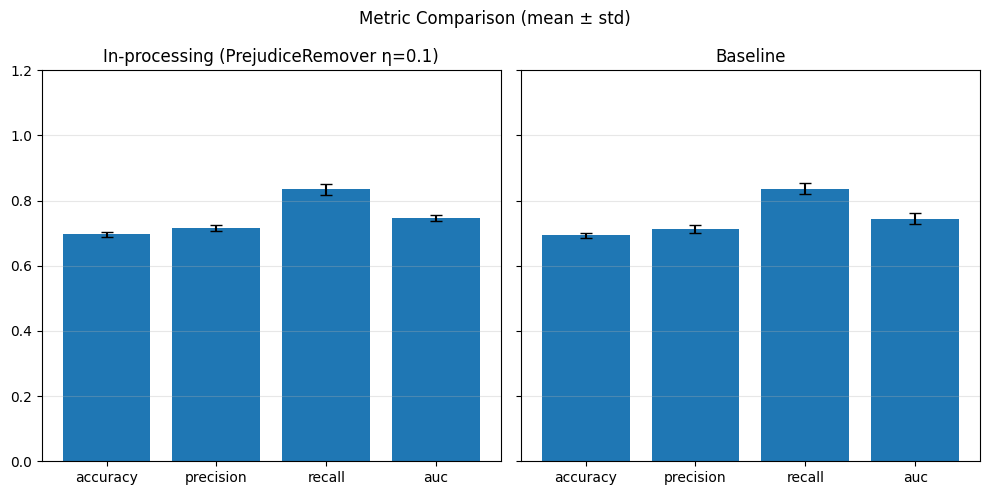

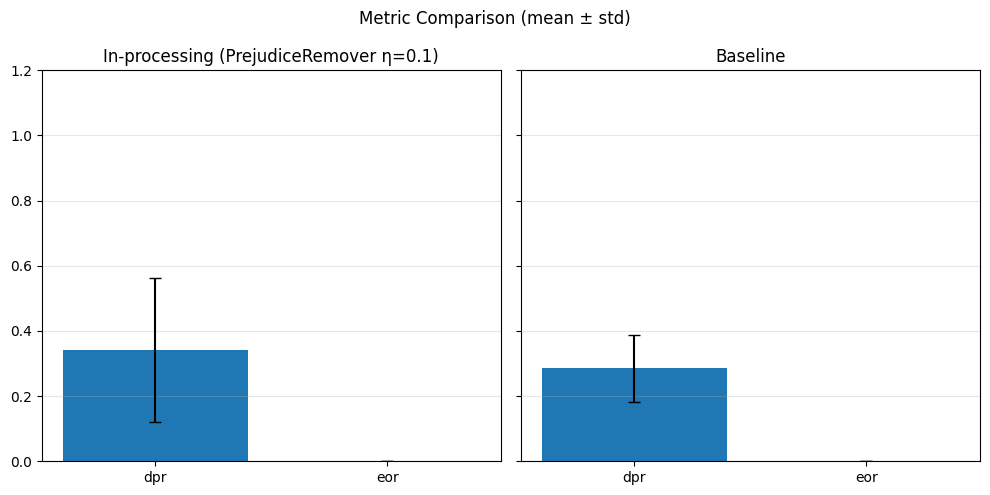

== Bar plot per η = 0.2 ==


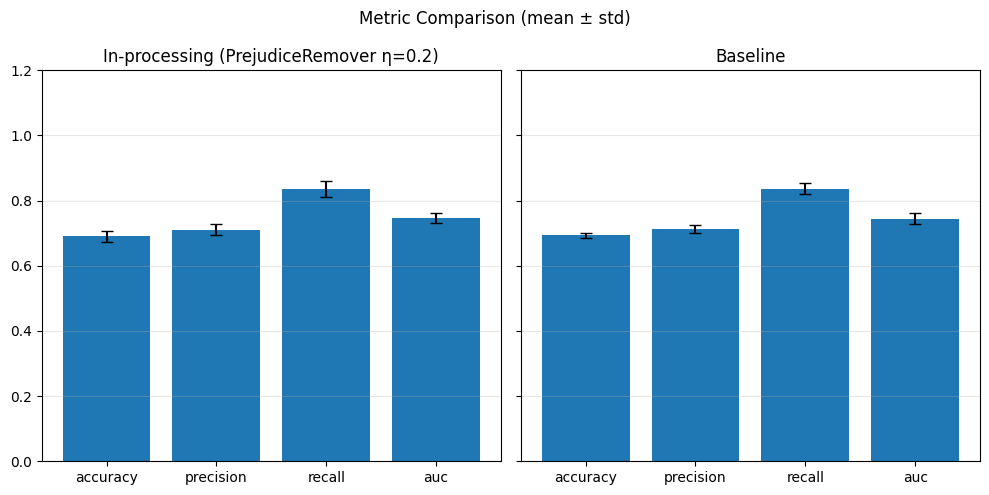

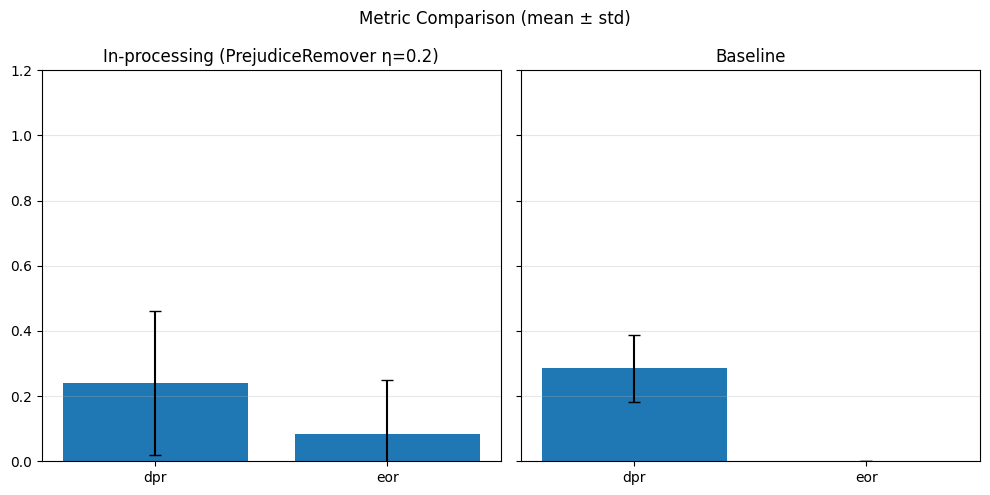

== Bar plot per η = 0.3 ==


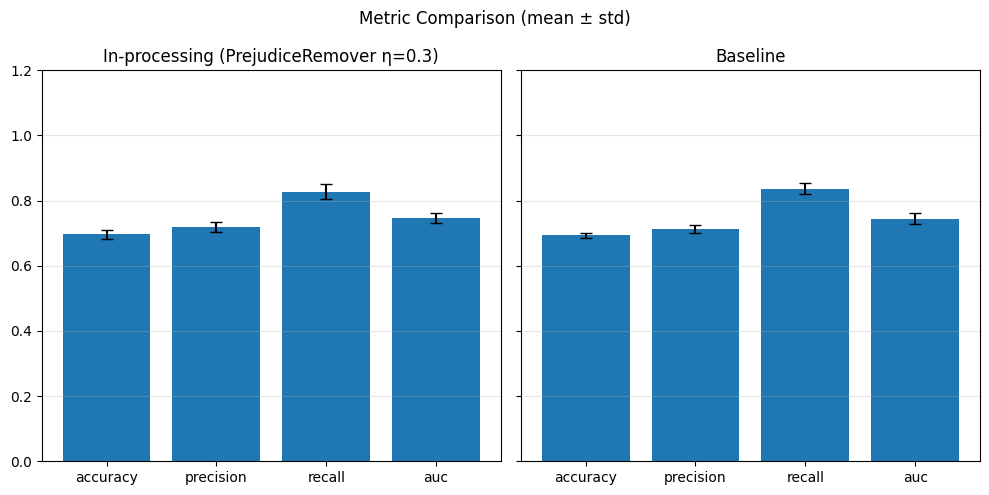

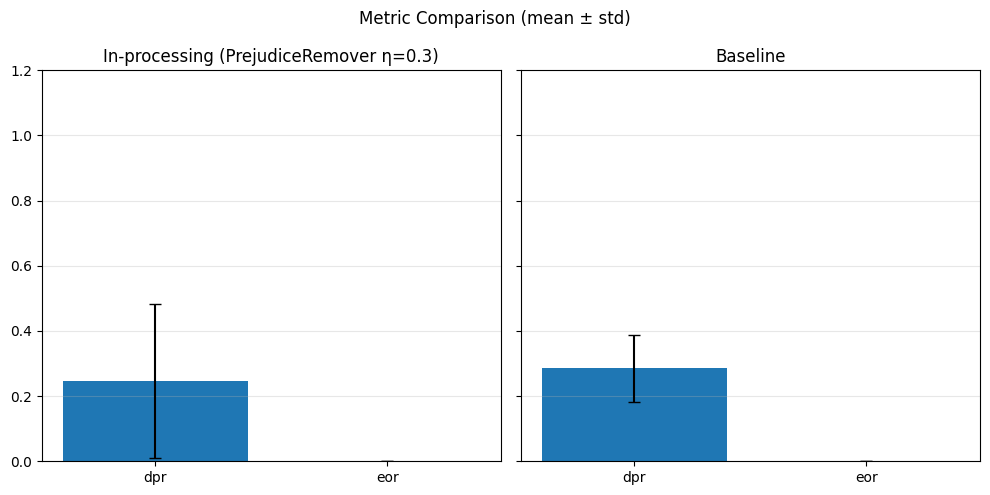

== Bar plot per η = 0.4 ==


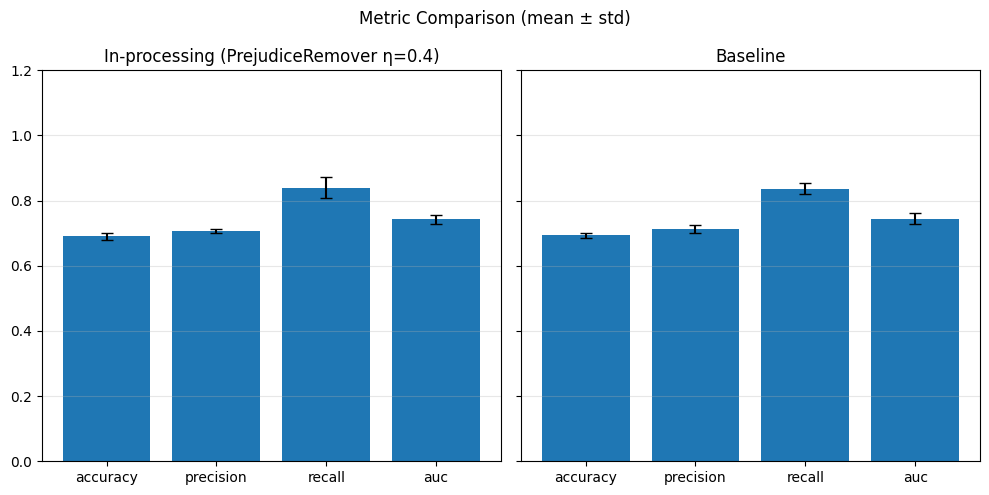

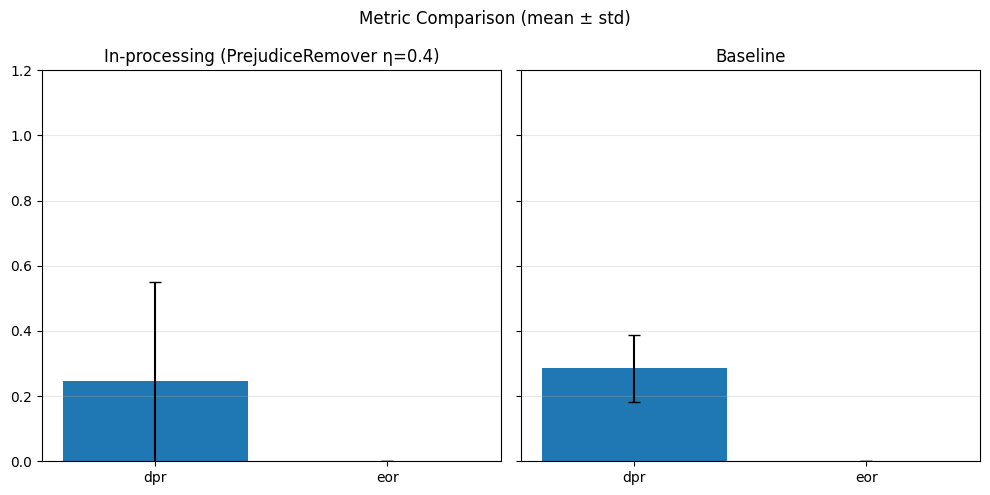

In [105]:
for i, eta in enumerate(etas[1:]):  
    print(f"== Bar plot per η = {eta} ==")

    # Performance metrics
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (PrejudiceRemover η={eta})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness metrics
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (PrejudiceRemover η={eta})",
        "Baseline",
        ["dpr", "eor"]
    )


The stratification was applied on the joint distribution of the target and sensitive feature, rather than explicitly balancing sensitive groups alone. This resulted in folds where minority sensitive groups were underrepresented or missing entirely, severely compromising both the training signal for fairness-aware algorithms and the reliability of fairness evaluation.

In contrast, when we stratified directly on the sensitive feature, each fold retained a more balanced representation of all groups, which significantly improved the performance of fairness-aware techniques for all methods

#### Results without using Cross-validation

In [116]:
def metrics_bar_plot(dict1, dict2, label1, label2, metrics, title="Metric Comparison (mean ± std)"):

    def summarise(fold_dicts):
        means = []
        stds = []
        for m in metrics:
            values = [fold.get(m, np.nan) for fold in fold_dicts]
            mean_val = np.nanmean(values)
            std_val = np.nanstd(values)
            means.append(mean_val)
            stds.append(std_val)
        return np.array(means), np.array(stds)

    mean1, std1 = summarise(dict1)
    mean2, std2 = summarise(dict2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    for ax, mean, std, label in zip(axes, [mean1, mean2], [std1, std2], [label1, label2]):
        ax.bar(metrics, mean, yerr=std, capsize=4)
        ax.set_title(label)
        ax.set_ylim(0, 1.2)  
        ax.grid(axis="y", alpha=0.3)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


##### Adversarial Debiasing

In [135]:
baseline_performance_metrics = []
baseline_fairness_metrics = []

inprocessing_performance_metrics = []
inprocessing_fairness_metrics = []

X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
numerical_cols = ['distance_km']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


In [136]:
X_train_dataframe = fl.DataFrame(X_train.copy())
X_train_dataframe.sensitive = sensitive_feature

baseline_model = AdversarialDebiasing(
    input_dim=X_train.shape[1],
    hidden_dim=8,
    output_dim=1,
    sensitive_dim=1,
    lambda_adv=0,  
)

baseline_model.fit(X_train, y_train)

X_test_dataframe = fl.DataFrame(X_test.copy())
X_test_dataframe.sensitive = sensitive_feature

y_pred_tensor = baseline_model.predict(X_test)
y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
y_pred_labels = (y_pred > 0.5).astype(int)

y_proba = y_pred  
perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
baseline_performance_metrics.append(perf_metrics)

# Fairness metrics
fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])
baseline_fairness_metrics.append(fair_metrics)

# SPD aggiuntivo (usando metodo fairlib)
spd = evaluate_spd(X_test.copy(), y_pred_labels)
baseline_spd_val = sum(abs(v) for v in spd.values()) / len(spd)
print(f"Baseline SPD (AdversarialDebiasing λ=0): {spd}")

Baseline SPD (AdversarialDebiasing λ=0): {(hired=0, grouped_regions=0.0): -0.06509136554843284, (hired=0, grouped_regions=1.0): -0.15620939647867432, (hired=0, grouped_regions=2.0): -0.04108483832929932, (hired=0, grouped_regions=3.0): 0.06928937247360778, (hired=0, grouped_regions=4.0): 0.10015131984531747, (hired=0, grouped_regions=5.0): 0.04179522135323241, (hired=1, grouped_regions=0.0): 0.06509136554843287, (hired=1, grouped_regions=1.0): 0.15620939647867438, (hired=1, grouped_regions=2.0): 0.04108483832929932, (hired=1, grouped_regions=3.0): -0.06928937247360778, (hired=1, grouped_regions=4.0): -0.10015131984531744, (hired=1, grouped_regions=5.0): -0.04179522135323244}


In [137]:
adv_weights = [0.1, 0.5, 1.0]
adv_spds = []
for lam in adv_weights:
    print(f"\n== Adversarial Debiasing con lambda_adv={lam} ==")

    X_tr = fl.DataFrame(X_train.copy())
    X_tr.sensitive = sensitive_feature

    X_te = fl.DataFrame(X_test.copy())
    X_te.sensitive = sensitive_feature

    model = AdversarialDebiasing(
        input_dim=X_train.shape[1],
        hidden_dim=8,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=lam,
    )

    model.fit(X_train, y_train)

    y_pred_tensor = model.predict(X_test)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_labels = (y_pred > 0.5).astype(int)
    y_proba = y_pred

    perf_metrics = compute_performance_metrics(y_test, y_pred_labels, y_proba)
    inprocessing_performance_metrics.append(perf_metrics)

    fair_metrics = compute_fairness_metrics(y_test, y_pred_labels, X_test[sensitive_feature])
    inprocessing_fairness_metrics.append(fair_metrics)

    spd = evaluate_spd(X_test.copy(), y_pred_labels)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)
    adv_spds.append(spd_val)
    print(f"SPD (λ={lam}): {spd}")


== Adversarial Debiasing con lambda_adv=0.1 ==
SPD (λ=0.1): {(hired=0, grouped_regions=0.0): 0.07181801630877435, (hired=0, grouped_regions=1.0): 0.1668298653610771, (hired=0, grouped_regions=2.0): -0.00909203748526033, (hired=0, grouped_regions=3.0): -0.020444154468034992, (hired=0, grouped_regions=4.0): -0.21145547273440565, (hired=0, grouped_regions=5.0): -0.12100882542871494, (hired=1, grouped_regions=0.0): -0.07181801630877438, (hired=1, grouped_regions=1.0): -0.16682986536107713, (hired=1, grouped_regions=2.0): 0.00909203748526033, (hired=1, grouped_regions=3.0): 0.020444154468035047, (hired=1, grouped_regions=4.0): 0.21145547273440568, (hired=1, grouped_regions=5.0): 0.12100882542871494}

== Adversarial Debiasing con lambda_adv=0.5 ==
SPD (λ=0.5): {(hired=1, grouped_regions=0.0): 0.0, (hired=1, grouped_regions=1.0): 0.0, (hired=1, grouped_regions=2.0): 0.0, (hired=1, grouped_regions=3.0): 0.0, (hired=1, grouped_regions=4.0): 0.0, (hired=1, grouped_regions=5.0): 0.0}

== Adversa

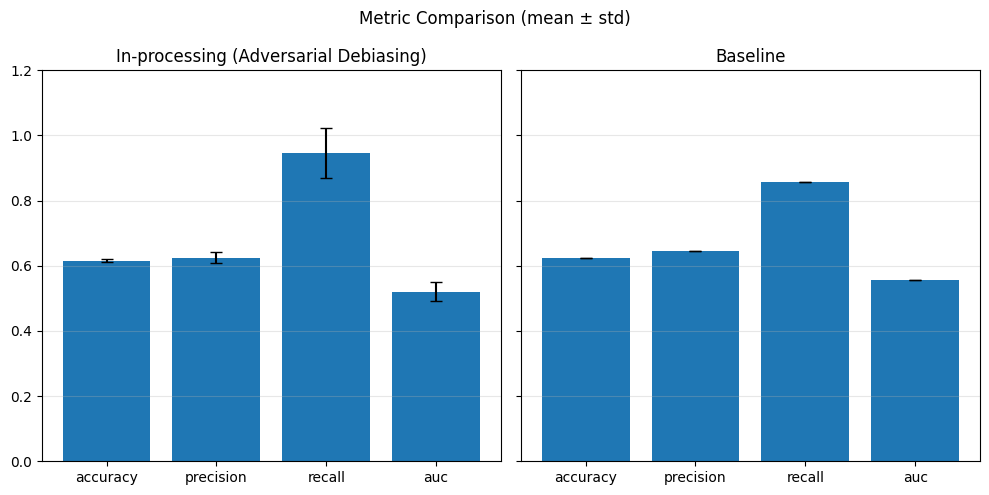

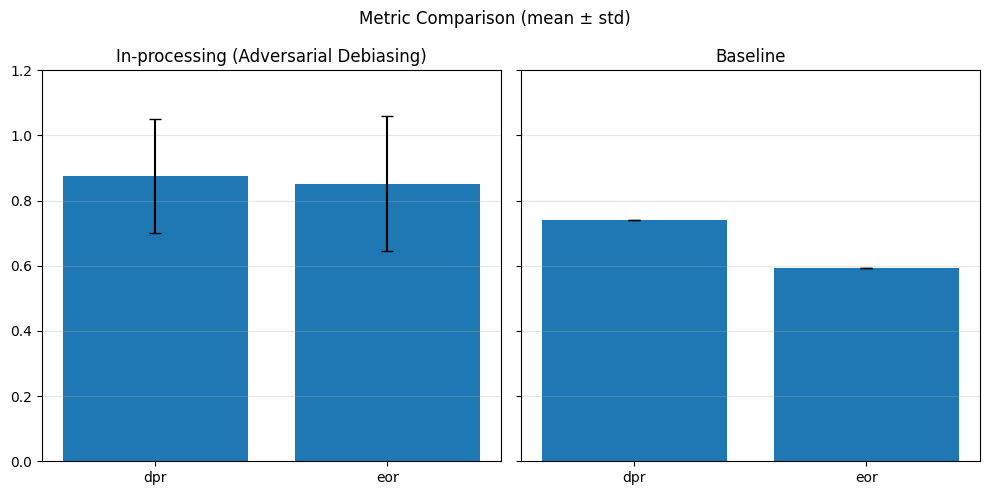

In [138]:
metrics_bar_plot(
    inprocessing_performance_metrics, 
    baseline_performance_metrics, 
    "In-processing (Adversarial Debiasing)", 
    "Baseline", 
    ["accuracy", "precision", "recall", "auc"]
)

metrics_bar_plot(
    inprocessing_fairness_metrics, 
    baseline_fairness_metrics, 
    "In-processing (Adversarial Debiasing)", 
    "Baseline", 
    ["dpr", "eor"]
)

##### FaUCI

In [128]:
X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
numerical_cols = ['distance_km']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


In [129]:
lambdas = [0.0, 0.1, 0.2, 0.3, 0.4]
baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in lambdas[1:]]
inprocessing_fairness_metrics = [[] for _ in lambdas[1:]]
fauci_spd_vals = []

epochs = 100
batch_size = 128
input_dim = X_train.shape[1]

for lam in lambdas:
    print(f"\n== FaUCI training with λ = {lam} ==")

    model = Simple_NN(input_dim=input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    fauci_model = fl.Fauci(
        torchModel=model,
        optimizer=optimizer,
        loss=nn.BCELoss(),
        fairness_regularization="spd",
        regularization_weight=lam
    )

    # Prepara fairlib DataFrame
    train_data = fl.DataFrame(X_train.copy())
    train_data[target] = y_train.values
    train_data.targets = target
    train_data.sensitive = sensitive_feature

    test_data = fl.DataFrame(X_test.copy())
    test_data[target] = y_test.values
    test_data.targets = target
    test_data.sensitive = sensitive_feature

    # Training
    fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

    # Predizione
    model.eval()
    with torch.no_grad():
        y_pred_tensor = fauci_model.predict(torch.tensor(X_test.values, dtype=torch.float32))
        y_pred = y_pred_tensor.cpu().numpy().flatten()
        y_pred_bin = (y_pred > 0.5).astype(int)

    # Valutazione
    perf_metrics = compute_performance_metrics(y_test, y_pred_bin, y_pred)
    fair_metrics = compute_fairness_metrics(y_test, y_pred_bin, X_test[sensitive_feature])
    spd = evaluate_spd(X_test.copy(), y_pred_bin)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)

    if lam == 0.0:
        baseline_performance_metrics.append(perf_metrics)
        baseline_fairness_metrics.append(fair_metrics)
        baseline_spd_val = spd_val
        print(f"[Baseline] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")
    else:
        idx = lambdas.index(lam) - 1  
        inprocessing_performance_metrics[idx].append(perf_metrics)
        inprocessing_fairness_metrics[idx].append(fair_metrics)
        fauci_spd_vals.append(spd_val)
        print(f"[λ={lam}] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")



== FaUCI training with λ = 0.0 ==
[Baseline] Accuracy: 0.6827, SPD: 0.1008

== FaUCI training with λ = 0.1 ==
[λ=0.1] Accuracy: 0.6933, SPD: 0.0973

== FaUCI training with λ = 0.2 ==
[λ=0.2] Accuracy: 0.6608, SPD: 0.0793

== FaUCI training with λ = 0.3 ==
[λ=0.3] Accuracy: 0.6131, SPD: 0.0591

== FaUCI training with λ = 0.4 ==
[λ=0.4] Accuracy: 0.5540, SPD: 0.0458



== Bar plot per λ = 0.1 (FaUCI) ==


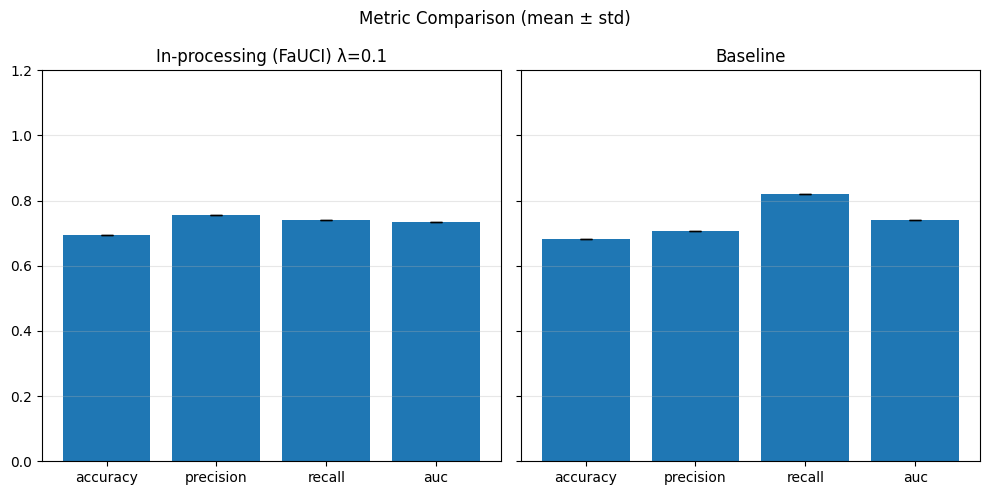

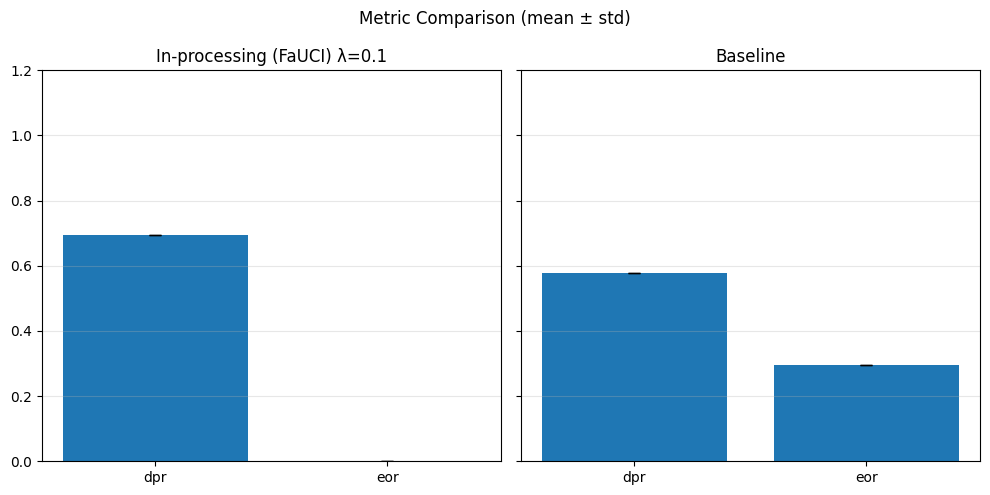


== Bar plot per λ = 0.2 (FaUCI) ==


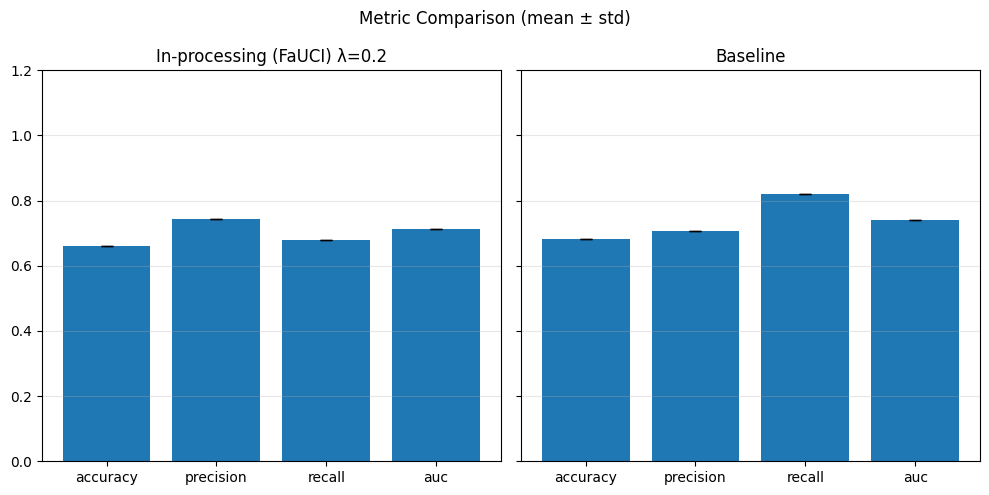

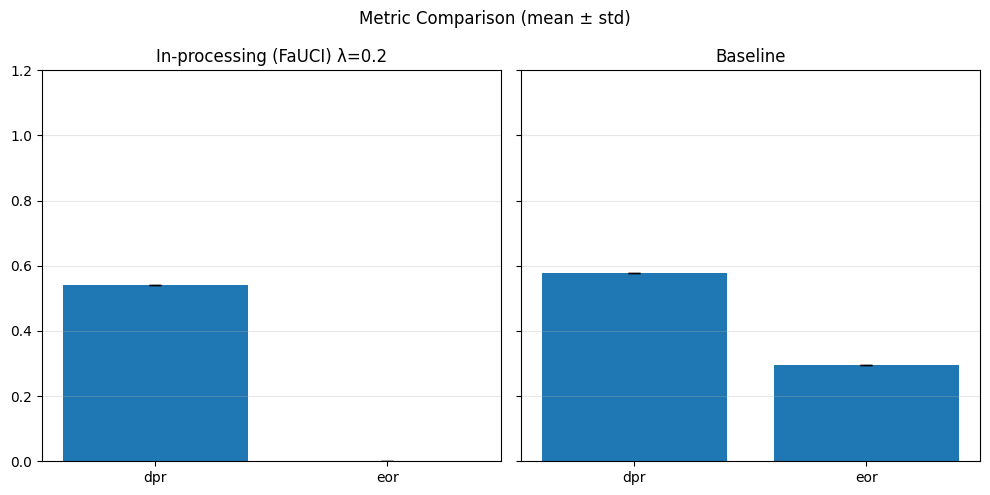


== Bar plot per λ = 0.3 (FaUCI) ==


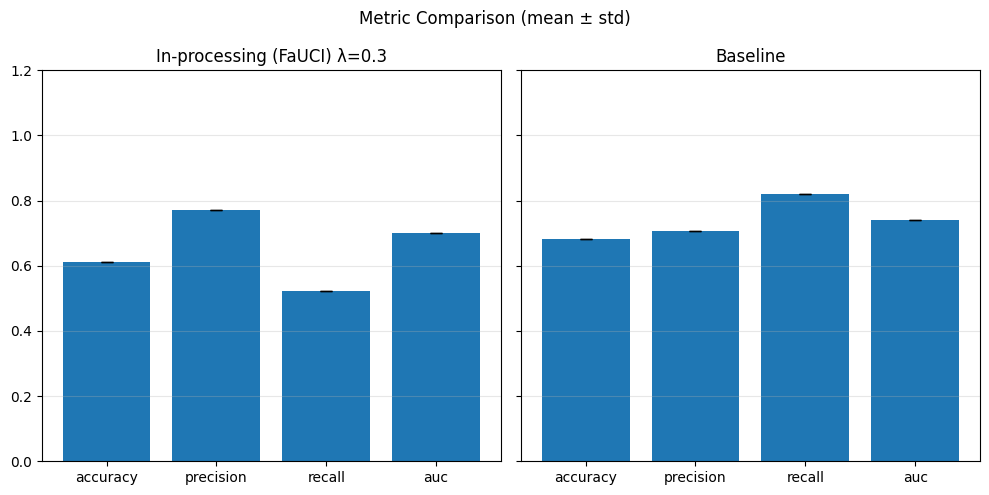

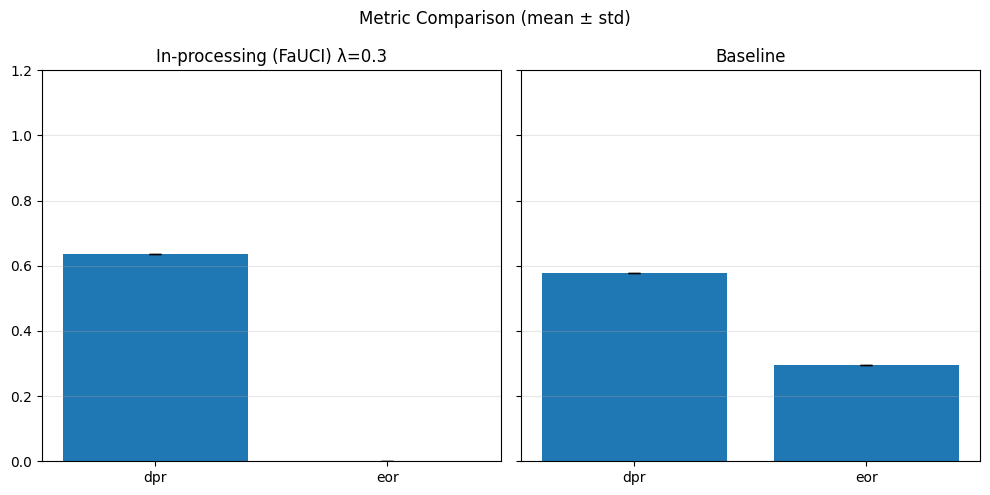


== Bar plot per λ = 0.4 (FaUCI) ==


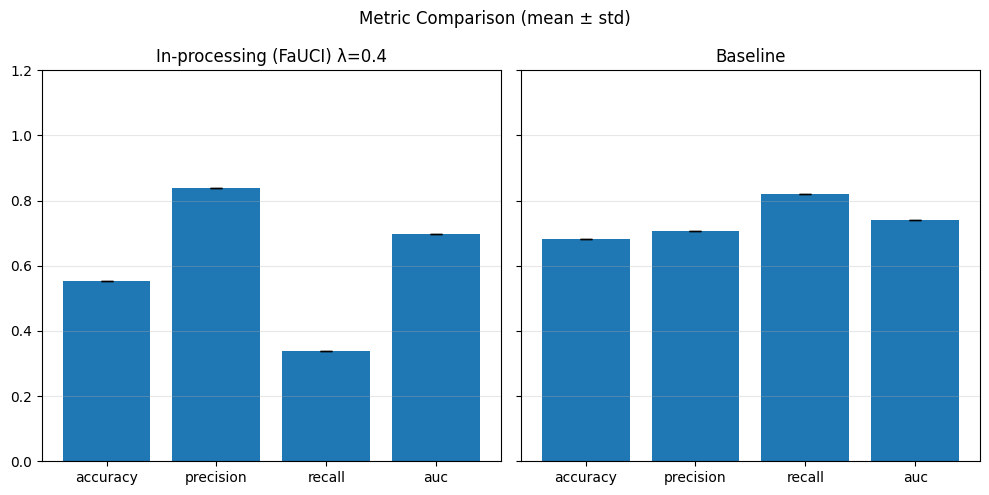

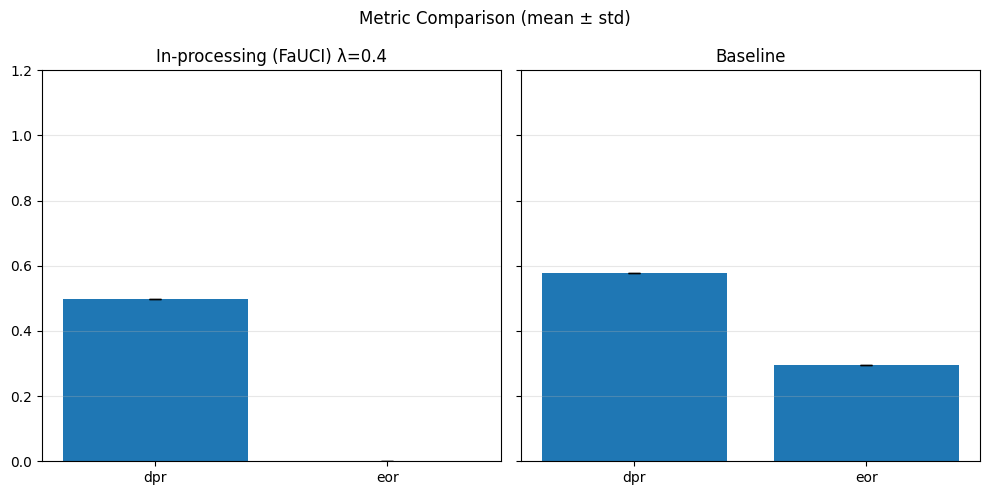

In [130]:
for i, lam in enumerate(lambdas[1:]): 
    print(f"\n== Bar plot per λ = {lam} (FaUCI) ==")

    metrics_bar_plot(
        inprocessing_performance_metrics[i],
        baseline_performance_metrics,
        f"In-processing (FaUCI) λ={lam}",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    metrics_bar_plot(
        inprocessing_fairness_metrics[i],
        baseline_fairness_metrics,
        f"In-processing (FaUCI) λ={lam}",
        "Baseline",
        ["dpr", "eor"]
    )


##### Prejudice Removal

In [ ]:
X = df1.drop(columns=target)
y = df1[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
numerical_cols = ['distance_km']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (5964, 9)
Testing set shape: (2556, 9)


In [126]:
etas = [0.0, 0.1, 0.2, 0.3, 0.4]
baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in etas[1:]]
inprocessing_fairness_metrics = [[] for _ in etas[1:]]
pr_spd_vals = []
epochs = 100
batch_size = 128
input_dim = X_train.shape[1]

for eta in etas:
    print(f"\n== PrejudiceRemover training with eta: {eta} ==")

    model = Simple_NN(input_dim)
    pr_model = fl.PrejudiceRemover(model, loss=nn.BCELoss(), eta=eta)

    # Prepara fairlib DataFrame
    train_data = fl.DataFrame(X_train.copy())
    train_data[target] = y_train.values
    train_data.targets = target
    train_data.sensitive = sensitive_feature

    test_data = fl.DataFrame(X_test.copy())
    test_data[target] = y_test.values
    test_data.targets = target
    test_data.sensitive = sensitive_feature

    # Training
    pr_model.fit(train_data, epochs=epochs, batch_size=batch_size)

    # Valutazione
    target_col = list(test_data.targets)[0]
    sensitive_col = list(test_data.sensitive)[0]
    X_test_df = test_data.drop(columns=target_col)
    y_true = test_data[target_col].to_numpy()

    y_pred_tensor = pr_model.predict(X_test_df)
    y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Performance
    perf_metrics = compute_performance_metrics(y_true, y_pred_bin, y_pred)

    # Fairness
    fair_metrics = compute_fairness_metrics(y_true, y_pred_bin, X_test_df[sensitive_col])

    # SPD
    spd = evaluate_spd(X_test_df.copy(), y_pred_bin)
    spd_val = sum(abs(v) for v in spd.values()) / len(spd)

    if eta == 0.0:
        baseline_performance_metrics.append(perf_metrics)
        baseline_fairness_metrics.append(fair_metrics)
        baseline_spd_val = spd_val
    else:
        idx = etas.index(eta) - 1  # Shift because baseline (eta=0) is excluded
        inprocessing_performance_metrics[idx].append(perf_metrics)
        inprocessing_fairness_metrics[idx].append(fair_metrics)
        pr_spd_vals.append(spd_val)



== PrejudiceRemover training with eta: 0.0 ==

== PrejudiceRemover training with eta: 0.1 ==

== PrejudiceRemover training with eta: 0.2 ==

== PrejudiceRemover training with eta: 0.3 ==

== PrejudiceRemover training with eta: 0.4 ==


== Bar plot per η = 0.1 ==


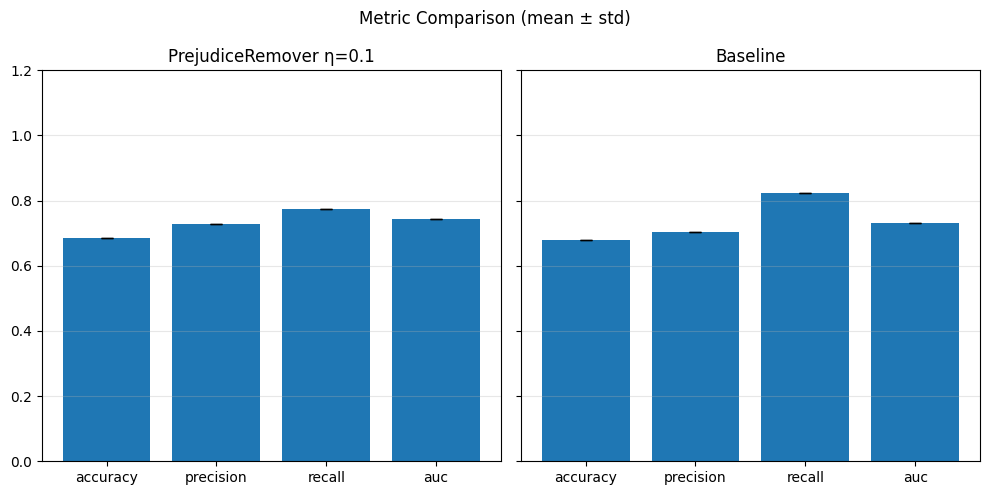

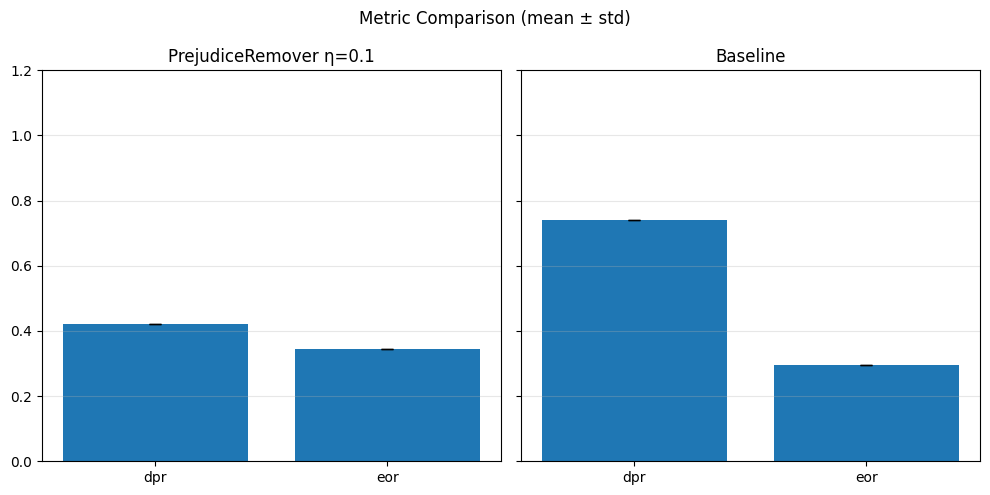

== Bar plot per η = 0.2 ==


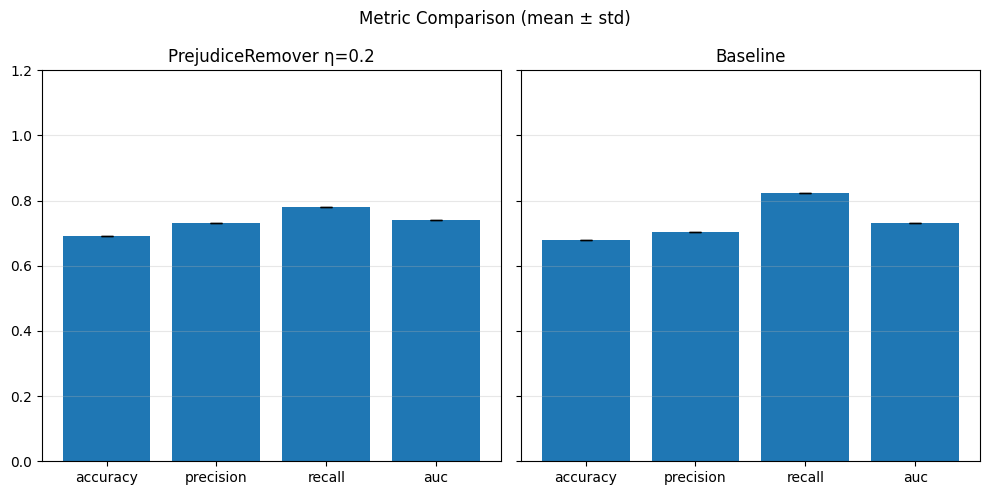

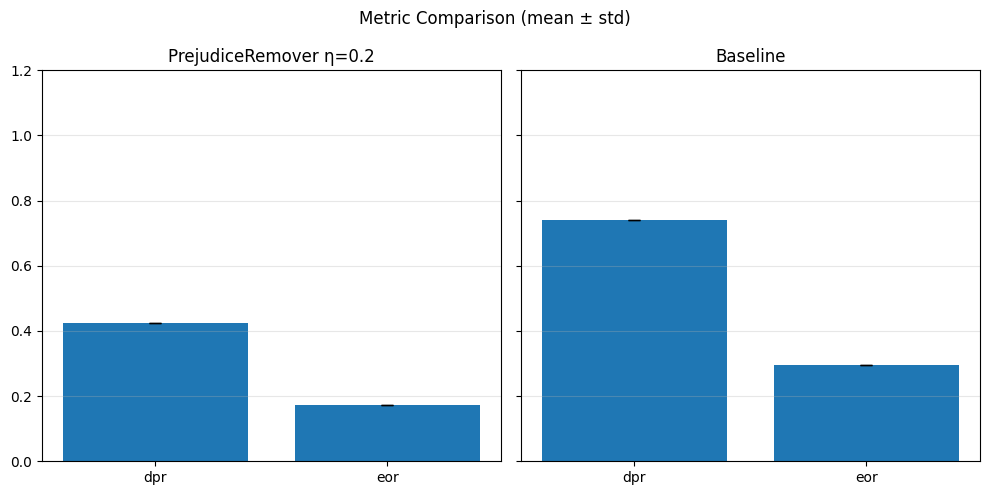

== Bar plot per η = 0.3 ==


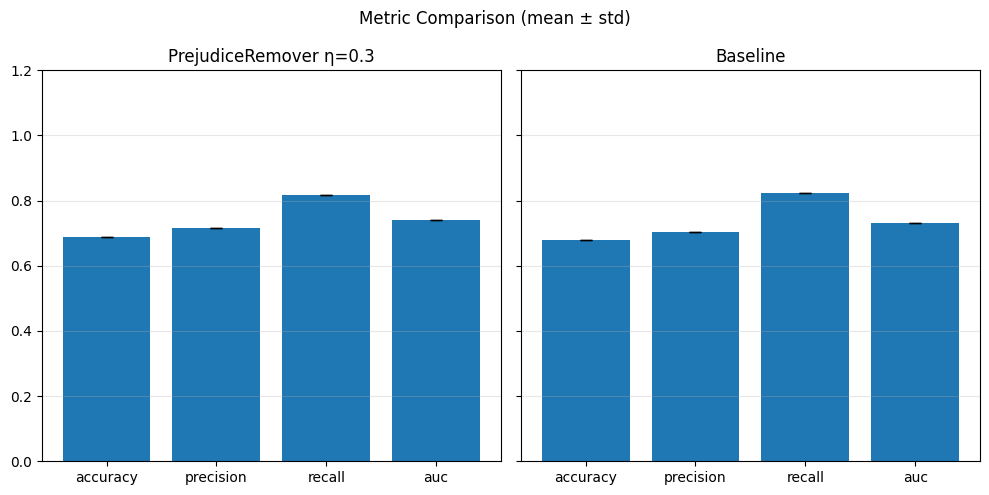

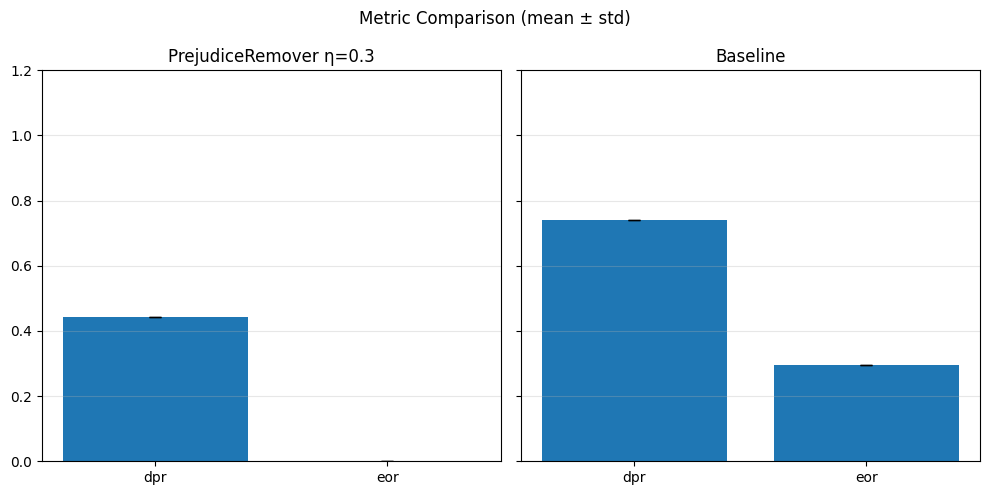

== Bar plot per η = 0.4 ==


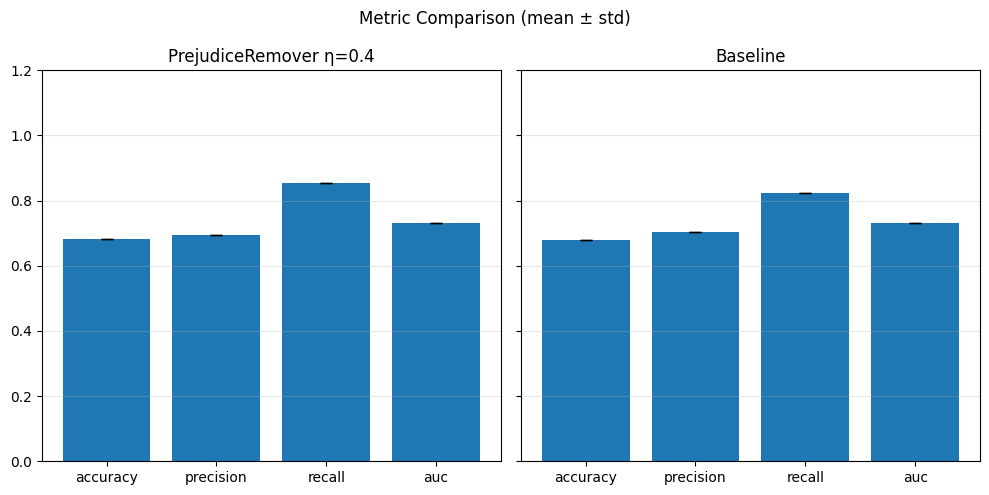

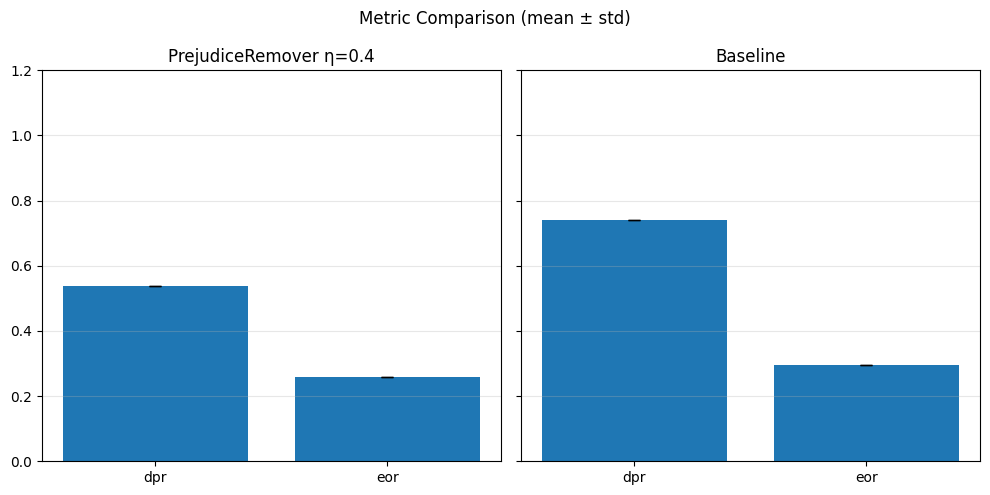

In [127]:
for i, eta in enumerate(etas[1:]):
    print(f"== Bar plot per η = {eta} ==")
    metrics_bar_plot(
        inprocessing_performance_metrics[i],
        baseline_performance_metrics,
        f"PrejudiceRemover η={eta}",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    metrics_bar_plot(
        inprocessing_fairness_metrics[i],
        baseline_fairness_metrics,
        f"PrejudiceRemover η={eta}",
        "Baseline",
        ["dpr", "eor"]
    )


#### Results duplicating positive samples

In [ ]:
import random as rnd
pos = df1[(df1[sensitive_feature] == 4) & df1[target] == 1].copy()
for i in range(6):
    df1.loc[-1] = pos.sample().iloc[0]      
    df1.index = df1.index + 1 
    df1 = df1.sort_index() 

##### FaUCI

In [ ]:
k = 5  
reg_weights = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs = 100
batch_size = 128
fauci_spd_vals = []

baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in reg_weights if _ != 0.0]
inprocessing_fairness_metrics = [[] for _ in reg_weights if _ != 0.0]


X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, weight in enumerate(reg_weights):
    print(f"\n== FaUCI training with regularization weight: {weight} ==")
    fold_spds = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[sensitive_feature].astype(str))):
        print(f"  Fold {fold + 1}/{k}")

        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]

        input_dim = X.shape[1]
        X_test_tensor = torch.tensor(X_test_fold.values, dtype=torch.float32)

        model = Simple_NN(input_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        fauci_model = fl.Fauci(
            torchModel=model,
            optimizer=optimizer,
            loss=nn.BCELoss(),
            fairness_regularization="spd",
            regularization_weight=weight
        )

        # Prepara dati fairlib
        train_data = fl.DataFrame(X_train_fold)
        train_data[target] = y_train_fold.values
        train_data.targets = target
        train_data.sensitive = sensitive_feature

        # Fit
        fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

        # Predict
        model.eval()
        with torch.no_grad():
            y_pred_tensor = fauci_model.predict(X_test_tensor)
            y_pred = y_pred_tensor.cpu().numpy().flatten()
            y_pred_labels = (y_pred > 0.5).astype(int)

        # Metrics
        perf_metrics = compute_performance_metrics(y_test_fold, y_pred_labels, y_pred)
        fair_metrics = compute_fairness_metrics(y_test_fold, y_pred_labels, X_test_fold[sensitive_feature])
        spd = evaluate_spd(X_test_fold.copy(), y_pred_labels)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)

        # Salva
        if weight == 0.0:
            baseline_performance_metrics.append(perf_metrics)
            baseline_fairness_metrics.append(fair_metrics)
            if fold == 0:
                baseline_spd_val = spd_val
        else:
            inprocessing_performance_metrics[i - 1].append(perf_metrics)
            inprocessing_fairness_metrics[i - 1].append(fair_metrics)
            fold_spds.append(spd_val)

    if weight != 0.0:
        mean_spd = np.mean(fold_spds)
        fauci_spd_vals.append(mean_spd)
        print(f"[λ={weight}] Mean SPD: {mean_spd:.4f}")


== FaUCI training with regularization weight: 0.0 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

== FaUCI training with regularization weight: 0.1 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.1] Mean SPD: 0.0797

== FaUCI training with regularization weight: 0.2 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.2] Mean SPD: 0.0690

== FaUCI training with regularization weight: 0.3 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.3] Mean SPD: 0.0883

== FaUCI training with regularization weight: 0.4 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[λ=0.4] Mean SPD: 0.0929


== Bar plot per λ = 0.1 ==


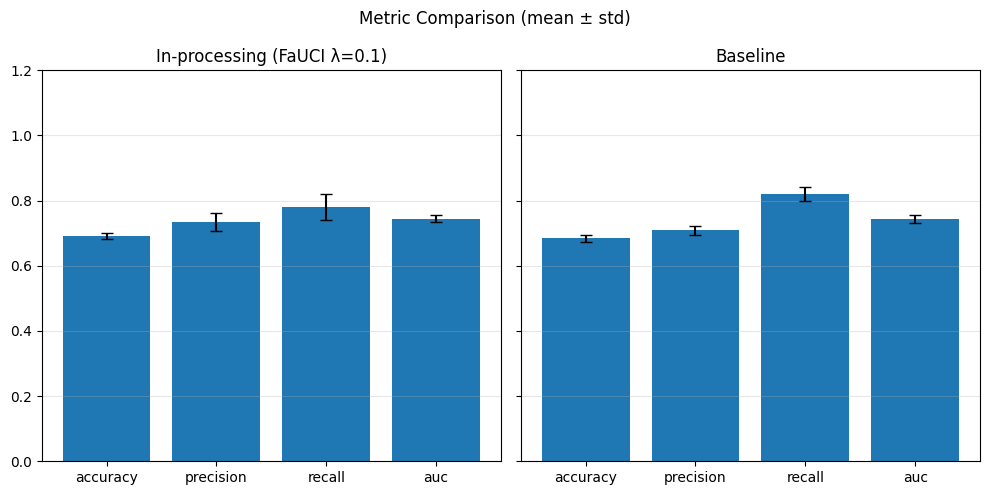

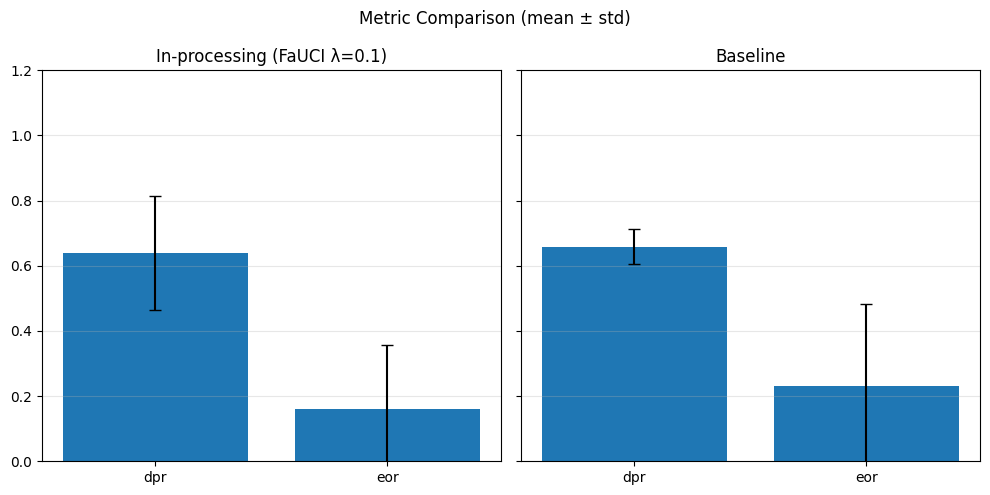

== Bar plot per λ = 0.2 ==


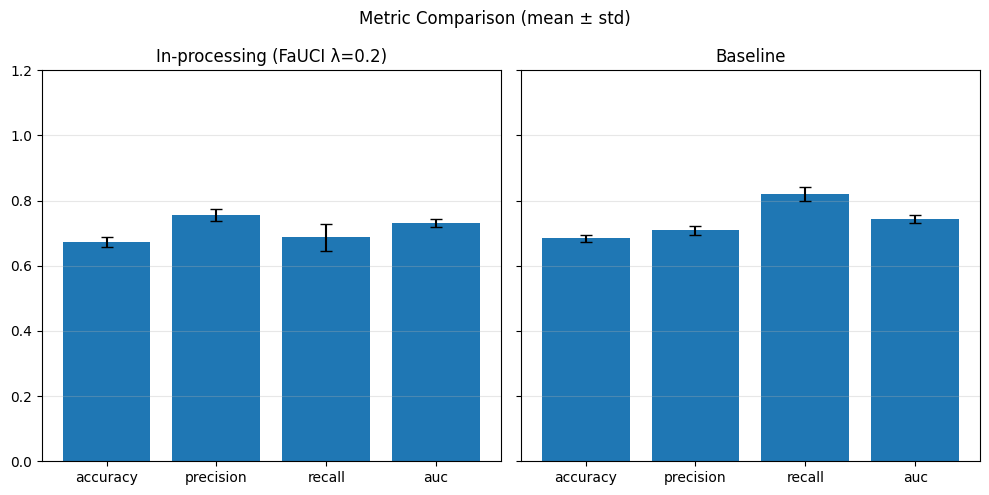

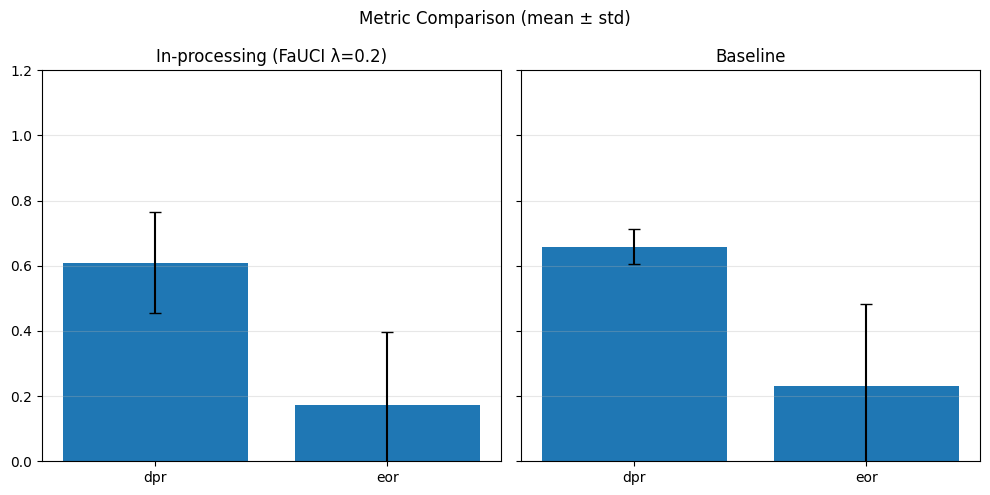

== Bar plot per λ = 0.3 ==


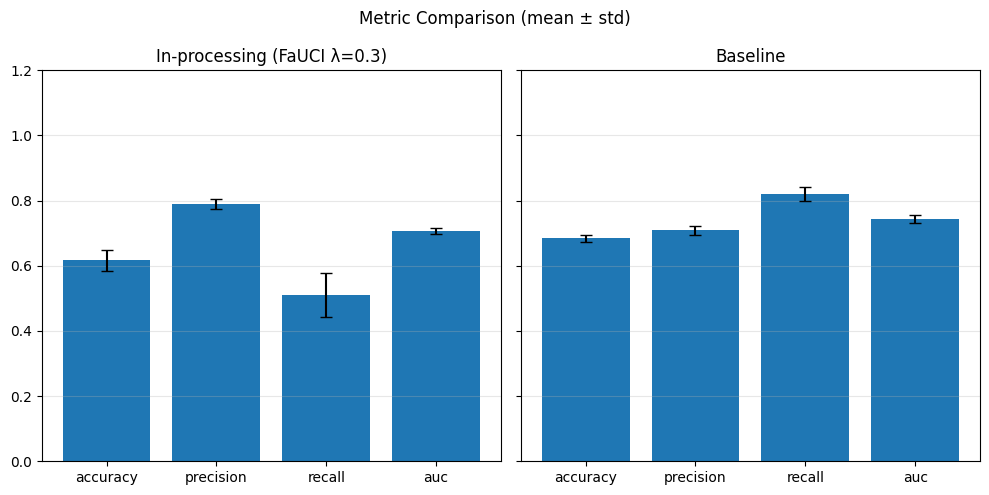

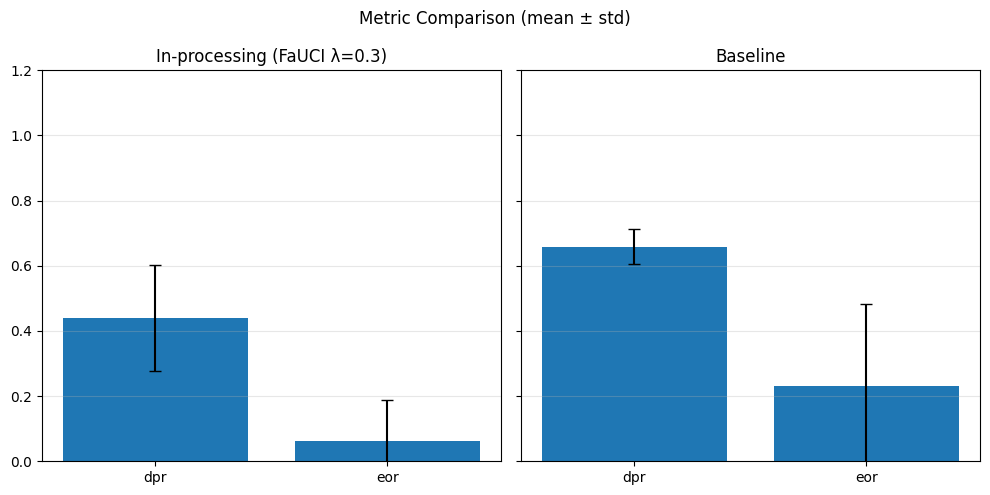

== Bar plot per λ = 0.4 ==


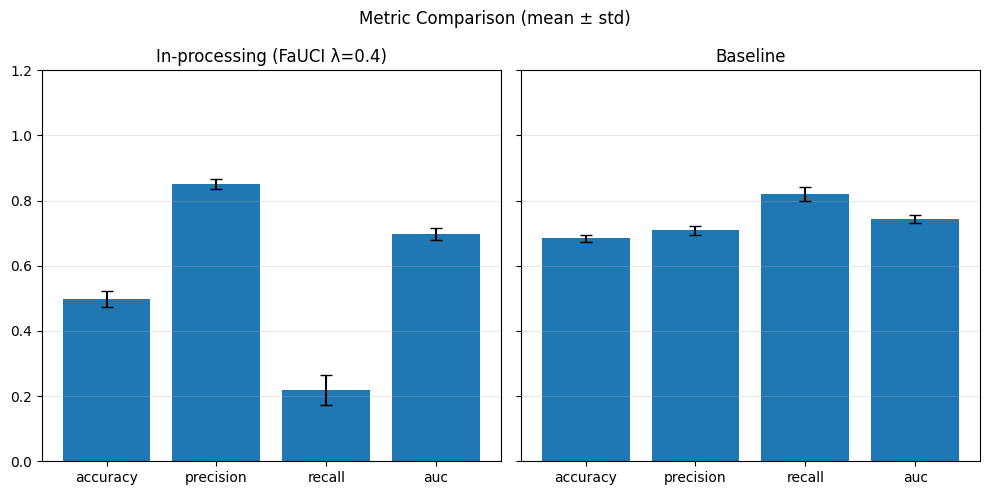

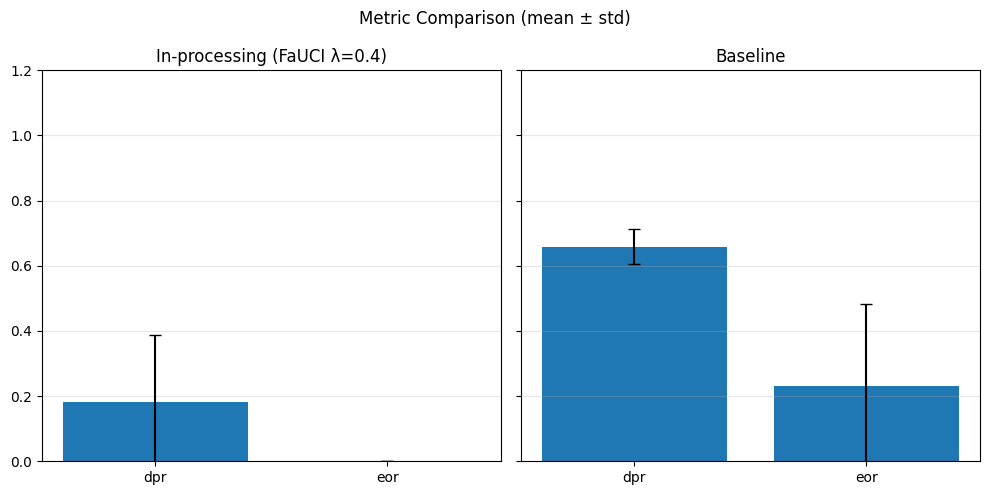

In [ ]:
for i, lam in enumerate(reg_weights[1:]):  # Salta λ=0.0 perché è il baseline
    print(f"== Bar plot per λ = {lam} ==")

    # Performance metrics
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (FaUCI λ={lam})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness metrics
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (FaUCI λ={lam})",
        "Baseline",
        ["dpr", "eor"]
    )


##### Prejudice Removal

In [ ]:
k = 5  
etas = [0.0, 0.1, 0.2, 0.3, 0.4]
epochs = 100
batch_size = 128
pr_spd_vals = []

baseline_performance_metrics = []
baseline_fairness_metrics = []
inprocessing_performance_metrics = [[] for _ in etas if _ != 0.0]
inprocessing_fairness_metrics = [[] for _ in etas if _ != 0.0]


X = df1.drop(columns=target)
y = df1[target]

scaler = StandardScaler()
numerical_cols = ['distance_km']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for i, eta in enumerate(etas):
    print(f"\n== PrejudiceRemover training with eta: {eta} ==")
    fold_spds = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, df1[sensitive_feature].astype(str))):
        print(f"  Fold {fold + 1}/{k}")

        X_train_fold = X.iloc[train_index]
        X_test_fold = X.iloc[test_index]
        y_train_fold = y.iloc[train_index]
        y_test_fold = y.iloc[test_index]

        input_dim = X.shape[1]

        model = Simple_NN(input_dim)
        pr_model = fl.PrejudiceRemover(model, loss=nn.BCELoss(), eta=eta)

        # Prepara dati fairlib
        train_data = fl.DataFrame(X_train_fold)
        train_data[target] = y_train_fold.values
        train_data.targets = target
        train_data.sensitive = sensitive_feature

        test_data = fl.DataFrame(X_test_fold)
        test_data[target] = y_test_fold.values
        test_data.targets = target
        test_data.sensitive = sensitive_feature

        # Fit
        pr_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

        # Predict
        target_col = list(test_data.targets)[0]
        sensitive_col = list(test_data.sensitive)[0]
        X_test_df = test_data.drop(columns=target_col)
        y_true = test_data[target_col].to_numpy()

        y_pred_tensor = pr_model.predict(X_test_df)
        y_pred = y_pred_tensor.detach().cpu().numpy().flatten()
        y_pred_bin = (y_pred > 0.5).astype(int)

        # Metrics
        perf_metrics = compute_performance_metrics(y_true, y_pred_bin, y_pred)
        fair_metrics = compute_fairness_metrics(y_true, y_pred_bin, X_test_df[sensitive_col])
        spd = evaluate_spd(X_test_df.copy(), y_pred_bin)
        spd_val = sum(abs(v) for v in spd.values()) / len(spd)

        # Salva
        if eta == 0.0:
            baseline_performance_metrics.append(perf_metrics)
            baseline_fairness_metrics.append(fair_metrics)
            if fold == 0:
                baseline_spd_val = spd_val
            print(f"[Baseline] Accuracy: {perf_metrics['accuracy']:.4f}, SPD: {spd_val:.4f}")
        else:
            inprocessing_performance_metrics[i - 1].append(perf_metrics)
            inprocessing_fairness_metrics[i - 1].append(fair_metrics)
            fold_spds.append(spd_val)

    if eta != 0.0:
        mean_spd = np.mean(fold_spds)
        pr_spd_vals.append(mean_spd)
        print(f"[η={eta}] Mean SPD: {mean_spd:.4f}")


== PrejudiceRemover training with eta: 0.0 ==
  Fold 1/5
[Baseline] Accuracy: 0.6784, SPD: 0.0782
  Fold 2/5
[Baseline] Accuracy: 0.6784, SPD: 0.1147
  Fold 3/5
[Baseline] Accuracy: 0.6789, SPD: 0.0686
  Fold 4/5
[Baseline] Accuracy: 0.7088, SPD: 0.0670
  Fold 5/5
[Baseline] Accuracy: 0.7058, SPD: 0.1072

== PrejudiceRemover training with eta: 0.1 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.1] Mean SPD: 0.0901

== PrejudiceRemover training with eta: 0.2 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.2] Mean SPD: 0.0986

== PrejudiceRemover training with eta: 0.3 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.3] Mean SPD: 0.0957

== PrejudiceRemover training with eta: 0.4 ==
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
[η=0.4] Mean SPD: 0.0918


== Bar plot per η = 0.1 ==


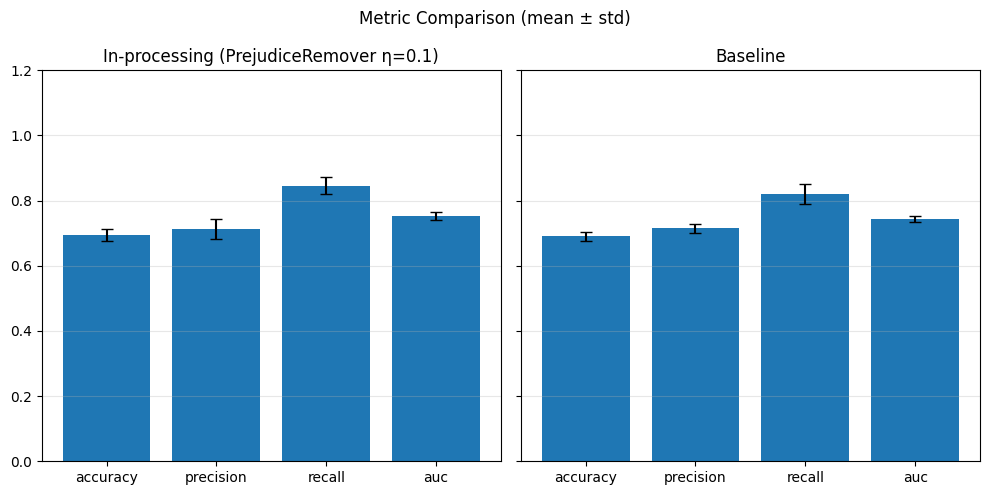

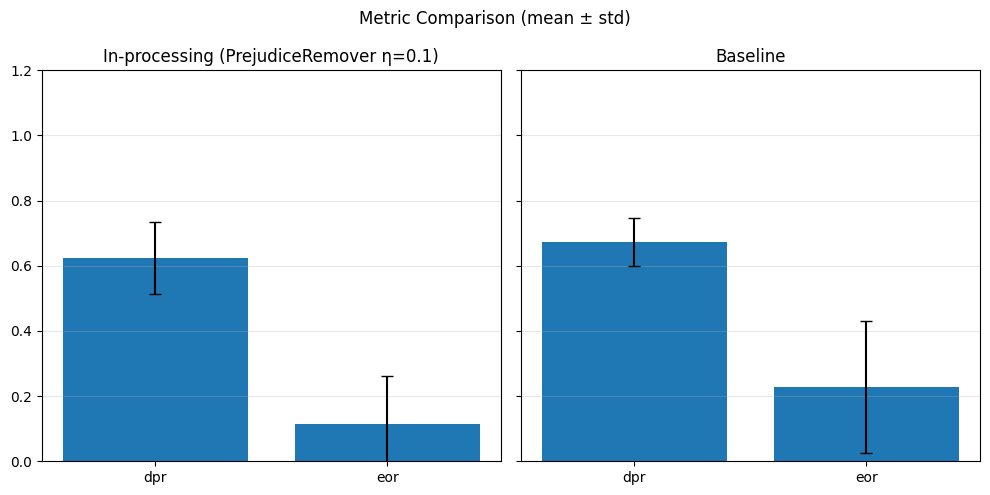

== Bar plot per η = 0.2 ==


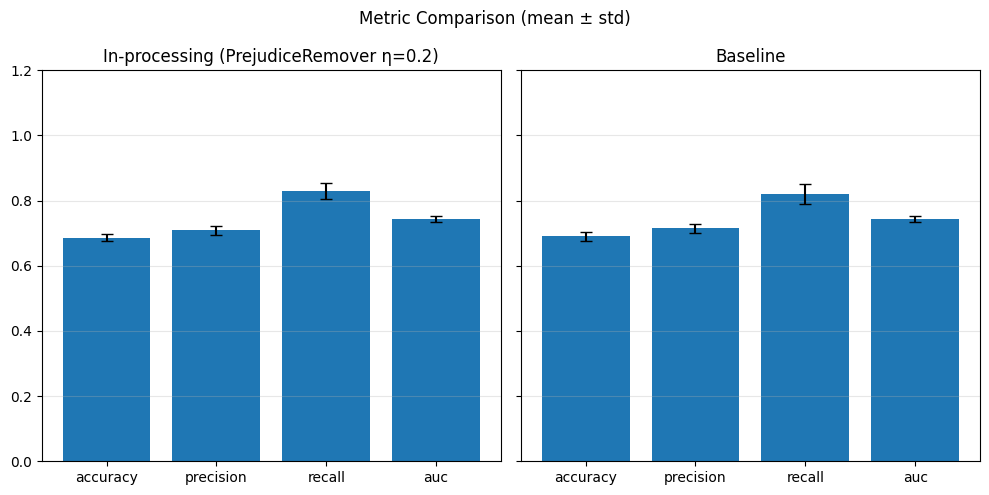

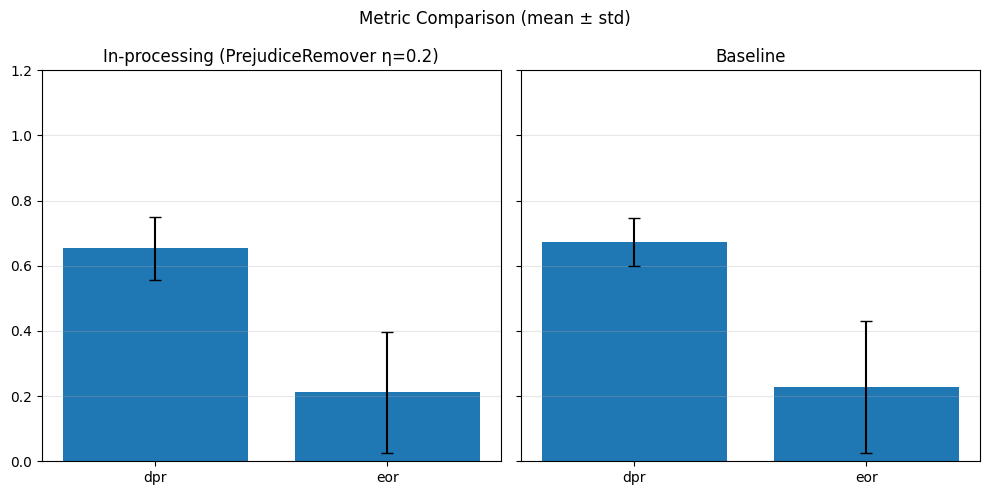

== Bar plot per η = 0.3 ==


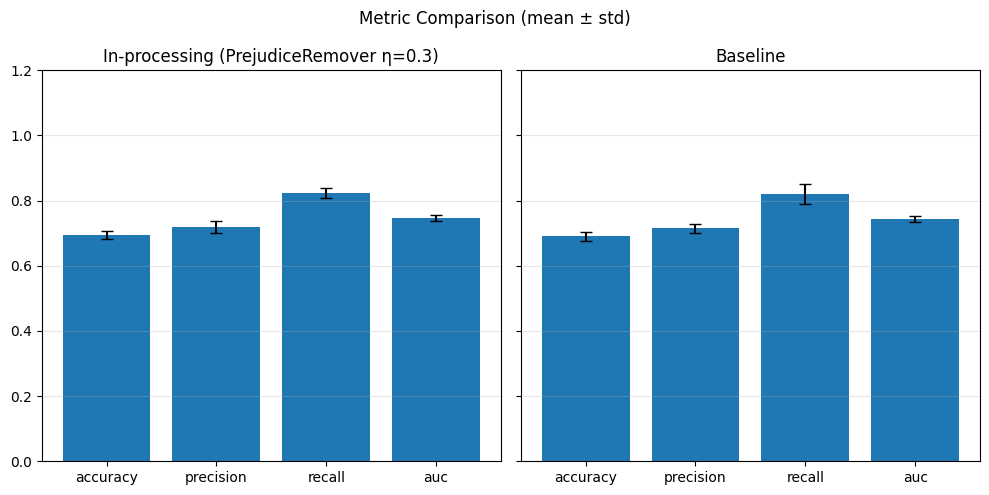

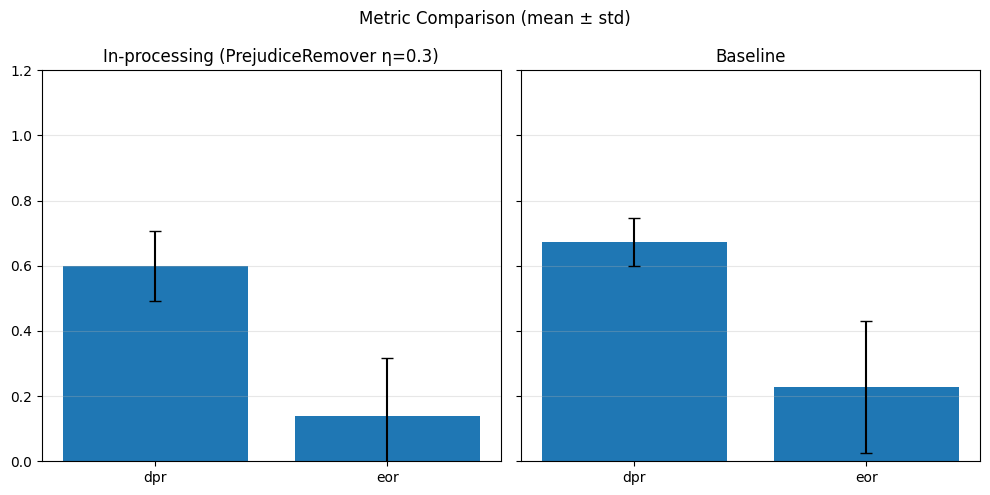

== Bar plot per η = 0.4 ==


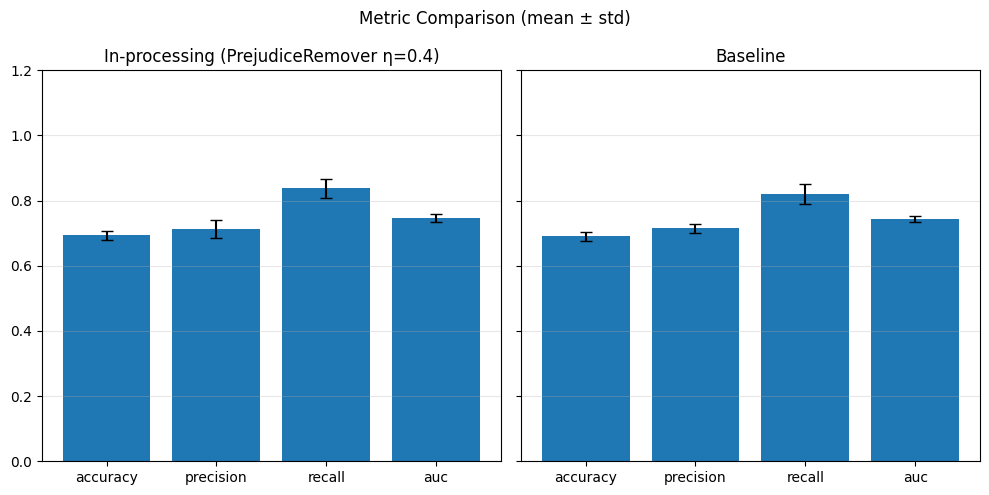

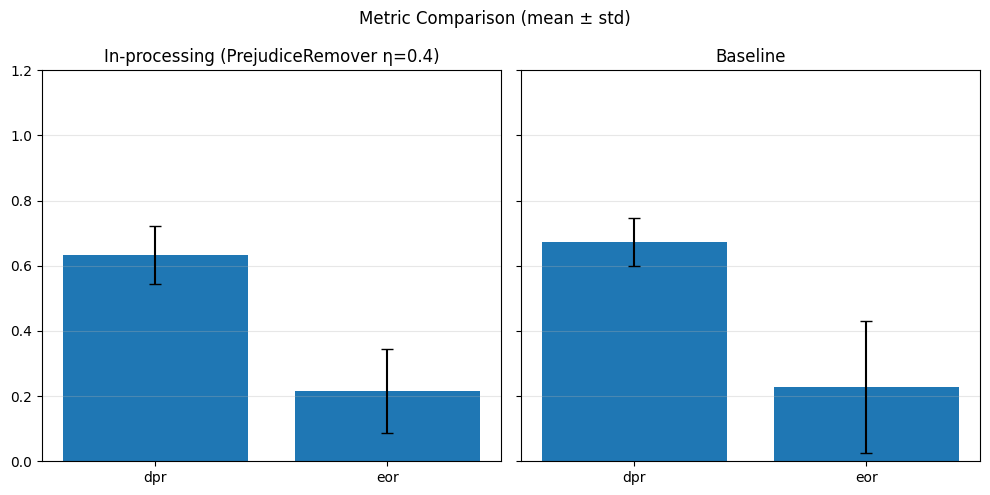

In [ ]:
for i, eta in enumerate(etas[1:]):  
    print(f"== Bar plot per η = {eta} ==")

    # Performance metrics
    inproc_perf_dict = aggregate_metrics(inprocessing_performance_metrics[i])
    base_perf_dict = aggregate_metrics(baseline_performance_metrics)

    metrics_bar_plot(
        inproc_perf_dict,
        base_perf_dict,
        f"In-processing (PrejudiceRemover η={eta})",
        "Baseline",
        ["accuracy", "precision", "recall", "auc"]
    )

    # Fairness metrics
    inproc_fair_dict = aggregate_metrics(inprocessing_fairness_metrics[i])
    base_fair_dict = aggregate_metrics(baseline_fairness_metrics)

    metrics_bar_plot(
        inproc_fair_dict,
        base_fair_dict,
        f"In-processing (PrejudiceRemover η={eta})",
        "Baseline",
        ["dpr", "eor"]
    )


The result for fairness metrics show a slight improvement

Among these, Adversarial Debiasing consistently achieved the best trade-off between fairness and accuracy. It works by introducing an adversarial component that learns to predict the sensitive attribute, while the main model is trained to minimize its predictive power. This leads to internal representations that are less biased and more equitable across groups.

A key strength of Adversarial Debiasing is its ability to generalize fairness constraints, even in the presence of limited data from minority sensitive groups. Unlike other techniques that rely heavily on subgroup-specific examples, the adversarial setup enforces global invariance to the sensitive attribute across the entire representation space. As a result, it can still learn fair representations even when some subgroups are underrepresented, which explains its robust improvement in fairness metrics despite data imbalance. Because this constraint operates at the level of feature representations, and not directly on group statistics, it's less sensitive to data imbalance. Even if there are fewer minority samples, the model still gets a signal from the adversary about whether sensitive info is leaking — and it adjusts accordingly.

In contrast, FaUCI and Prejudice Removal showed limited improvement in fairness, even when tuning regularization strengths (lambda, eta). The main bottleneck was the lack of sufficient examples from minority sensitive groups, which prevented the algorithms from learning generalizable fairness constraints. Just doubling the positive examples partially mitigated this issue, improving fairness outcomes for underrepresented subgroups.

Furthermore, we observed that fairness metrics degraded when using standard k-fold cross-validation, due to the absence of stratification over sensitive attributes. Some folds lacked representation for certain groups, making fairness evaluation unreliable.

### Post-Processing

In [142]:
sensitive_feature = 'grouped_regions'
target = 'hired'
postproc_df = df1.copy()

In [143]:
pd.crosstab(df1[sensitive_feature], df1[target], normalize='index')

hired                   0         1
grouped_regions                    
0.0              0.358491  0.641509
1.0              0.523649  0.476351
2.0              0.370315  0.629685
3.0              0.391954  0.608046
4.0              0.939394  0.060606
5.0              0.475610  0.524390

The distribution of the discriminated group is extremely skewed towards label 0, and by observing the data we can easily check that we have only 2 positive examples for that category, therefore there is a problem in the protocol itself when we split in training and test.

In [144]:
south_females_hired = len(postproc_df[(postproc_df[sensitive_feature] == 4) & (postproc_df[target] == 1)])
south_females_not_hired = len(postproc_df[(postproc_df[sensitive_feature] == 4) & (postproc_df[target] == 0)])

print(f'Number of females coming from the south of Italy that was hired: {south_females_hired}')
print(f'Number of females coming from the south of Italy that was not hired: {south_females_not_hired}')

Number of females coming from the south of Italy that was hired: 2
Number of females coming from the south of Italy that was not hired: 31


In [145]:
minority_encoding = [4]

privileged_groups = [{sensitive_feature: v} for v in postproc_df[sensitive_feature].unique() if v not in minority_encoding]
unprivileged_groups = [{sensitive_feature: v} for v in minority_encoding]

In [146]:
class PostProcessingAlgorithms(Enum):
    CALIBRATED_EQ_ODDS = 1
    EQ_ODDS = 2
    REJECTED_OPTION_CLASSIFICATION = 3

In [147]:
class aif360_PostProcessing_Wrapper():
    def __init__(self,
                 algorithm:PostProcessingAlgorithms,
                 unprivileged_groups:list[dict], 
                 privileged_groups:list[dict], 
                 **kwargs):
        
        self.priv_groups = privileged_groups

        if algorithm == PostProcessingAlgorithms.CALIBRATED_EQ_ODDS:
            self.algorithm = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, **kwargs)
        elif algorithm == PostProcessingAlgorithms.EQ_ODDS:
            self.algorithm = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, **kwargs)
        elif algorithm == PostProcessingAlgorithms.REJECTED_OPTION_CLASSIFICATION:
            self.algorithm = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, **kwargs)
        else:
            raise AttributeError('The specified algorithm does not exists')
    
    def build_dataset(self, X, y_label=None, scores=None):
        df = X.copy()
        df[target] = y_label.reshape(-1, 1)
        if scores is not None:
            df['scores'] = scores.reshape(-1, 1)

        ds = StandardDataset(df, 
                            target, 
                            favorable_classes=[1], 
                            protected_attribute_names=[sensitive_feature], 
                            privileged_classes=[list(d.values()) for d in self.priv_groups],
                            scores_name='scores' if scores is not None else None
                        )
        
        return ds

    def fit(self, X, y_scores):
        y_true = X[target].values
        y_pred = (y_scores > 0.5).astype(int)

        ds_true = self.build_dataset(X, y_label=y_true)
        ds_pred = self.build_dataset(X, y_label=y_pred, scores=y_scores)

        self.algorithm.fit(dataset_true=ds_true, dataset_pred=ds_pred)
        return self

    def predict(self, X, y_scores):
        y_pred = (y_scores > 0.5).astype(int)
        ds_pred = self.build_dataset(X, y_label=y_pred, scores=y_scores)

        mitigated = self.algorithm.predict(ds_pred)
        return mitigated.labels.ravel()         
    
    def fit_predict(self, X, y_scores):
        return self.fit(X, y_scores).predict(X, y_scores)

In [148]:
calib_eq_odds = aif360_PostProcessing_Wrapper(PostProcessingAlgorithms.CALIBRATED_EQ_ODDS, 
                                              unprivileged_groups=unprivileged_groups, 
                                              privileged_groups=privileged_groups
                                            )

eq_odds = aif360_PostProcessing_Wrapper(PostProcessingAlgorithms.EQ_ODDS, 
                                              unprivileged_groups=unprivileged_groups, 
                                              privileged_groups=privileged_groups
                                            )

In [149]:
postproc_baseline_fairness_metrics = []
eq_odds_fairness_metrics = []
calib_eq_odds_fairness_metrics = []

postproc_baseline_performance_metrics = []
eq_odds_performance_metrics = []
calib_eq_odds_performance_metrics = []

spds = []

X = fl.DataFrame(postproc_df.drop(target, axis=1).copy())
y = postproc_df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=random_seed, shuffle=True)

base_clf = LogisticRegression(max_iter=1000, solver='liblinear')
base_clf.fit(X_train, y_train)
y_scores_train = base_clf.predict_proba(X_train)[:,1]

y_pred_test = base_clf.predict(X_test)
y_scores_test = base_clf.predict_proba(X_test)[:,1]
spd = evaluate_spd(X_test.copy(), y_pred_test)
spds.append(sum(abs(v) for v in spd.values()) / len(spd))

df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

postproc_baseline_fairness_metrics.append(compute_fairness_metrics(y_test, y_pred_test, df_test[sensitive_feature]))
postproc_baseline_performance_metrics.append(compute_performance_metrics(y_test, y_pred_test, y_scores_test))

calib_eq_odds = calib_eq_odds.fit(df_train, y_scores_train)
transformed_pred = calib_eq_odds.predict(df_test, y_scores_test)
spd = evaluate_spd(X_test.copy(), transformed_pred)
spds.append(sum(abs(v) for v in spd.values()) / len(spd))

eq_odds = eq_odds.fit(df_train, y_scores_train)
transformed_eq_pred = eq_odds.predict(df_test, y_scores_test)
spd = evaluate_spd(X_test.copy(), transformed_eq_pred)
spds.append(sum(abs(v) for v in spd.values()) / len(spd))

calib_eq_odds_fairness_metrics.append(compute_fairness_metrics(y_test, transformed_pred, df_test[sensitive_feature]))
eq_odds_fairness_metrics.append(compute_fairness_metrics(y_test, transformed_eq_pred, df_test[sensitive_feature]))

calib_eq_odds_performance_metrics.append(compute_performance_metrics(y_test, transformed_pred, np.ones(len(transformed_pred))))
eq_odds_performance_metrics.append(compute_performance_metrics(y_test, transformed_eq_pred, np.ones(len(transformed_pred))))

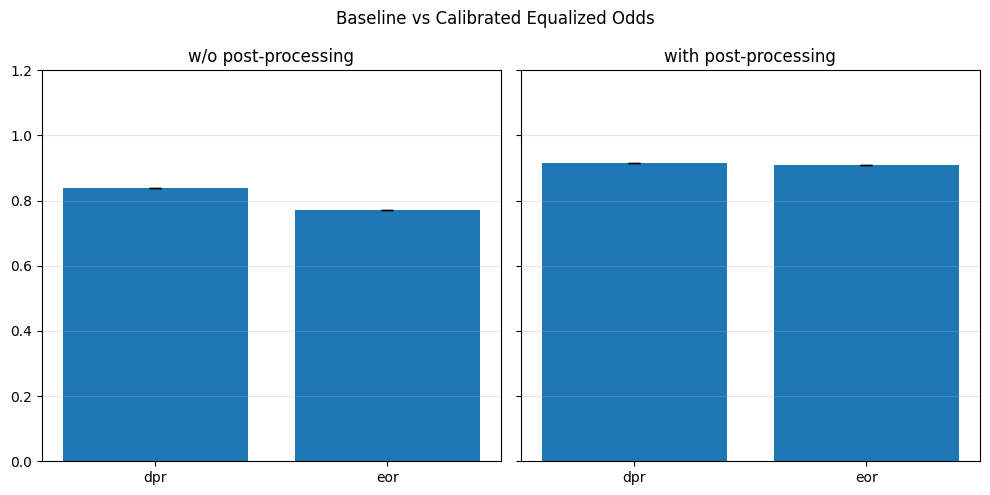

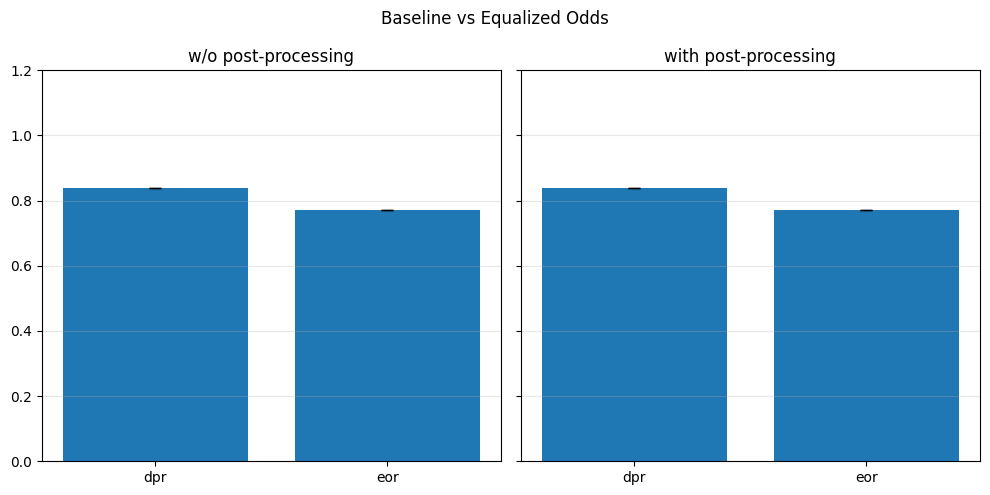

In [150]:
metrics_bar_plot(postproc_baseline_fairness_metrics, 
                 calib_eq_odds_fairness_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['dpr','eor'],
                 title="Baseline vs Calibrated Equalized Odds")

metrics_bar_plot(postproc_baseline_fairness_metrics, 
                 eq_odds_fairness_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['dpr','eor'],
                 title="Baseline vs Equalized Odds")

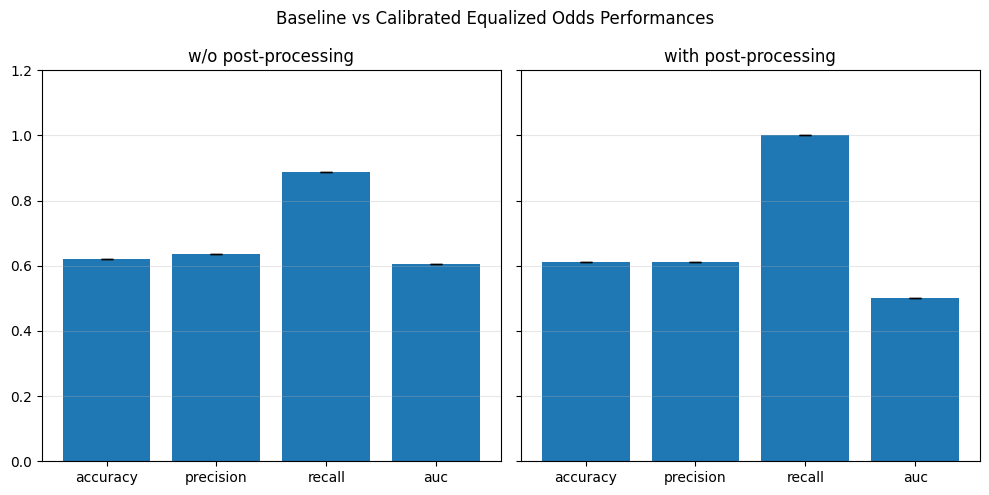

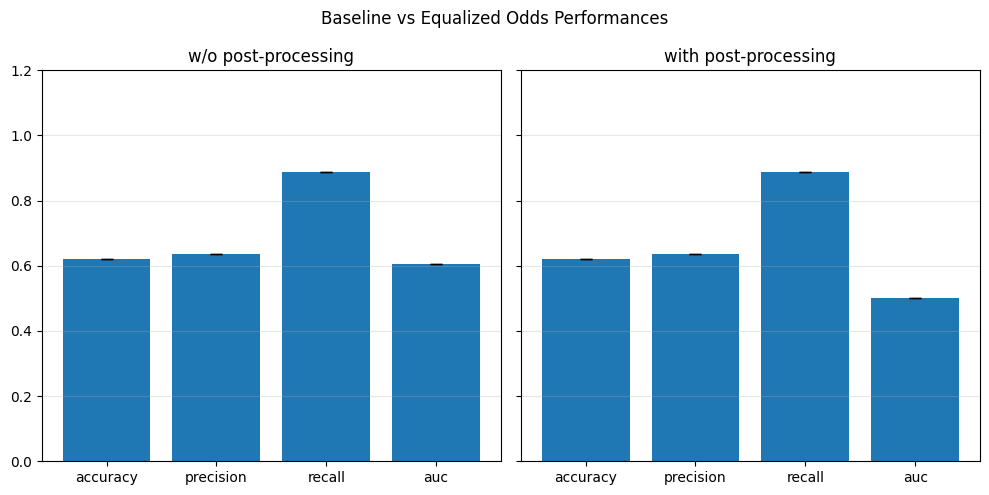

In [151]:
metrics_bar_plot(postproc_baseline_performance_metrics, 
                 calib_eq_odds_performance_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['accuracy','precision', 'recall', 'auc'],
                 title="Baseline vs Calibrated Equalized Odds Performances")

metrics_bar_plot(postproc_baseline_performance_metrics, 
                 eq_odds_performance_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['accuracy','precision', 'recall', 'auc'],
                 title="Baseline vs Equalized Odds Performances")

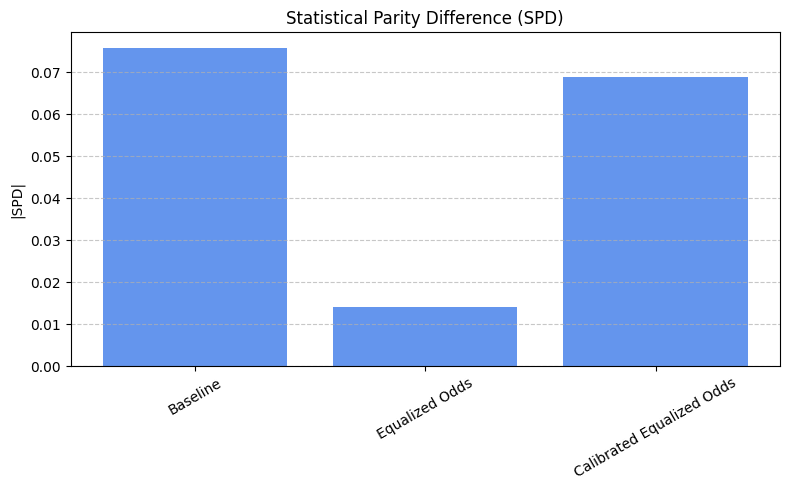

In [152]:
model_names = ['Baseline', 'Equalized Odds', 'Calibrated Equalized Odds']

results = pd.DataFrame({
    'Model': model_names,
    'SPD': spds
})

plt.figure(figsize=(8, 5))
plt.bar(results['Model'], results['SPD'], color='cornflowerblue')
plt.title('Statistical Parity Difference (SPD)')
plt.ylabel('|SPD|')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Because the protected slice has only two positive cases, hard-threshold Equalized Odds finds no feasible adjustment and leaves the metrics unchanged, whereas the more flexible Calibrated Equalized Odds can re-label one borderline instance.

To obtain reliable fairness metrics, we stratify the K-fold split on the joint distribution of the target label and the sensitive attribute, ensuring each fold contains a proportional share of every (target, sensitive-group) combination.

In [153]:
(postproc_df[target].astype(str)+postproc_df[sensitive_feature].astype(str)).value_counts()

13.0    2645
12.0    2100
03.0    1705
02.0    1235
10.0     272
01.0     155
00.0     152
11.0     141
15.0      43
05.0      39
04.0      31
14.0       2
Name: count, dtype: int64

In [154]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
postproc_baseline_fairness_metrics = []
eq_odds_fairness_metrics = []
calib_eq_odds_fairness_metrics = []

postproc_baseline_performance_metrics = []
eq_odds_performance_metrics = []
calib_eq_odds_performance_metrics = []


for fold, (train_idx, test_idx) in enumerate(kf.split(postproc_df, postproc_df[target].astype(str)+postproc_df[sensitive_feature].astype(str))):
    train_df = postproc_df.iloc[train_idx].copy()
    test_df = postproc_df.iloc[test_idx].copy()


    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    clf.fit(train_df.drop(target, axis=1), train_df[target])

    train_scores = clf.predict_proba(train_df.drop(target, axis=1))[:, 1]
    test_scores = clf.predict_proba(test_df.drop(target, axis=1))[:, 1]

    y_test_pred = (test_scores > 0.5).astype(int)
    postproc_baseline_fairness_metrics.append(
        compute_fairness_metrics(test_df[target], y_test_pred, test_df[sensitive_feature]))
    postproc_baseline_performance_metrics.append(compute_performance_metrics(test_df[target], y_test_pred, test_scores))

    calib_eq_odds = aif360_PostProcessing_Wrapper(PostProcessingAlgorithms.CALIBRATED_EQ_ODDS, 
                                                unprivileged_groups=unprivileged_groups, 
                                                privileged_groups=privileged_groups
                                                )

    eq_odds = aif360_PostProcessing_Wrapper(PostProcessingAlgorithms.EQ_ODDS, 
                                                unprivileged_groups=unprivileged_groups, 
                                                privileged_groups=privileged_groups
                                                )
    

    calib_eq_odds.fit(train_df, train_scores)
    eq_odds.fit(train_df, train_scores)

    calib_eq_odds_trans_pred = calib_eq_odds.predict(test_df, test_scores)
    eq_odds_trans_pred = eq_odds.predict(test_df, test_scores)

    calib_eq_odds_fairness_metrics.append( compute_fairness_metrics(test_df[target], calib_eq_odds_trans_pred, test_df[sensitive_feature]))
    eq_odds_fairness_metrics.append( compute_fairness_metrics(test_df[target], eq_odds_trans_pred, test_df[sensitive_feature]))

    calib_eq_odds_performance_metrics.append(compute_performance_metrics(test_df[target], calib_eq_odds_trans_pred, np.ones(len(calib_eq_odds_trans_pred))))
    eq_odds_performance_metrics.append(compute_performance_metrics(test_df[target], eq_odds_trans_pred, np.ones(len(eq_odds_trans_pred))))

/Users/kor/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


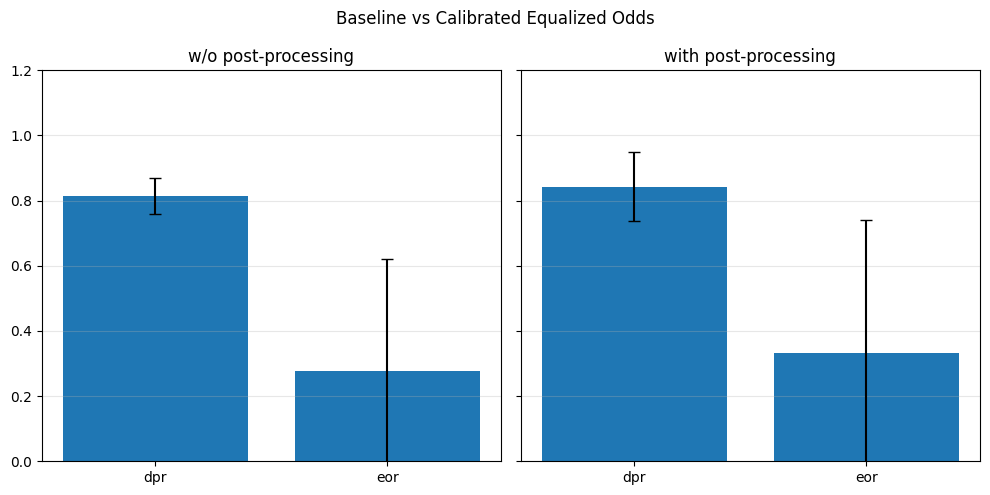

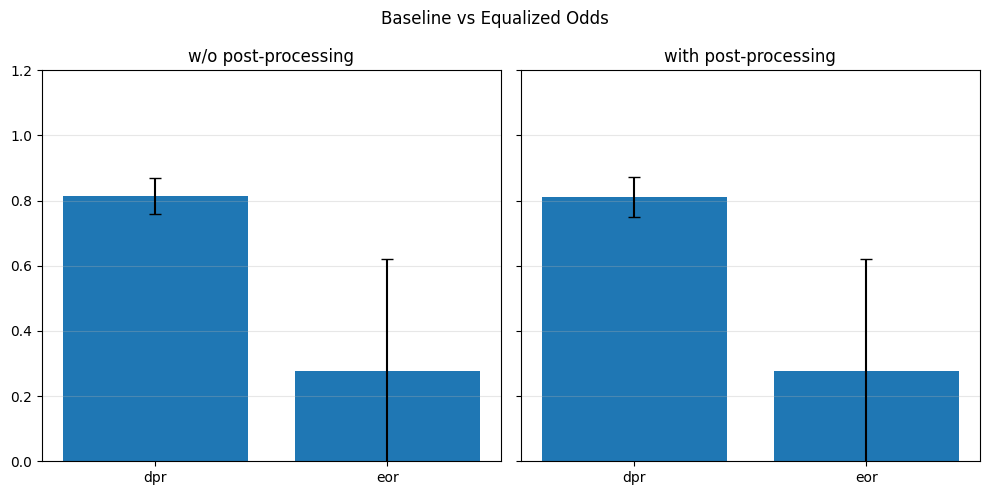

In [155]:
metrics_bar_plot(postproc_baseline_fairness_metrics, 
                 calib_eq_odds_fairness_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['dpr','eor'],
                 title="Baseline vs Calibrated Equalized Odds")

metrics_bar_plot(postproc_baseline_fairness_metrics, 
                 eq_odds_fairness_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['dpr','eor'],
                 title="Baseline vs Equalized Odds")

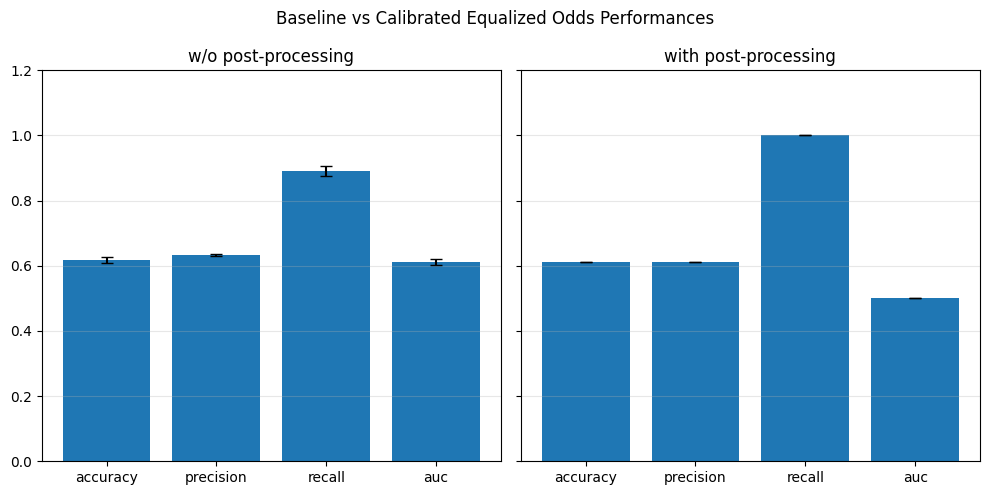

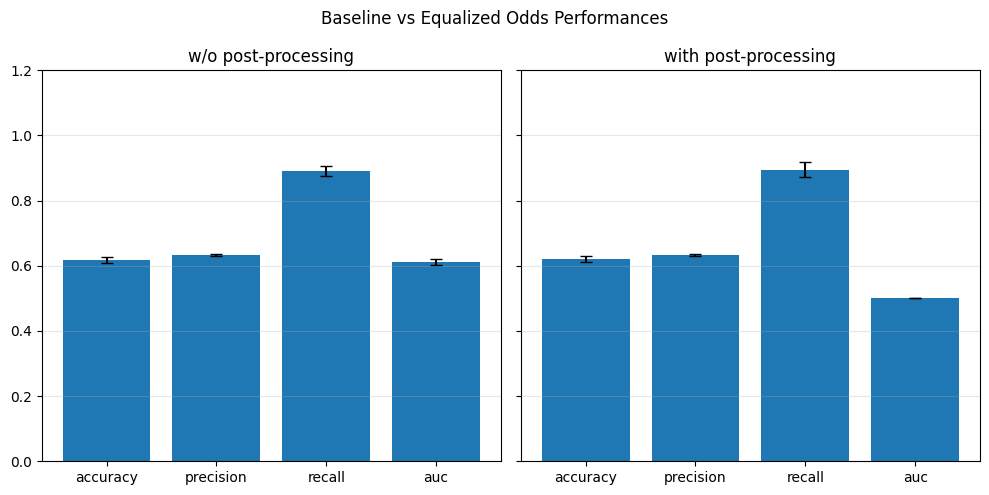

In [156]:
metrics_bar_plot(postproc_baseline_performance_metrics, 
                 calib_eq_odds_performance_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['accuracy','precision', 'recall', 'auc'],
                 title="Baseline vs Calibrated Equalized Odds Performances")

metrics_bar_plot(postproc_baseline_performance_metrics, 
                 eq_odds_performance_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['accuracy','precision', 'recall', 'auc'],
                 title="Baseline vs Equalized Odds Performances")

For the same reason of before, the eq_dots produces the same results as the baseline since it leaves the predictions as they are, while the calibrated_eq_dots improves the solution. Then, if we look at the variance in the boxplot, we can notice that the mean+std of the baseline metrics and the calibrated_eq_odds  are the same as before (without cross validation). This is probably because the techniques are highly dependent on the sensitive feature distribution, that in our case is extremely skewed and contains only two positive examples. We can test this assumption later by duplicating (i.e. oversampling) the positive labels and observing the behaviour of the post processing

In particular, because EOR compares true positive rates across groups, having only 2 positive examples in the protected group means that even one misclassification causes a large drop in  $ P(\hat{Y}=1 | Y=1, S=s) $ (i.e. The probability that the model predicts a positive outcome, given that the true label is positive and the individual belongs to sensitive group s), making the ratio unstable and difficult to improve, while the skewed label distribution limits the ability of the model to predict positives, keeping both EOR and DPR low regardless of post-processing.

If we oversample the positive examples with respect to the sensitive feature:

In [157]:
pos = postproc_df[(postproc_df[sensitive_feature] == 4) & (postproc_df[target] == 1)].copy()
neg = postproc_df[(postproc_df[sensitive_feature] == 4) & (postproc_df[target] == 0)].copy()

pos_oversamples = 6
neg_oversamples = 0

for _ in range(pos_oversamples):
    postproc_df.loc[-1] = pos.sample().iloc[0]      
    postproc_df.index = postproc_df.index + 1 
    postproc_df = postproc_df.sort_index() 

    for _ in range(neg_oversamples):
        postproc_df.loc[-1] = neg.sample().iloc[0]      
        postproc_df.index = postproc_df.index + 1 
        postproc_df = postproc_df.sort_index() 

In [158]:
(postproc_df[target].astype(str)+postproc_df[sensitive_feature].astype(str)).value_counts()

1.03.0    2645
1.02.0    2100
0.03.0    1705
0.02.0    1235
1.00.0     272
0.01.0     155
0.00.0     152
1.01.0     141
1.05.0      43
0.05.0      39
0.04.0      31
1.04.0       8
Name: count, dtype: int64

In [159]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
postproc_baseline_fairness_metrics = []
eq_odds_fairness_metrics = []
calib_eq_odds_fairness_metrics = []

postproc_baseline_performance_metrics = []
eq_odds_performance_metrics = []
calib_eq_odds_performance_metrics = []

for fold, (train_idx, test_idx) in enumerate(kf.split(postproc_df, postproc_df[target].astype(str)+postproc_df[sensitive_feature].astype(str))):
    train_df = postproc_df.iloc[train_idx].copy()
    test_df = postproc_df.iloc[test_idx].copy()

    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    clf.fit(train_df.drop(target, axis=1), train_df[target])

    train_scores = clf.predict_proba(train_df.drop(target, axis=1))[:, 1]
    test_scores = clf.predict_proba(test_df.drop(target, axis=1))[:, 1]

    y_test_pred = (test_scores > 0.5).astype(int)
    postproc_baseline_fairness_metrics.append(
        compute_fairness_metrics(test_df[target], y_test_pred, test_df[sensitive_feature]))
    postproc_baseline_performance_metrics.append(compute_performance_metrics(test_df[target], y_test_pred, test_scores))

    calib_eq_odds = aif360_PostProcessing_Wrapper(PostProcessingAlgorithms.CALIBRATED_EQ_ODDS, 
                                                unprivileged_groups=unprivileged_groups, 
                                                privileged_groups=privileged_groups
                                                )

    eq_odds = aif360_PostProcessing_Wrapper(PostProcessingAlgorithms.EQ_ODDS, 
                                                unprivileged_groups=unprivileged_groups, 
                                                privileged_groups=privileged_groups
                                                )
    

    calib_eq_odds.fit(train_df, train_scores)
    eq_odds.fit(train_df, train_scores)

    calib_eq_odds_trans_pred = calib_eq_odds.predict(test_df, test_scores)
    eq_odds_trans_pred = eq_odds.predict(test_df, test_scores)

    calib_eq_odds_fairness_metrics.append( compute_fairness_metrics(test_df[target], calib_eq_odds_trans_pred, test_df[sensitive_feature]))
    eq_odds_fairness_metrics.append( compute_fairness_metrics(test_df[target], eq_odds_trans_pred, test_df[sensitive_feature]))

    calib_eq_odds_performance_metrics.append(compute_performance_metrics(test_df[target], calib_eq_odds_trans_pred, np.ones(len(calib_eq_odds_trans_pred))))
    eq_odds_performance_metrics.append(compute_performance_metrics(test_df[target], eq_odds_trans_pred, np.ones(len(eq_odds_trans_pred))))

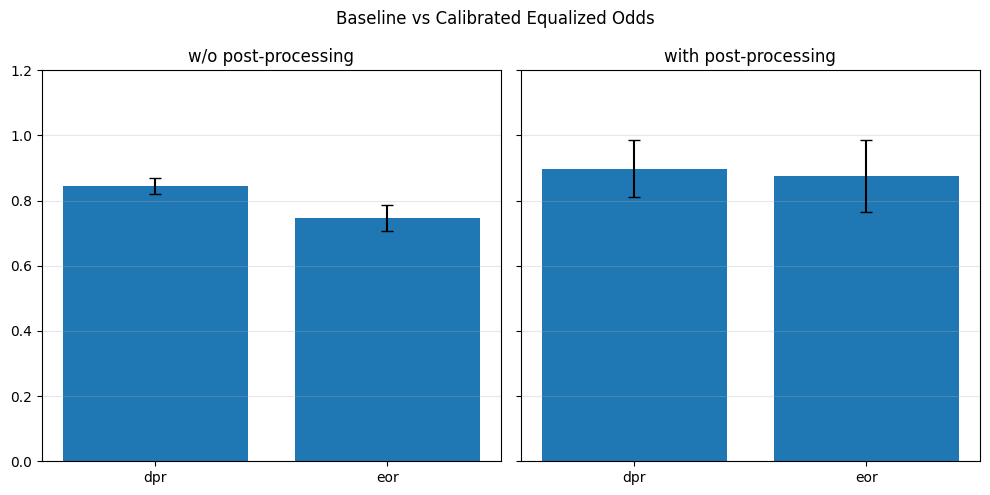

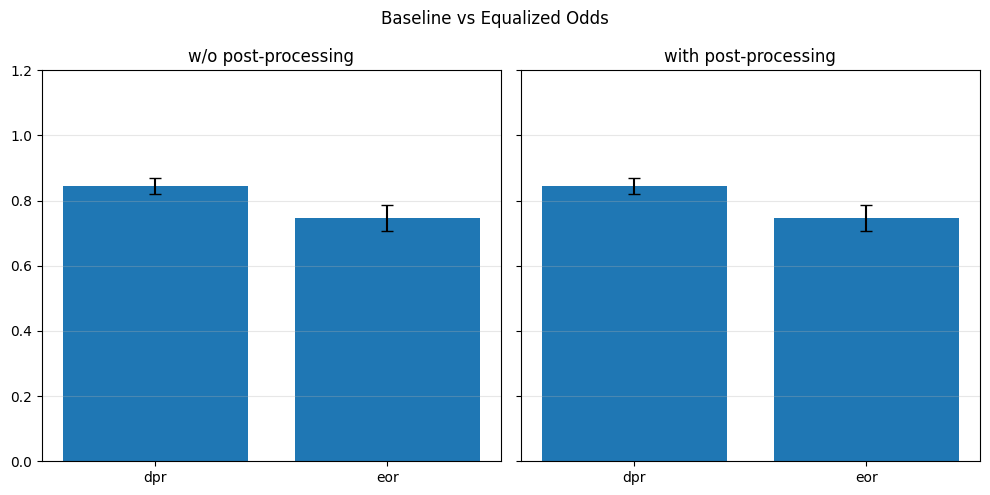

In [160]:
metrics_bar_plot(postproc_baseline_fairness_metrics, 
                 calib_eq_odds_fairness_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['dpr','eor'],
                 title="Baseline vs Calibrated Equalized Odds")

metrics_bar_plot(postproc_baseline_fairness_metrics, 
                 eq_odds_fairness_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['dpr','eor'],
                 title="Baseline vs Equalized Odds")

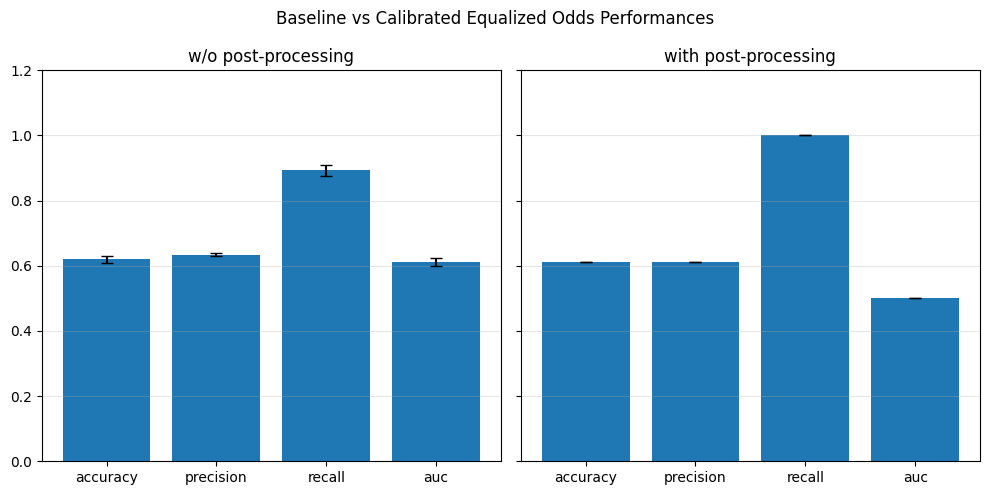

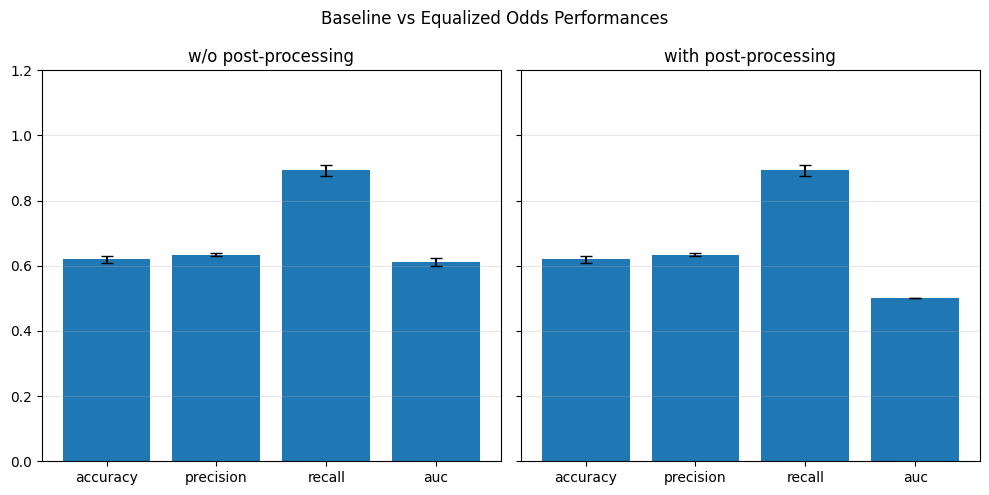

In [161]:
metrics_bar_plot(postproc_baseline_performance_metrics, 
                 calib_eq_odds_performance_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['accuracy','precision', 'recall', 'auc'],
                 title="Baseline vs Calibrated Equalized Odds Performances")

metrics_bar_plot(postproc_baseline_performance_metrics, 
                 eq_odds_performance_metrics, 
                 label1='w/o post-processing', 
                 label2='with post-processing',
                 metrics=['accuracy','precision', 'recall', 'auc'],
                 title="Baseline vs Equalized Odds Performances")

We can observe that the Calibrated Equalized Odds further improves the metrics, but this can just give us an intuition since it is not a real data augmentation. A possible improvement would be to use a powerful data augmentation technique such as SMOTHE in order to produce results according to the real distribution. 